# Needed libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from tqdm import tqdm
import time
from scipy import stats
from scipy.interpolate import interp1d

import seaborn as sbn
import pandas as pd
import h5py
import os
from sklearn.metrics import mean_squared_error
from scipy.ndimage import gaussian_filter
import glob
import matplotlib.patches as patches
from scipy.stats import binned_statistic
import astropy.units as u

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [3]:
print('numpy version:', np.__version__)
print('matplotlib version:', mpl.__version__)
print('torch version:', torch.__version__)

# Check if gpu is available
if torch.cuda.is_available():
    device = 'cuda'
    print('Using GPU')
else:
    device = 'cpu'
    print('Using CPU')


numpy version: 1.22.4
matplotlib version: 3.5.2
torch version: 2.4.1+cu121
Using GPU


In [4]:
class CustomDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        # Convertir las imágenes y etiquetas a tensores
        image = torch.tensor(self.x_data[idx], dtype=torch.float32)
        label = torch.tensor(self.y_data[idx], dtype=torch.float32)
        return image, label

In [8]:
R_bins = np.geomspace(1,100,20)
R_bins = np.delete(R_bins, [1], axis = 0)

In [11]:
arqB_8ch = np.loadtxt("../data/red_curve_data.csv", delimiter=",", skiprows=1)

In [12]:
!ls ../data/CNNpredictions

mass_predictions_3ch.npz		mass_predictions_8ch_19bins.npz
mass_predictions_5ch.npz		mass_predictions_8ch.npz
mass_predictions_8ch_0.6-0.35-0.05.npz	mass_predictions_8ch_wo_outliers.npz


In [13]:
ecnn10_pred = []
for i in range(10):
    ecnn10_pred.append( np.load('../data/predictions_10/M_pred_E2CNN_model_' + str(i) + '.npz')['predicted_mass'] )
ecnn10_pred = np.asarray(ecnn10_pred)
ecnn10_pred = np.delete(ecnn10_pred, [1], axis = 2)

In [15]:
ecnn10_pred.shape

(10, 298, 19)

In [16]:
ecnn_pred = []
for i in range(20):
    ecnn_pred.append( np.load('../data/predictions/M_pred_E2CNN_model_' + str(i) + '.npz')['predicted_mass'] )
ecnn_pred = np.asarray(ecnn_pred)
ecnn_pred = np.delete(ecnn_pred, [1], axis = 2)

In [19]:
cnn_8ch_pred = np.load('../data/CNNpredictions/mass_predictions_8ch.npz')['predicted_mass']
cnn_8ch_pred = np.delete(cnn_8ch_pred, [1], axis = 2)

cnn_8ch_wo_pred = np.load('../data/CNNpredictions/mass_predictions_8ch_wo_outliers.npz')['predicted_mass']
cnn_8ch_wo_pred = np.delete(cnn_8ch_wo_pred, [1], axis = 2)

cnn_8ch_v1_pred = np.load('../data/CNNpredictions/mass_predictions_8ch_0.6-0.35-0.05.npz')['predicted_mass']
cnn_8ch_v1_pred = np.delete(cnn_8ch_v1_pred, [1], axis = 2)

cnn_8ch_pred_19b = np.load('../data/CNNpredictions/mass_predictions_8ch_19bins.npz')['predicted_mass']

cnn_5ch_pred = np.load('../data/CNNpredictions/mass_predictions_5ch.npz')['predicted_mass']
cnn_5ch_pred = np.delete(cnn_5ch_pred, [1], axis = 2)

cnn_3ch_pred = np.load('../data/CNNpredictions/mass_predictions_3ch.npz')['predicted_mass']
cnn_3ch_pred = np.delete(cnn_3ch_pred, [1], axis = 2)


In [11]:
#data_ecnn = np.load('../data/predictions/M_pred_E2CNN_model_' + str(4) + '.npz')

## Custom functions

In [21]:
def plot_quantiles(ax, data_list, real_list, r_norm_list, color_list, 
                   quantiles = [10,16,30,40,45,50,55,60,70,84,90], bins2plot  = [5,12,14,15,16,17,18,18],
                   mean = False, minmax = False):

    '''
    data_list[0]: Must be the real mass
    data_list[1]: Must be the pred mass for model 1
    data_list[2]: Must be the pred mass for model 2
    data_list[3]: Must be the prior mass
    '''
    bins, bin_centers, mse, std, p_results = binned_MSE_q(r_norm_list[0], (np.log10(real_list[0]) - np.log10(data_list[0]))**2, quantiles = quantiles)
    ax[0].plot(bin_centers[bins2plot], p_results['50'][bins2plot], color = color_list[0], label = 'Median', lw = 2, zorder = 0)
    if mean: ax[0].plot(bin_centers[bins2plot], mse[bins2plot], color = color_list[0], label = 'Mean', lw = 2, zorder = 0, ls = '--')
    if minmax:
        for ibin in bins2plot:
            aux_min = np.min((np.log10(real_list[0][:,ibin]) - np.log10(data_list[0][:,ibin]))**2)
            aux_max = np.max((np.log10(real_list[0][:,ibin]) - np.log10(data_list[0][:,ibin]))**2)
            ax[0].vlines(bin_centers[ibin] - 0.1, aux_min, aux_max, color = color_list[0], lw = 1, zorder = 10)
    ax[0].vlines(bin_centers[bins2plot] - 0.14, p_results['10'][bins2plot],p_results['90'][bins2plot], color = color_list[0], lw = 5, alpha = 1.0)
    ax[0].vlines(bin_centers[bins2plot] - 0.34, p_results['16'][bins2plot],p_results['84'][bins2plot], color = color_list[0], lw = 5, alpha = 1.0)
    ax[0].vlines(bin_centers[bins2plot] - 0.54, p_results['30'][bins2plot],p_results['70'][bins2plot], color = color_list[0], lw = 5, alpha = 1.0)
    ax[0].vlines(bin_centers[bins2plot] - 0.74, p_results['40'][bins2plot],p_results['60'][bins2plot], color = color_list[0], lw = 5, alpha = 1.0)
    ax[0].vlines(bin_centers[bins2plot] - 0.94, p_results['45'][bins2plot],p_results['55'][bins2plot], color = color_list[0], lw = 5, alpha = 1.0)

    _, _, mse, std, p_results = binned_MSE_q(r_norm_list[1], (np.log10(real_list[1]) - np.log10(data_list[1]))**2, quantiles = quantiles, bins = bins)
    ax[0].plot(bin_centers[bins2plot], p_results['50'][bins2plot], color = color_list[1], label = 'Median', lw = 2, zorder = 0)
    if mean: ax[0].plot(bin_centers[bins2plot], mse[bins2plot], color = color_list[1], label = 'Mean', lw = 2, zorder = 0, ls = '--')
    if minmax:
        for ibin in bins2plot:
            aux_min = np.min((np.log10(real_list[1][:,ibin]) - np.log10(data_list[1][:,ibin]))**2)
            aux_max = np.max((np.log10(real_list[1][:,ibin]) - np.log10(data_list[1][:,ibin]))**2)
            ax[0].vlines(bin_centers[ibin] + 0.1, aux_min, aux_max, color = color_list[1], lw = 1, zorder = 10)
    ax[0].vlines(bin_centers[bins2plot] + 0.14, p_results['10'][bins2plot],p_results['90'][bins2plot], color = color_list[1], lw = 5)
    ax[0].vlines(bin_centers[bins2plot] + 0.34, p_results['16'][bins2plot],p_results['84'][bins2plot], color = color_list[1], lw = 5)
    ax[0].vlines(bin_centers[bins2plot] + 0.54, p_results['30'][bins2plot],p_results['70'][bins2plot], color = color_list[1], lw = 5)
    ax[0].vlines(bin_centers[bins2plot] + 0.74, p_results['40'][bins2plot],p_results['60'][bins2plot], color = color_list[1], lw = 5)
    ax[0].vlines(bin_centers[bins2plot] + 0.94, p_results['45'][bins2plot],p_results['55'][bins2plot], color = color_list[1], lw = 5)

    if len(data_list) > 2:
        _, _, mse, std, p_results = binned_MSE_q(r_norm_list[2], (np.log10(real_list[2]) - np.log10(data_list[2]))**2, quantiles = [10,16,30,40,45,50,55,60,70,84,90], bins = bins)
        ax[0].plot(bin_centers[bins2plot], p_results['50'][bins2plot], color = color_list[2], label = 'Median', lw = 2, zorder = 0)
        if mean: ax[0].plot(bin_centers[bins2plot], mse[bins2plot], color = color_list[2], label = 'Mean', lw = 2, zorder = 0, ls = '--')
        if minmax:
            for ibin in bins2plot:
                aux_min = np.min((np.log10(real_list[2][:,ibin]) - np.log10(data_list[2][:,ibin]))**2)
                aux_max = np.max((np.log10(real_list[2][:,ibin]) - np.log10(data_list[2][:,ibin]))**2)
                ax[0].vlines(bin_centers[ibin], aux_min, aux_max, color = color_list[2], lw = 1, zorder = 10)
        ax[0].vlines(bin_centers[bins2plot], p_results['16'][bins2plot],p_results['84'][bins2plot], color = color_list[2], lw = 10, zorder = 0)
        ax[0].vlines(bin_centers[bins2plot], p_results['10'][bins2plot],p_results['90'][bins2plot], color = color_list[2], lw = 5, alpha = 0.4, zorder = 0)
        ax[0].vlines(bin_centers[bins2plot] + 0.36, p_results['30'][bins2plot],p_results['70'][bins2plot], color = color_list[2], lw = 5, alpha = 1,zorder=0)
        ax[0].vlines(bin_centers[bins2plot] - 0.36, p_results['30'][bins2plot],p_results['70'][bins2plot], color = color_list[2], lw = 5, alpha = 1,zorder=0)
        ax[0].vlines(bin_centers[bins2plot] + 0.56, p_results['40'][bins2plot],p_results['60'][bins2plot], color = color_list[2], lw = 5, alpha = 1,zorder=0)
        ax[0].vlines(bin_centers[bins2plot] - 0.56, p_results['40'][bins2plot],p_results['60'][bins2plot], color = color_list[2], lw = 5, alpha = 1,zorder=0)
        ax[0].vlines(bin_centers[bins2plot] + 0.76, p_results['45'][bins2plot],p_results['55'][bins2plot], color = color_list[2], lw = 5, alpha = 1,zorder=0)
        ax[0].vlines(bin_centers[bins2plot] - 0.76, p_results['45'][bins2plot],p_results['55'][bins2plot], color = color_list[2], lw = 5, alpha = 1,zorder=0)

    _, _, mse, std, p_results = binned_MSE_q(r_norm_list[0], (data_list[0] / real_list[0]), quantiles = quantiles, bins = bins)
    ax[1].plot(bin_centers[bins2plot], p_results['50'][bins2plot], color = color_list[0], label = 'Median', lw = 2, zorder = 0)
    if mean: ax[1].plot(bin_centers[bins2plot], mse[bins2plot], color = color_list[0], label = 'Mean', lw = 2, zorder = 0, ls = '--')
    if minmax:
        for ibin in bins2plot:
            aux_min = np.min((data_list[0][:,ibin] / real_list[0][:,ibin]))
            aux_max = np.max((data_list[0][:,ibin] / real_list[0][:,ibin]))
            ax[1].vlines(bin_centers[ibin] - 0.1, aux_min, aux_max, color = color_list[0], lw = 1, zorder = 10)
    ax[1].vlines(bin_centers[bins2plot] - 0.14, p_results['10'][bins2plot],p_results['90'][bins2plot], color = color_list[0], lw = 5)
    ax[1].vlines(bin_centers[bins2plot] - 0.34, p_results['16'][bins2plot],p_results['84'][bins2plot], color = color_list[0], lw = 5)
    ax[1].vlines(bin_centers[bins2plot] - 0.54, p_results['30'][bins2plot],p_results['70'][bins2plot], color = color_list[0], lw = 5)
    ax[1].vlines(bin_centers[bins2plot] - 0.74, p_results['40'][bins2plot],p_results['60'][bins2plot], color = color_list[0], lw = 5)
    ax[1].vlines(bin_centers[bins2plot] - 0.94, p_results['45'][bins2plot],p_results['55'][bins2plot], color = color_list[0], lw = 5)

    _, _, mse, std, p_results = binned_MSE_q(r_norm_list[1], (data_list[1] / real_list[1]), quantiles = quantiles, bins = bins)
    ax[1].plot(bin_centers[bins2plot], p_results['50'][bins2plot], color = color_list[1], label = 'Median', lw = 2, zorder = 0)
    if mean: ax[1].plot(bin_centers[bins2plot], mse[bins2plot], color = color_list[1], label = 'Mean', lw = 2, zorder = 0, ls = '--')
    if minmax:
        for ibin in bins2plot:
            aux_min = np.min((data_list[1][:,ibin] / real_list[1][:,ibin]))
            aux_max = np.max((data_list[1][:,ibin] / real_list[1][:,ibin]))
            ax[1].vlines(bin_centers[ibin] + 0.1, aux_min, aux_max, color = color_list[1], lw = 1, zorder = 10)
    ax[1].vlines(bin_centers[bins2plot] + 0.14, p_results['10'][bins2plot],p_results['90'][bins2plot], color = color_list[1], lw = 5)
    ax[1].vlines(bin_centers[bins2plot] + 0.34, p_results['16'][bins2plot],p_results['84'][bins2plot], color = color_list[1], lw = 5)
    ax[1].vlines(bin_centers[bins2plot] + 0.54, p_results['30'][bins2plot],p_results['70'][bins2plot], color = color_list[1], lw = 5)
    ax[1].vlines(bin_centers[bins2plot] + 0.74, p_results['40'][bins2plot],p_results['60'][bins2plot], color = color_list[1], lw = 5)
    ax[1].vlines(bin_centers[bins2plot] + 0.94, p_results['45'][bins2plot],p_results['55'][bins2plot], color = color_list[1], lw = 5)

    if len(data_list) > 2:
        _, _, mse, std, p_results = binned_MSE_q(r_norm_list[2], (data_list[2] / real_list[2]), quantiles = [10,16,30,40,45,50,55,60,70,84,90], bins = bins)
        ax[1].plot(bin_centers[bins2plot], p_results['50'][bins2plot], color = color_list[2], label = 'Median', lw = 2, zorder = 0)
        if mean: ax[1].plot(bin_centers[bins2plot], mse[bins2plot], color = color_list[2], label = 'Mean', lw = 2, zorder = 0, ls = '--')
        if minmax:
            for ibin in bins2plot:
                aux_min = np.min((data_list[2][:,ibin] / real_list[2][:,ibin]))
                aux_max = np.max((data_list[2][:,ibin] / real_list[2][:,ibin]))
                ax[1].vlines(bin_centers[ibin], aux_min, aux_max, color = color_list[2], lw = 1, zorder = 10)
        ax[1].vlines(bin_centers[bins2plot], p_results['16'][bins2plot],p_results['84'][bins2plot], color = color_list[2], lw = 10, zorder = 0)
        ax[1].vlines(bin_centers[bins2plot] , p_results['10'][bins2plot],p_results['90'][bins2plot], color = color_list[2], lw = 5, alpha = 0.4, zorder = 0)
        ax[1].vlines(bin_centers[bins2plot] + 0.36, p_results['30'][bins2plot],p_results['70'][bins2plot], color = color_list[2], lw = 5, alpha = 1,zorder=0)
        ax[1].vlines(bin_centers[bins2plot] + 0.56, p_results['40'][bins2plot],p_results['60'][bins2plot], color = color_list[2], lw = 5, alpha = 1,zorder=0)
        ax[1].vlines(bin_centers[bins2plot] - 0.36, p_results['30'][bins2plot],p_results['70'][bins2plot], color = color_list[2], lw = 5, alpha = 1,zorder=0)
        ax[1].vlines(bin_centers[bins2plot] - 0.56, p_results['40'][bins2plot],p_results['60'][bins2plot], color = color_list[2], lw = 5, alpha = 1,zorder=0)
        ax[1].vlines(bin_centers[bins2plot] + 0.76, p_results['45'][bins2plot],p_results['55'][bins2plot], color = color_list[2], lw = 5, alpha = 1,zorder=0)
        ax[1].vlines(bin_centers[bins2plot] - 0.76, p_results['45'][bins2plot],p_results['55'][bins2plot], color = color_list[2], lw = 5, alpha = 1,zorder=0)

    return ax

In [22]:
def plot_quantiles_kpc(ax, data_list, real_list, color_list, 
                   quantiles = [10,16,30,40,45,50,55,60,70,84,90], bins2plot  = [5,12,14,15,16,17,18,18],
                   mean = False, minmax = False, bin_centers = R_bins):

    '''
    data_list[0]: Must be the real mass
    data_list[1]: Must be the pred mass for model 1
    data_list[2]: Must be the pred mass for model 2
    data_list[3]: Must be the prior mass
    '''
    mse, std, p_results = binned_MSE_kpc((np.log10(real_list[0]) - np.log10(data_list[0]))**2, quantiles = quantiles)
    ax[0].plot(bin_centers[bins2plot], p_results['50'][bins2plot], color = color_list[0], label = 'Median', lw = 2, zorder = 0)
    if mean: ax[0].plot(bin_centers[bins2plot], mse[bins2plot], color = color_list[0], label = 'Mean', lw = 2, zorder = 0, ls = '--')
    if minmax:
        for ibin in bins2plot:
            aux_min = np.min((np.log10(real_list[0][:,ibin]) - np.log10(data_list[0][:,ibin]))**2)
            aux_max = np.max((np.log10(real_list[0][:,ibin]) - np.log10(data_list[0][:,ibin]))**2)
            ax[0].vlines(bin_centers[ibin] - 0.1, aux_min, aux_max, color = color_list[0], lw = 1, zorder = 10)
    ax[0].vlines(bin_centers[bins2plot] - 0.4, p_results['10'][bins2plot],p_results['90'][bins2plot], color = color_list[0], lw = 5)
    ax[0].vlines(bin_centers[bins2plot] - 1.3, p_results['16'][bins2plot],p_results['84'][bins2plot], color = color_list[0], lw = 5)
    ax[0].vlines(bin_centers[bins2plot] - 1.9, p_results['30'][bins2plot],p_results['70'][bins2plot], color = color_list[0], lw = 5)
    ax[0].vlines(bin_centers[bins2plot] - 2.6, p_results['40'][bins2plot],p_results['60'][bins2plot], color = color_list[0], lw = 5)

    mse, std, p_results = binned_MSE_kpc((np.log10(real_list[1]) - np.log10(data_list[1]))**2, quantiles = quantiles)
    ax[0].plot(bin_centers[bins2plot], p_results['50'][bins2plot], color = color_list[1], label = 'Median', lw = 2, zorder = 0)
    if mean: ax[0].plot(bin_centers[bins2plot], mse[bins2plot], color = color_list[1], label = 'Mean', lw = 2, zorder = 0, ls = '--')
    if minmax:
        for ibin in bins2plot:
            aux_min = np.min((np.log10(real_list[1][:,ibin]) - np.log10(data_list[1][:,ibin]))**2)
            aux_max = np.max((np.log10(real_list[1][:,ibin]) - np.log10(data_list[1][:,ibin]))**2)
            ax[0].vlines(bin_centers[ibin] + 0.1, aux_min, aux_max, color = color_list[1], lw = 1, zorder = 10)
    ax[0].vlines(bin_centers[bins2plot] + 0.4 , p_results['10'][bins2plot],p_results['90'][bins2plot], color = color_list[1], lw = 5)
    ax[0].vlines(bin_centers[bins2plot] + 1.3, p_results['16'][bins2plot],p_results['84'][bins2plot], color = color_list[1], lw = 5)
    ax[0].vlines(bin_centers[bins2plot] + 1.9, p_results['30'][bins2plot],p_results['70'][bins2plot], color = color_list[1], lw = 5)
    ax[0].vlines(bin_centers[bins2plot] + 2.6, p_results['40'][bins2plot],p_results['60'][bins2plot], color = color_list[1], lw = 5)

    if len(data_list) > 2:
        mse, std, p_results = binned_MSE_kpc((np.log10(real_list[2]) - np.log10(data_list[2]))**2, quantiles = [10,16,30,40,45,50,55,60,70,84,90])
        ax[0].plot(bin_centers[bins2plot], p_results['50'][bins2plot], color = color_list[2], label = 'Median', lw = 2, zorder = 0)
        if mean: ax[0].plot(bin_centers[bins2plot], mse[bins2plot], color = color_list[2], label = 'Mean', lw = 2, zorder = 0, ls = '--')
        if minmax:
            for ibin in bins2plot:
                aux_min = np.min((np.log10(real_list[2][:,ibin]) - np.log10(data_list[2][:,ibin]))**2)
                aux_max = np.max((np.log10(real_list[2][:,ibin]) - np.log10(data_list[2][:,ibin]))**2)
                ax[0].vlines(bin_centers[ibin], aux_min, aux_max, color = color_list[2], lw = 1, zorder = 10)
        ax[0].vlines(bin_centers[bins2plot], p_results['10'][bins2plot],p_results['90'][bins2plot], color = color_list[2], lw = 5, zorder = 0)
        ax[0].vlines(bin_centers[bins2plot], p_results['16'][bins2plot],p_results['84'][bins2plot], color = color_list[2], lw = 10, zorder = 0)
        ax[0].vlines(bin_centers[bins2plot], p_results['30'][bins2plot],p_results['70'][bins2plot], color = color_list[2], lw = 20,zorder=0)
        ax[0].vlines(bin_centers[bins2plot], p_results['40'][bins2plot],p_results['60'][bins2plot], color = color_list[2], lw = 40,zorder=0)
        ax[0].vlines(bin_centers[bins2plot], p_results['45'][bins2plot],p_results['55'][bins2plot], color = color_list[2], lw = 60,zorder=0)

    mse, std, p_results = binned_MSE_kpc((data_list[0] / real_list[0]), quantiles = quantiles)
    ax[1].plot(bin_centers[bins2plot], p_results['50'][bins2plot], color = color_list[0], label = 'Median', lw = 2, zorder = 0)
    if mean: ax[1].plot(bin_centers[bins2plot], mse[bins2plot], color = color_list[0], label = 'Mean', lw = 2, zorder = 0, ls = '--')
    if minmax:
        for ibin in bins2plot:
            aux_min = np.min((data_list[0][:,ibin] / real_list[0][:,ibin]))
            aux_max = np.max((data_list[0][:,ibin] / real_list[0][:,ibin]))
            ax[1].vlines(bin_centers[ibin] - 0.1, aux_min, aux_max, color = color_list[0], lw = 1, zorder = 10)
    ax[1].vlines(bin_centers[bins2plot] - 0.4, p_results['10'][bins2plot],p_results['90'][bins2plot], color = color_list[0], lw = 5)
    ax[1].vlines(bin_centers[bins2plot] - 1.3, p_results['16'][bins2plot],p_results['84'][bins2plot], color = color_list[0], lw = 5)
    ax[1].vlines(bin_centers[bins2plot] - 1.9, p_results['30'][bins2plot],p_results['70'][bins2plot], color = color_list[0], lw = 5)
    ax[1].vlines(bin_centers[bins2plot] - 2.6, p_results['40'][bins2plot],p_results['60'][bins2plot], color = color_list[0], lw = 5)

    mse, std, p_results = binned_MSE_kpc((data_list[1] / real_list[1]), quantiles = quantiles)
    ax[1].plot(bin_centers[bins2plot], p_results['50'][bins2plot], color = color_list[1], label = 'Median', lw = 2, zorder = 0)
    if mean: ax[1].plot(bin_centers[bins2plot], mse[bins2plot], color = color_list[1], label = 'Mean', lw = 2, zorder = 0, ls = '--')
    if minmax:
        for ibin in bins2plot:
            aux_min = np.min((data_list[1][:,ibin] / real_list[1][:,ibin]))
            aux_max = np.max((data_list[1][:,ibin] / real_list[1][:,ibin]))
            ax[1].vlines(bin_centers[ibin] + 0.1, aux_min, aux_max, color = color_list[1], lw = 1, zorder = 10)
    ax[1].vlines(bin_centers[bins2plot] + 0.4 , p_results['10'][bins2plot],p_results['90'][bins2plot], color = color_list[1], lw = 5)
    ax[1].vlines(bin_centers[bins2plot] + 1.3, p_results['16'][bins2plot],p_results['84'][bins2plot], color = color_list[1], lw = 5)
    ax[1].vlines(bin_centers[bins2plot] + 1.9, p_results['30'][bins2plot],p_results['70'][bins2plot], color = color_list[1], lw = 5)
    ax[1].vlines(bin_centers[bins2plot] + 2.6, p_results['40'][bins2plot],p_results['60'][bins2plot], color = color_list[1], lw = 5)

    if len(data_list) > 2:
        mse, std, p_results = binned_MSE_kpc((data_list[2] / real_list[2]), quantiles = [10,16,30,40,45,50,55,60,70,84,90])
        ax[1].plot(bin_centers[bins2plot], p_results['50'][bins2plot], color = color_list[2], label = 'Median', lw = 2, zorder = 0)
        if mean: ax[1].plot(bin_centers[bins2plot], mse[bins2plot], color = color_list[2], label = 'Mean', lw = 2, zorder = 0, ls = '--')
        if minmax:
            for ibin in bins2plot:
                aux_min = np.min((data_list[2][:,ibin] / real_list[2][:,ibin]))
                aux_max = np.max((data_list[2][:,ibin] / real_list[2][:,ibin]))
                ax[1].vlines(bin_centers[ibin], aux_min, aux_max, color = color_list[2], lw = 1, zorder = 10)
        ax[1].vlines(bin_centers[bins2plot], p_results['10'][bins2plot],p_results['90'][bins2plot], color = color_list[2], lw = 5, zorder = 0)
        ax[1].vlines(bin_centers[bins2plot], p_results['16'][bins2plot],p_results['84'][bins2plot], color = color_list[2], lw = 10, zorder = 0)
        ax[1].vlines(bin_centers[bins2plot], p_results['30'][bins2plot],p_results['70'][bins2plot], color = color_list[2], lw = 20,zorder=0)
        ax[1].vlines(bin_centers[bins2plot], p_results['40'][bins2plot],p_results['60'][bins2plot], color = color_list[2], lw = 40,zorder=0)
        ax[1].vlines(bin_centers[bins2plot], p_results['45'][bins2plot],p_results['55'][bins2plot], color = color_list[2], lw = 60,zorder=0)

    return ax

In [23]:
def SplitViolin(ax, data1, data2, R_bins, scale = 500, r_norm = None, r_bins = np.linspace(0.01,40,15),
                bw_adjust=0.5):
    
    if r_norm is not None:
        data1_flat = data1.flatten()
        data2_flat = data2.flatten()
        r_flat = r_norm.flatten()
        bin_indices = np.digitize(r_flat, r_bins) - 1
        R_bins = r_bins
        
    for i, center in enumerate(R_bins):

        # Extraer los datos de cada grupo
        if r_norm is not None:
            d1 = data1_flat[np.where(bin_indices == i)[0]]
            d2 = data2_flat[np.where(bin_indices == i)[0]]
        else:
            d1 = data1[:,i]
            d2 = data2[:,i]

        # KDE izquierdo
        sns.kdeplot(
            y=d1, ax=ax, bw_adjust=bw_adjust, clip=[-5, 5],
            linewidth=0,
            fill=True,
            color='blue',
            alpha=0.9,
            label='Pred' if i == 0 else "",  # solo en la primera iteración
        )

        # Obtener la última colección de polígonos (el relleno)
        poly1 = ax.collections[-1]
        for p in poly1.get_paths():
            verts = p.vertices
            verts[:, 0] = center - (center/scale)*np.abs(verts[:, 0])  # Solo lado izquierdo

        # KDE derecho
        sns.kdeplot(
            y=d2, ax=ax, bw_adjust=bw_adjust, clip=[-5, 5],
            linewidth=0,
            fill=True,
            color='red',
            alpha=0.9,
            label='Prior' if i == 0 else "",
        )

        poly2 = ax.collections[-1]
        for p in poly2.get_paths():
            verts = p.vertices
            verts[:, 0] = center + (center/scale)*np.abs(verts[:, 0])  # Solo lado derecho

    return ax

In [25]:
def binned_MSE(x, y, nbins = 19, xmin = -1, xmax = 1.5, bins = None):
    
    x_flat = x.flatten()
    y_flat = y
    y_flat = y_flat.flatten()

    if bins is None: bins = np.logspace(xmin, xmax, nbins + 1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    
    p10_func = lambda y: np.percentile(y, 10)
    p16_func = lambda y: np.percentile(y, 16)
    p50_func = lambda y: np.percentile(y, 50)  # también es la mediana
    p84_func = lambda y: np.percentile(y, 84)
    p90_func = lambda y: np.percentile(y, 90)
    
    # Calcular la media de y en cada bin de x
    y_bin_means, _, _ = binned_statistic(x_flat, y_flat, statistic='mean', bins=bins)
    y_bin_std, _, _ = binned_statistic(x_flat, y_flat, statistic='std', bins=bins)
    p10, _, _ = binned_statistic(x_flat, y_flat, statistic=p10_func, bins=bins)
    p16, _, _ = binned_statistic(x_flat, y_flat, statistic=p16_func, bins=bins)
    p50, _, _ = binned_statistic(x_flat, y_flat, statistic=p50_func, bins=bins)
    p84, _, _ = binned_statistic(x_flat, y_flat, statistic=p84_func, bins=bins)
    p90, _, _ = binned_statistic(x_flat, y_flat, statistic=p90_func, bins=bins)
    # Coordenadas x de los centros de bin para graficar
    
    return bins, bin_centers, y_bin_means, y_bin_std, p10, p16, p50, p84, p90

def binned_MSE_q(x, y, nbins = 19, xmin = -1, xmax = 1.5, quantiles = [10,16,45,50,55,84,90], bins = None):
    
    x_flat = x.flatten()
    y_flat = y
    y_flat = y_flat.flatten()

    if bins is None: bins = np.logspace(xmin, xmax, nbins + 1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    
    # Calcular la media de y en cada bin de x
    y_bin_means, _, _ = binned_statistic(x_flat, y_flat, statistic='mean', bins=bins)
    y_bin_std, _, _ = binned_statistic(x_flat, y_flat, statistic='std', bins=bins)
    p_results = {}
    for iq in quantiles:
        aux_func = lambda y: np.percentile(y, iq)
        p_aux, _, _ = binned_statistic(x_flat, y_flat, statistic=aux_func, bins=bins)
        p_results.update({str(iq):p_aux})
    
    return bins, bin_centers, y_bin_means, y_bin_std, p_results

In [26]:
def binned_MSE_kpc(y, quantiles = [10,16,45,50,55,84,90]):
    
    # Calcular la media de y en cada bin de x
    y_bin_mean = np.mean(y, axis = 0)
    y_bin_std = np.std(y, axis = 0)
    p_aux = np.percentile(y, axis = 0, q = quantiles)
    p_results = {}
    for i,iq in enumerate(quantiles):
        p_results.update({str(iq):p_aux[i,:]})
    
    return y_bin_mean, y_bin_std, p_results

In [27]:
def estimate_saliency_map(model, image, radial_bin, noise_levels = np.array([1e-3,1e-3,1e-3,1e-3,1e-3,1e-2,1e-5,1e-7]).reshape(1,8,1,1),
                         num_perturbations = 20):
    
    image.requires_grad = True  # Enable gradient computation

    # Initialize an empty tensor to accumulate gradients
    accumulated_saliency = torch.zeros_like(image)

    for _ in range(num_perturbations):
        # Add Gaussian noise to the image
        noisy_image = image + torch.Tensor(noise_levels) * torch.randn_like(image)

        # Forward pass
        output = model(noisy_image)

        # Zero out any previous gradients
        model.zero_grad()

        # Compute the gradient of the output with respect to the target index
        output[0, radial_bin].backward(retain_graph=True)

        # Accumulate the gradients
        accumulated_saliency += image.grad

    # Average the accumulated saliency maps
    accumulated_saliency /= num_perturbations

    # Get the final saliency map (absolute value of gradients)
    saliency_map = accumulated_saliency.abs().squeeze().detach().cpu().numpy()
    
    return saliency_map

In [28]:
def dm_from_stellar(stellar_profile, num_smass_bins = 10):
    dm_profile     = np.zeros_like(stellar_profile)
    dm_profile_std = np.zeros_like(stellar_profile)
    
    for i in range(19):
        stellar_mass_bins = np.linspace(np.min(np.log10(labels[:,1,i])), np.max(np.log10(labels[:,1,i])), num_smass_bins)
        aux_bin = np.digitize(np.log10(stellar_profile[i]), stellar_mass_bins)

        ind = np.where( (np.log10(labels[:,1,i]) > stellar_mass_bins[aux_bin-1]) & 
                  (np.log10(labels[:,1,i]) < stellar_mass_bins[aux_bin]) )[0]
        dm_profile[i] = np.mean(np.log10(labels[ind,0,i]))
        dm_profile_std[i] = np.std(np.log10(labels[ind,0,i]))
        
    return dm_profile, dm_profile_std

# Reading data

In [29]:
images = np.load('../data/TNGgalaxies_28_02/noisy_images.npy')
labels = np.load('../data/TNGgalaxies_28_02/labels.npy')

In [31]:
labels = np.delete(labels, [1], axis = 2)
labels.shape

(2972, 3, 19)

In [32]:
dm_prior_profile     = np.mean(np.log10(labels[:,0,:]), axis = 0)
dm_prior_profile_std = np.std(np.log10(labels[:,0,:]), axis = 0)

dm_quantiles = np.quantile(np.log10(labels[:,0,:]), axis = 0, q = [0.1,0.25,0.75,0.9])

In [33]:
properties = np.load('../data/TNGgalaxies_28_02/properties.npy')

In [34]:
properties.shape

(2972, 20)

In [35]:
print(f'There are {len(np.where(np.isnan(images) == True)[0])} nans in images')
print(f'There are {len(np.where(np.isnan(labels) == True)[0])} nans in labels')

There are 3086 nans in images
There are 0 nans in labels


In [36]:
images = np.nan_to_num(images, nan=0)

In [31]:
#images = np.moveaxis(images, 1, -1)

In [32]:
#images = images[:100,:,:,:]
#labels = labels[:100,:]

In [33]:
#images = images[:,5:,:,:]
#images = images[:,0,:,:].reshape(nobs,1,npix,npix)

In [37]:
nobs,nch, npix, _ = images.shape

In [38]:
nch

8

In [39]:
np.random.seed(28890)
random_ind = np.random.choice(np.arange(nobs), size = nobs, replace = False)

train_size = int(0.7 * nobs) #0.7
val_size   = int(0.2 * nobs) #0.2
test_size  = nobs - train_size - val_size

train_ind = random_ind[:train_size]
val_ind   = random_ind[train_size:(val_size + train_size)]
test_ind  = random_ind[-test_size:]

In [40]:
x_trainset = images[train_ind,:,:,:]
x_valset   = images[val_ind,:,:,:]
x_testset  = images[test_ind,:,:,:]

y_trainset = np.log10(labels[train_ind,0,:])
y_valset   = np.log10(labels[val_ind,0,:])
y_testset  = np.log10(labels[test_ind,0,:])

In [41]:
min_x = np.min(x_trainset, axis = (0,2,3))
max_x = np.max(x_trainset, axis = (0,2,3))

min_x = min_x[:, np.newaxis, np.newaxis]
max_x = max_x[:, np.newaxis, np.newaxis]

min_y = np.min(y_trainset, axis = 0)
max_y = np.max(y_trainset, axis = 0)

In [42]:
x_trainset = (x_trainset - min_x) / (max_x - min_x)
x_valset   = (x_valset - min_x) / (max_x - min_x)
x_testset  = (x_testset - min_x) / (max_x - min_x)

y_trainset = (y_trainset - min_y) / (max_y - min_y)
y_valset   = (y_valset - min_y) / (max_y - min_y)
y_testset  = (y_testset - min_y) / (max_y - min_y)

In [163]:
train_outliers = [ 113,  146,  404,  598,  895,  961,  978, 1076, 1131, 1294, 1309,
       1461, 1475, 1520, 1599, 1665, 1707, 1794, 1808, 1809, 1841, 1925,
       1942]
test_outliers = [ 40, 106, 127, 143, 164, 275, 277]
val_outliers = [123, 216, 289, 302, 479]

In [734]:
x_trainset = np.delete(x_trainset, train_outliers, axis = 0)
x_valset   = np.delete(x_valset, val_outliers, axis = 0)
x_testset  = np.delete(x_testset, test_outliers, axis = 0)

y_trainset = np.delete(y_trainset, train_outliers, axis = 0)
y_valset   = np.delete(y_valset, val_outliers, axis = 0)
y_testset  = np.delete(y_testset, test_outliers, axis = 0)

train_ind = np.delete(train_ind, train_outliers, axis = 0)
test_ind  = np.delete(test_ind, test_outliers, axis = 0)
val_ind   = np.delete(val_ind, val_outliers, axis = 0)

ecnn_pred = np.delete(ecnn_pred, test_outliers, axis = 1)

In [43]:
ecnn_pred.shape

(20, 298, 19)

In [44]:
min_y.shape

(19,)

In [45]:
dm_from_stellar_functions = []
for i in range(len(R_bins)):
    aux_x = labels[train_ind,1,i]
    aux_y = labels[train_ind,0,i]
    _,aux_ind = np.unique(aux_x, return_index=True)
    aux_x = aux_x[aux_ind]
    aux_y = aux_y[aux_ind]
    aux_ind = np.argsort(aux_x)
    x = np.log10(aux_x[aux_ind])
    y = np.log10(aux_y[aux_ind])
    #y = np.log10(labels[train_ind,0,i])
    dm_from_stellar_functions.append( interp1d(x, y, fill_value=(y.min(), y.max()), bounds_error=False, kind = 'linear',assume_sorted=True) )

In [46]:
check = np.zeros_like(labels[test_ind,1,:])
for i in range(len(R_bins)):
    check[:,i] = dm_from_stellar_functions[i](np.log10(labels[test_ind,1,i]))

In [47]:
np.mean(np.abs(check - np.log10(labels[test_ind,0,:])))

0.06434150101977149

In [48]:
# Just the mean profile of the training set

y_prior = (dm_prior_profile - min_y) / (max_y - min_y)
y_prior = np.tile(y_prior, (len(y_testset), 1))

M_prior = 10**(y_prior * (max_y - min_y) + min_y)

## Plots

In [151]:
properties[test_ind[277],:]

array([ 2.77687000e+05,  1.18000000e+02,  1.96040744e+13,  5.44107000e+00,
        2.62773841e+02,  1.53534101e+04,  2.02072631e+04,  5.58740774e+04,
       -2.58124000e+01, -1.60609000e+02, -3.24138000e+02,  4.26180000e+02,
        9.37893416e+01,  1.84100974e+01, -5.57408155e-01,  2.54727914e-01,
        3.05220194e-01,  1.74536803e+01,  8.19920719e-01,  1.00000000e+00])

In [ ]:
[ 40, 106, 127, 143, 164, 275, 277]

In [226]:
test_ind[[40, 106, 127, 143, 164, 275, 277]]

array([196, 255,  61, 244,  50,  53,  86])

In [265]:
gid = 13
img = x_trainset[gid,:,:,:] * (max_x - min_x) + min_x

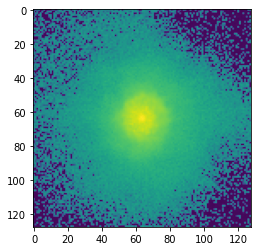

In [266]:
plt.imshow(np.log10(img[4,:,:]))
plt.savefig('../graphs/photometric_' + str(train_ind[gid]) + '.pdf')

In [35]:
from astropy.modeling.models import Sersic2D
from astropy.modeling import fitting

In [276]:
print(properties[train_ind[50],13])
print(properties[train_ind[50],15])

3.1324180690876884
0.6877221833790591


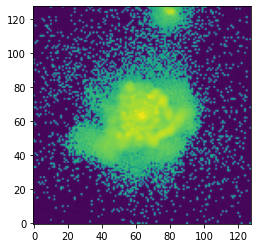

In [277]:
image_data = x_trainset[50,0,:,:] * (max_x[0] - min_x[0]) + min_x[0]
plt.imshow(np.log10(image_data), origin='lower')

In [283]:
y, x = np.mgrid[:npix, :npix]

sersic_init = Sersic2D(amplitude=1, r_eff=1, n=1,
                       x_0=64, y_0=64,
                       ellip=0.5, theta=0)
fitter = fitting.LevMarLSQFitter()
sersic_fit = fitter(sersic_init, x, y, image_data)

In [284]:
sersic_fit

<Sersic2D(amplitude=0.01991504, r_eff=-8.46531141, n=2.47283456, x_0=63.30251795, y_0=63.36985381, ellip=-0.25978524, theta=-0.99336624)>

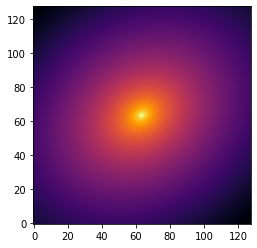

In [285]:
model_image = sersic_fit(x, y)
plt.imshow(np.log10(model_image), origin='lower', cmap='inferno')

In [332]:
np.log10(labels[:,1,i*4+j]).min()

10.001017565935886

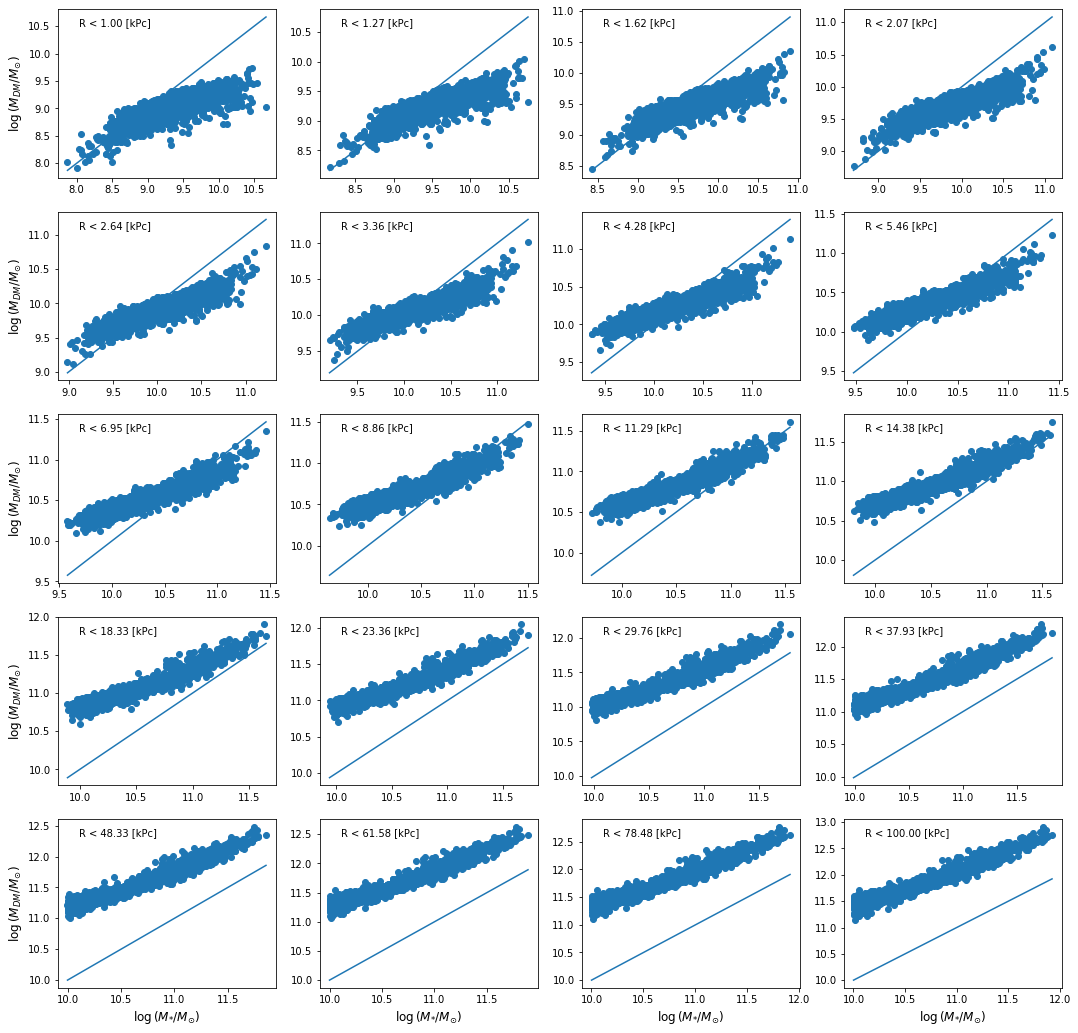

In [334]:
fig, ax = plt.subplots(5,4, figsize = (18,18))

for i in range(5):
    for j in range(4):

        ax[i,j].scatter(np.log10(labels[:,1,i*4+j]), np.log10(labels[:,0,i*4+j]))
        ax[i,j].plot([np.log10(labels[:,1,i*4+j]).min(), np.log10(labels[:,1,i*4+j]).max()],
                     [np.log10(labels[:,1,i*4+j]).min(), np.log10(labels[:,1,i*4+j]).max()])
        
        if i == 4: ax[i,j].set_xlabel('$\log{(M_{*} / M_{\odot})}$', fontsize = 12)
        if j == 0: ax[i,j].set_ylabel('$\log{(M_{DM} / M_{\odot})}$', fontsize = 12)
        ax[i,j].text(0.1,0.9,'R < {:.2f} [kPc]'.format(R_bins[i*4+j]), transform = ax[i,j].transAxes)
        
plt.savefig('../graphs/StellarVSDM.pdf')

In [18]:
labels.shape

(2972, 3, 20)

In [43]:
stellar_mass_bins = np.linspace(np.min(np.log10(labels[:,1,nbin])), np.max(np.log10(labels[:,1,nbin])), 10)

In [51]:
stellar_mass_bins

array([ 8.70095989,  8.96562015,  9.23028042,  9.49494069,  9.75960096,
       10.02426122, 10.28892149, 10.55358176, 10.81824203, 11.0829023 ])

In [49]:
np.digitize(10, stellar_mass_bins)

5

In [52]:
radial_bin = 3 
mstellar = 10
aux_bin = np.digitize(mstellar, stellar_mass_bins)

ind = np.where( (np.log10(labels[:,1,radial_bin]) > stellar_mass_bins[aux_bin-1]) & 
          (np.log10(labels[:,1,radial_bin]) < stellar_mass_bins[aux_bin]) )[0]

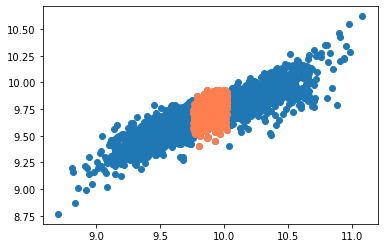

In [53]:
plt.scatter(np.log10(labels[:,1,radial_bin]), np.log10(labels[:,0,radial_bin]))
plt.scatter(np.log10(labels[ind,1,radial_bin]), np.log10(labels[ind,0,radial_bin]), c = 'coral')
#plt.plot([8,11],[8,11], c = 'coral')

In [127]:
y_predicted_from_stellar = np.zeros((test_size, 20))
y_predicted_from_stellar_std = np.zeros((test_size, 20))
for i in range(test_size):
    dm_aux, dm_std = dm_from_stellar(labels[test_ind[i],1,:],num_smass_bins = 10)
    y_predicted_from_stellar[i,:] = dm_aux
    y_predicted_from_stellar_std[i,:] = dm_std

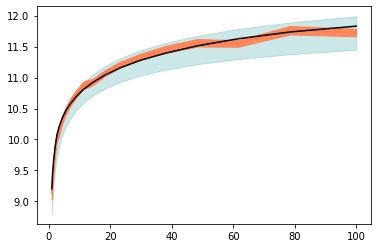

In [134]:
igal = 123
plt.fill_between(R_bins, (dm_prior_profile + dm_prior_profile_std), (dm_prior_profile - dm_prior_profile_std), color = 'darkcyan', alpha = 0.2)
plt.plot(R_bins, y_predicted_from_stellar[igal,:], color = 'coral')
plt.fill_between(R_bins, (y_predicted_from_stellar[igal,:] + y_predicted_from_stellar_std[igal,:]), (y_predicted_from_stellar[igal,:] - y_predicted_from_stellar_std[igal,:]), color = 'coral', alpha = 0.9)
plt.plot(R_bins, np.log10(labels[test_ind[igal],0,:]), c = 'black')

#plt.yscale('log')
#plt.xscale('log')

# Playing with CNNs

In [49]:
# network parameters
input_shape = (nch, npix, npix) # Input shape (#rows, #cols, #channels)
actFunction = 'relu'

# Hidden layers dimensions
intermediate_dim1 = 500
intermediate_dim2 = 400
intermediate_dim3 = 300
intermediate_dim4 = 200
output_dim        = y_trainset.shape[1]

## First let's check that it overfit 1 batch

* It seems to converge to MSE = 0.0451 (without batch normalization nor dropout)

In [33]:
class ConvNet(nn.Module):
    def __init__(self, input_shape, intermediate_dim1, intermediate_dim2, intermediate_dim3, intermediate_dim4, output_dim, actFunction):
        super(ConvNet, self).__init__()
        
        # Cálculo de la cantidad de canales de entrada (esto depende de input_shape)
        self.input_channels = input_shape[0]  # Ejemplo: (3, 64, 64), sería 3 canales de entrada
        
        # Definición de las capas de la red
        self.conv1 = nn.Conv2d(self.input_channels, 5, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(5, 15, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(15, 30, kernel_size=5, stride=1, padding=2)
        
        # Capa de Flatten
        self.flatten = nn.Flatten()
        
        # Capas completamente conectadas (fully connected)
        self.fc1 = nn.Linear(30 * input_shape[1] // 8 * input_shape[2] // 8, intermediate_dim1)  # Tamaño de salida después de 3 MaxPooling
        self.fc2 = nn.Linear(intermediate_dim1, intermediate_dim2)
        self.fc3 = nn.Linear(intermediate_dim2, intermediate_dim3)
        self.fc4 = nn.Linear(intermediate_dim3, intermediate_dim4)
        self.fc5 = nn.Linear(intermediate_dim4, output_dim)
        
        # Función de activación
        self.actFunction = actFunction

    def forward(self, x):
        # Primera capa convolucional
        x = self.conv1(x)
        x = self.actFunction(x)
        x = F.max_pool2d(x, 2)  # MaxPooling (2x2)
        
        # Segunda capa convolucional
        x = self.conv2(x)
        x = self.actFunction(x)
        x = F.max_pool2d(x, 2)  # MaxPooling (2x2)
        
        # Tercera capa convolucional
        x = self.conv3(x)
        x = self.actFunction(x)
        x = F.max_pool2d(x, 2)  # MaxPooling (2x2)
        
        # Aplanamiento
        x = self.flatten(x)
        
        # Capas completamente conectadas
        x = self.actFunction(self.fc1(x))
        x = self.actFunction(self.fc2(x))
        x = self.actFunction(self.fc3(x))
        x = self.fc4(x)  # Capa final antes de la salida (sin activación, o con 'linear' como en el código original)
        x = self.fc5(x)  # Capa de salida
        
        return x
    

actFunction = torch.relu  # Función de activación ReLU

# Crear el modelo
model = ConvNet(input_shape, intermediate_dim1, intermediate_dim2, intermediate_dim3, intermediate_dim4, output_dim, actFunction)

criterion = nn.MSELoss()  # Para un problema de regresión o imagen de salida continua
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Mostrar la estructura del modelo
print(model)

ConvNet(
  (conv1): Conv2d(8, 5, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(5, 15, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(15, 30, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=7680, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=300, bias=True)
  (fc4): Linear(in_features=300, out_features=200, bias=True)
  (fc5): Linear(in_features=200, out_features=20, bias=True)
)


In [35]:
# Crear los DataLoaders para entrenamiento y validación
train_dataset = CustomDataset(x_trainset[:32], y_trainset[:32])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [45]:
data_iter = iter(dataloader)  # Crear un iterador del DataLoader
x_batch, y_batch = next(data_iter) 

In [36]:
num_epochs = 100

train_loss = []
val_loss = []
for epoch in range(num_epochs):
    # Entrenamiento
    model.train()  # Configura el modelo en modo entrenamiento
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        # Zero gradientes
        optimizer.zero_grad()

        # Paso hacia adelante
        outputs = model(inputs)

        # Calcular la pérdida
        loss = criterion(outputs, labels)

        # Paso hacia atrás (backpropagation)
        loss.backward()

        # Actualizar los pesos
        optimizer.step()

        # Sumar la pérdida del lote
        running_train_loss += loss.item()

    # Promedio de la pérdida de entrenamiento
    avg_train_loss = running_train_loss / len(train_loader)
    train_loss.append(avg_train_loss)
    
    # Validación
    model.eval()  # Configura el modelo en modo evaluación
    running_val_loss = 0.0
    with torch.no_grad():  # No calculamos gradientes en validación
        for inputs, labels in train_loader:

            # Paso hacia adelante (sin gradientes)
            outputs = model(inputs)

            # Calcular la pérdida
            loss = criterion(outputs, labels)
            # Sumar la pérdida de validación
            running_val_loss += loss.item()

    # Promedio de la pérdida de validación
    avg_val_loss = running_val_loss / len(val_loader)
    val_loss.append(avg_val_loss)
    
    # Imprimir estadísticas de la época
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Validation Loss: {avg_val_loss:.4f}")

Epoch [1/100], Train Loss: 0.2910, Validation Loss: 0.2665
Epoch [2/100], Train Loss: 0.2665, Validation Loss: 0.2173
Epoch [3/100], Train Loss: 0.2173, Validation Loss: 0.1088
Epoch [4/100], Train Loss: 0.1088, Validation Loss: 0.2105
Epoch [5/100], Train Loss: 0.2105, Validation Loss: 0.0550
Epoch [6/100], Train Loss: 0.0550, Validation Loss: 0.0754
Epoch [7/100], Train Loss: 0.0754, Validation Loss: 0.1011
Epoch [8/100], Train Loss: 0.1011, Validation Loss: 0.1068
Epoch [9/100], Train Loss: 0.1068, Validation Loss: 0.0976
Epoch [10/100], Train Loss: 0.0976, Validation Loss: 0.0804
Epoch [11/100], Train Loss: 0.0804, Validation Loss: 0.0681
Epoch [12/100], Train Loss: 0.0681, Validation Loss: 0.0746
Epoch [13/100], Train Loss: 0.0746, Validation Loss: 0.0765
Epoch [14/100], Train Loss: 0.0765, Validation Loss: 0.0591
Epoch [15/100], Train Loss: 0.0591, Validation Loss: 0.0495
Epoch [16/100], Train Loss: 0.0495, Validation Loss: 0.0514
Epoch [17/100], Train Loss: 0.0514, Validation Lo

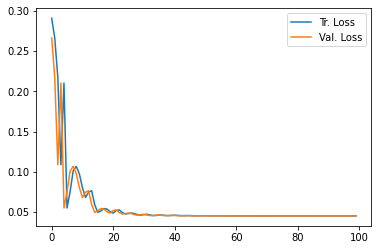

In [37]:
plt.plot(train_loss, label = 'Tr. Loss')
plt.plot(val_loss, label = 'Val. Loss')
plt.legend()

In [38]:
model.eval()  # Asegúrate de que el modelo esté en modo evaluación
y_predicted = []  # Lista para almacenar las predicciones

# Desactivamos el cálculo de gradientes durante la predicción
with torch.no_grad():
    for inputs, _ in train_loader:  # Usamos _ porque no necesitamos las etiquetas en x_testset

        # Hacer predicciones
        outputs = model(inputs)

        # Almacenar las predicciones (por ejemplo, como numpy arrays)
        y_predicted.append(outputs.numpy())  # Si necesitas los resultados como numpy

# Convertir la lista de predicciones en un solo array
y_predicted = np.concatenate(y_predicted, axis=0)

print(y_predicted.shape)  # Esto te dará la forma de las predicciones


(10, 20)


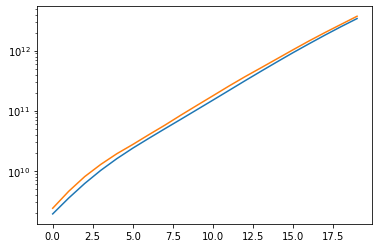

In [39]:
i= 5
plt.plot(10**(y_predicted[i,:] * (max_y - min_y) + min_y))
plt.plot(10**(y_trainset[i,:] * (max_y - min_y) + min_y))
plt.yscale('log')

## Now let's play the real game

Random MSE = 0.12
* 8ch:
    * Seems to converge to MSE = 0.0049 (with dropout but without batch normalization)
    * Seems to converge to MSE = 0.0099 (without dropout but with batch normalization)
    * Seems to converge to MSE = 0.0044 (without dropout nor batch normalization)
    * Seems to converge to MSE = 0.0064 (with dropout and batch normalization)

* 5ch:
    * Seems to converge to MSE =  (with dropout but without batch normalization)
    * Seems to converge to MSE =  (without dropout but with batch normalization)
    * Seems to converge to MSE = 0.0034 (without dropout nor batch normalization)
    * Seems to converge to MSE =  (with dropout and batch normalization)

* 3ch:
    * Seems to converge to MSE =  (with dropout but without batch normalization)
    * Seems to converge to MSE =  (without dropout but with batch normalization)
    * Seems to converge to MSE = 0.0092 (without dropout nor batch normalization)
    * Seems to converge to MSE =  (with dropout and batch normalization)

* SDSS-U:
    * Seems to converge to MSE =  (with dropout but without batch normalization)
    * Seems to converge to MSE =  (without dropout but with batch normalization)
    * Seems to converge to MSE = 0.0148 (without dropout nor batch normalization)
    * Seems to converge to MSE =  (with dropout and batch normalization)

* HI-0:
    * Seems to converge to MSE =  (with dropout but without batch normalization)
    * Seems to converge to MSE =  (without dropout but with batch normalization)
    * Seems to converge to MSE = 0.0089 (without dropout nor batch normalization)
    * Seems to converge to MSE =  (with dropout and batch normalization)

In [50]:
DO = False # If dropout
BN = False # If batch_normalization

class ConvNet(nn.Module):
    def __init__(self, input_shape, intermediate_dim1, intermediate_dim2, intermediate_dim3, intermediate_dim4, output_dim, actFunction):
        super(ConvNet, self).__init__()
        
        # Cálculo de la cantidad de canales de entrada (esto depende de input_shape)
        self.input_channels = input_shape[0]  # Ejemplo: (3, 64, 64), sería 3 canales de entrada
        
        # Definición de las capas de la red
        self.conv1 = nn.Conv2d(self.input_channels, 5, kernel_size=5, stride=1, padding=2)
        if BN: self.bn1 = nn.BatchNorm2d(5)
        self.conv2 = nn.Conv2d(5, 15, kernel_size=5, stride=1, padding=2)
        if BN: self.bn2 = nn.BatchNorm2d(15)
        self.conv3 = nn.Conv2d(15, 30, kernel_size=5, stride=1, padding=2)
        if BN: self.bn3 = nn.BatchNorm2d(30)
        
        # Capa de Flatten
        self.flatten = nn.Flatten()
        
        # Capas completamente conectadas (fully connected)
        self.fc1 = nn.Linear(30 * input_shape[1] // 8 * input_shape[2] // 8, intermediate_dim1)  # Tamaño de salida después de 3 MaxPooling
        if BN: self.bn4 = nn.BatchNorm1d(intermediate_dim1)
        self.fc2 = nn.Linear(intermediate_dim1, intermediate_dim2)
        if BN: self.bn5 = nn.BatchNorm1d(intermediate_dim2)
        self.fc3 = nn.Linear(intermediate_dim2, intermediate_dim3)
        if BN: self.bn6 = nn.BatchNorm1d(intermediate_dim3)
        self.fc4 = nn.Linear(intermediate_dim3, intermediate_dim4)
        self.fc5 = nn.Linear(intermediate_dim4, output_dim)
        
        # Función de activación
        self.actFunction = actFunction

        # Dropout
        if DO: self.dropout_conv = nn.Dropout2d(p=0.2)  # Dropout para capas convolucionales
        if DO: self.dropout_fc = nn.Dropout(p=0.2)  # Dropout para capas completamente conectadas

    def forward(self, x):
        # Primera capa convolucional
        x = self.conv1(x)
        if BN: x = self.bn1(x)
        x = self.actFunction(x)
        if DO: x = self.dropout_conv(x)
        x = F.max_pool2d(x, 2)  # MaxPooling (2x2)
        
        # Segunda capa convolucional
        x = self.conv2(x)
        if BN: x = self.bn2(x) 
        x = self.actFunction(x)
        if DO: x = self.dropout_conv(x)
        x = F.max_pool2d(x, 2)  # MaxPooling (2x2)
        
        # Tercera capa convolucional
        x = self.conv3(x)
        if BN: x = self.bn3(x) 
        x = self.actFunction(x)
        if DO: x = self.dropout_conv(x)
        x = F.max_pool2d(x, 2)  # MaxPooling (2x2)
        
        # Aplanamiento
        x = self.flatten(x)
        
        # Capas completamente conectadas
        x = self.fc1(x)
        if BN: x = self.bn4(x)
        x = self.actFunction(x)
        if DO: x = self.dropout_fc(x)
        
        x = self.fc2(x)
        if BN: x = self.bn5(x)
        x = self.actFunction(x)
        if DO: x = self.dropout_fc(x)
        
        x = self.fc3(x)
        if BN: x = self.bn6(x)
        x = self.actFunction(x)
        if DO: x = self.dropout_fc(x)
        
        x = self.fc4(x)  # Capa final antes de la salida (sin activación, o con 'linear' como en el código original)
        x = self.fc5(x)  # Capa de salida
        
        return x
    

actFunction = torch.relu  # Función de activación ReLU

In [51]:
# Crear los DataLoaders para entrenamiento y validación
train_dataset = CustomDataset(x_trainset, y_trainset)
val_dataset   = CustomDataset(x_valset, y_valset)
test_dataset  = CustomDataset(x_testset, y_testset)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [54]:
name = '8ch_19b'

In [55]:
num_epochs = 100
patience = 10  # Número de épocas a esperar antes de detener el entrenamiento si no hay mejora

niter = 10

train_loss_list = []
val_loss_list = []
for j in range(0,niter): # Uncomment this line for training
    random_indices = np.random.choice(np.arange(len(x_trainset)), replace = True, size = len(x_trainset))
    
    train_dataset = CustomDataset(x_trainset[random_indices], y_trainset[random_indices])
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Crear el modelo
    model = ConvNet(input_shape, intermediate_dim1, intermediate_dim2, intermediate_dim3, intermediate_dim4, output_dim, actFunction)
    model = model.to(device)
    
    criterion = nn.MSELoss()  # Para un problema de regresión o imagen de salida continua
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Mostrar la estructura del modelo
    #print(model)

    best_val_loss = float('inf')  # Inicializar con un valor muy alto
    epochs_without_improvement = 0  # Contador para el early stopping

    # Ruta donde se guardará el mejor modelo
    best_model_path = '../data/models/best_model_' + name + '_' + str(j) + '.pth'

    train_loss = []
    val_loss = []
    for epoch in range(num_epochs):
        # Entrenamiento
        model.train()  # Configura el modelo en modo entrenamiento
        running_train_loss = 0.0
        for inputs, true_vals in train_loader:
            inputs = inputs.to(device)
            true_vals = true_vals.to(device)
            
            # Zero gradientes
            optimizer.zero_grad()

            # Paso hacia adelante
            outputs = model(inputs)

            # Calcular la pérdida
            loss = criterion(outputs, true_vals)

            # Paso hacia atrás (backpropagation)
            loss.backward()

            # Actualizar los pesos
            optimizer.step()

            # Sumar la pérdida del lote
            running_train_loss += loss.item()

        # Promedio de la pérdida de entrenamiento
        avg_train_loss = running_train_loss / len(train_loader)
        train_loss.append(avg_train_loss)

        # Validación
        model.eval()  # Configura el modelo en modo evaluación
        running_val_loss = 0.0
        with torch.no_grad():  # No calculamos gradientes en validación
            for inputs, true_vals in val_loader:
                inputs = inputs.to(device)
                true_vals = true_vals.to(device)

                # Paso hacia adelante (sin gradientes)
                outputs = model(inputs)

                # Calcular la pérdida
                loss = criterion(outputs, true_vals)
                # Sumar la pérdida de validación
                running_val_loss += loss.item()

        # Promedio de la pérdida de validación
        avg_val_loss = running_val_loss / len(val_loader)
        val_loss.append(avg_val_loss)

        if avg_val_loss < best_val_loss:
            print(f'Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...')
            best_val_loss = avg_val_loss
            epochs_without_improvement = 0  # Reiniciar el contador
            # Guardar el mejor modelo
            torch.save(model.state_dict(), best_model_path)
        else:
            epochs_without_improvement += 1
            print(f'Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}')

        # Detener el entrenamiento si no hay mejora en `patience` épocas
        if epochs_without_improvement >= patience:
            print(f'Early stopping after {patience} epochs without improvement.')
            break
        # Imprimir estadísticas de la época
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Validation Loss: {avg_val_loss:.4f}")

    val_loss_list.append(val_loss)
    train_loss_list.append(train_loss)
    plt.plot(train_loss, label = 'Tr. Loss')
    plt.plot(val_loss, label = 'Val. Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('../graphs/Loss_' + name + '_' + str(j) + '.pdf')
    plt.clf()

Validation loss improved from inf to 0.0145. Saving model...
Epoch [1/100], Train Loss: 0.0248, Validation Loss: 0.0145
Validation loss improved from 0.0145 to 0.0095. Saving model...
Epoch [2/100], Train Loss: 0.0139, Validation Loss: 0.0095
Validation loss improved from 0.0095 to 0.0090. Saving model...
Epoch [3/100], Train Loss: 0.0088, Validation Loss: 0.0090
Validation loss improved from 0.0090 to 0.0066. Saving model...
Epoch [4/100], Train Loss: 0.0071, Validation Loss: 0.0066
Validation loss improved from 0.0066 to 0.0063. Saving model...
Epoch [5/100], Train Loss: 0.0064, Validation Loss: 0.0063
Validation loss improved from 0.0063 to 0.0063. Saving model...
Epoch [6/100], Train Loss: 0.0066, Validation Loss: 0.0063
Validation loss improved from 0.0063 to 0.0059. Saving model...
Epoch [7/100], Train Loss: 0.0068, Validation Loss: 0.0059
Validation loss did not improve. Patience: 1/10
Epoch [8/100], Train Loss: 0.0062, Validation Loss: 0.0061
Validation loss improved from 0.005

<Figure size 432x288 with 0 Axes>

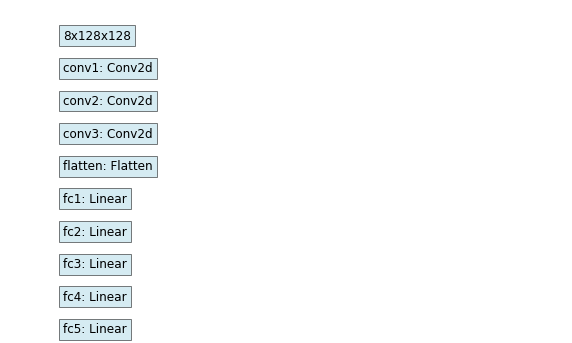

In [88]:
layers = []
for lname, layer in model.named_children():
    layers.append(f"{lname}: {layer.__class__.__name__}")
    

plt.figure(figsize=(10, 6))
plt.text(0.1, 0.9, f'{nch}x{npix}x{npix}', fontsize=12, bbox=dict(facecolor='lightblue', alpha=0.5))

for i in range(len(layers)):
    layer = layers[i]
    plt.text(0.1, 0.9 - (i+1) * 0.1, layer, fontsize=12, bbox=dict(facecolor='lightblue', alpha=0.5))

plt.axis('off')
#plt.title('CNN Architecture', fontsize=16)
plt.savefig('../graphs/Architecture_' + name + '.pdf')

In [53]:
!ls -latr ../data/models/

total 1375156
-rw-rw-r-- 1 martinrios martinrios 16992406 mar 13 14:28 best_model_8ch_BN+DO.pth
-rw-rw-r-- 1 martinrios martinrios 16963822 mar 13 14:52 best_model_8ch_DO.pth
-rw-rw-r-- 1 martinrios martinrios 16992128 mar 13 15:02 best_model_8ch_BN.pth
-rw-rw-r-- 1 martinrios martinrios 16962162 mar 13 15:12 best_model_5ch.pth
-rw-rw-r-- 1 martinrios martinrios 16961138 mar 13 15:23 best_model_3ch.pth
-rw-rw-r-- 1 martinrios martinrios 16960238 mar 13 15:31 best_model_SDSS-U.pth
-rw-rw-r-- 1 martinrios martinrios 16960114 mar 13 15:45 best_model_HI0.pth
-rw-rw-r-- 1 martinrios martinrios 16963634 mar 14 11:25 best_model_8ch.pth
-rw-rw-r-- 1 martinrios martinrios 16963738 mar 14 15:43 best_model_8ch_1.pth
-rw-rw-r-- 1 martinrios martinrios 16963738 mar 14 15:47 best_model_8ch_2.pth
-rw-rw-r-- 1 martinrios martinrios 16963738 mar 14 15:48 best_model_8ch_3.pth
-rw-rw-r-- 1 martinrios martinrios 16963738 mar 14 15:50 best_model_8ch_4.pth
-rw-rw-r-- 1 martinrios martinrios 16963738 mar 14 

In [372]:
# If there were no fit you have to run this cell
model = ConvNet(input_shape, intermediate_dim1, intermediate_dim2, intermediate_dim3, intermediate_dim4, output_dim, actFunction)
criterion = nn.MSELoss()  # Para un problema de regresión o imagen de salida continua
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [373]:
models_names = glob.glob(os.path.join('../data/models/', 'best_model_' + name + '_1.pth' ))

In [374]:
models_names

['../data/models/best_model_8ch_1.pth']

In [58]:
M_pred_list = []
test_loss_list = []
for i in range(10):
    best_model_path = '../data/models/best_model_' + name + '_' + str(i) + '.pth'

    model.load_state_dict(torch.load(best_model_path, weights_only=True))
    model.to(device)
    model.eval()  # Asegúrate de que el modelo esté en modo evaluación
    y_predicted = []  # Lista para almacenar las predicciones

    # Desactivamos el cálculo de gradientes durante la predicción
    with torch.no_grad():
        test_loss = 0
        for inputs, true_vals in test_loader:  # Usamos _ porque no necesitamos las etiquetas en x_testset
            inputs = inputs.to(device)
            true_vals = true_vals.to(device)
            # Hacer predicciones
            outputs = model(inputs)
            test_loss += criterion(outputs, true_vals)
            # Almacenar las predicciones (por ejemplo, como numpy arrays)
            y_predicted.append(outputs.detach().cpu().numpy())  # Si necesitas los resultados como numpy

    test_loss = test_loss / len(test_loader)
    print(f'Test Loss = {test_loss}')  # Esto te dará la forma de las predicciones
    test_loss_list.append(test_loss)

    # Convertir la lista de predicciones en un solo array
    y_predicted = np.concatenate(y_predicted, axis=0)

    print(y_predicted.shape)  # Esto te dará la forma de las predicciones
    print(mean_squared_error(y_predicted, y_testset))

    M_pred = 10**(y_predicted * (max_y - min_y) + min_y)
    M_real = 10**(y_testset * (max_y - min_y) + min_y)

    mass_quantiles = np.percentile((M_pred / M_real), [25, 50, 75], axis=0)
    M_pred_list.append(M_pred)

Test Loss = 0.004937625955790281
(298, 19)
0.005072172953533162
Test Loss = 0.005627715494483709
(298, 19)
0.00569671053676109
Test Loss = 0.004468938801437616
(298, 19)
0.004507275607849687
Test Loss = 0.005730015691369772
(298, 19)
0.0055647315331649036
Test Loss = 0.004024873021990061
(298, 19)
0.004146481637086421
Test Loss = 0.004691680893301964
(298, 19)
0.004757566219079566
Test Loss = 0.005833043716847897
(298, 19)
0.005847934098324266
Test Loss = 0.005548279266804457
(298, 19)
0.005654816760855099
Test Loss = 0.0059819999150931835
(298, 19)
0.005826774403443658
Test Loss = 0.005540464539080858
(298, 19)
0.00562931972222265


In [59]:
name

'8ch_19b'

In [60]:
np.savez('../data/CNNpredictions/mass_predictions_' + name + '.npz', 
         predicted_mass = np.asarray(M_pred_list),
         real_mass = M_real,
         prop_id = test_ind)

In [62]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

M_pred_train_list = []
train_loss_list = []
for i in range(10):
    best_model_path = '../data/models/best_model_' + name + '_' + str(i) + '.pth'

    model.load_state_dict(torch.load(best_model_path, weights_only=True))
    model = model.to(device)
    model.eval()  # Asegúrate de que el modelo esté en modo evaluación
    y_predicted_train = []  # Lista para almacenar las predicciones
    y_real_train = []  # Lista para almacenar las predicciones

    # Desactivamos el cálculo de gradientes durante la predicción
    with torch.no_grad():
        train_loss = 0
        for inputs, true_vals in train_loader:

            inputs = inputs.to(device)
            true_vals = true_vals.to(device)
            # Hacer predicciones
            outputs = model(inputs)

            # Almacenar las predicciones (por ejemplo, como numpy arrays)
            train_loss += criterion(outputs, true_vals)
            y_predicted_train.append(outputs.detach().cpu().numpy())  # Si necesitas los resultados como numpy
            y_real_train.append(true_vals.detach().cpu().numpy())  # Si necesitas los resultados como numpy

    train_loss = train_loss / len(train_loader)
    print(f'Train Loss = {train_loss}')  # Esto te dará la forma de las predicciones
    train_loss_list.append(train_loss)

    # Convertir la lista de predicciones en un solo array
    y_predicted_train = np.concatenate(y_predicted_train, axis=0)
    y_real_train = np.concatenate(y_real_train, axis=0)

    print(y_predicted_train.shape)  # Esto te dará la forma de las predicciones
    print(mean_squared_error(y_predicted_train, y_real_train))
    M_pred_train = 10**(y_predicted_train * (max_y - min_y) + min_y)
    M_real_train = 10**(y_trainset * (max_y - min_y) + min_y)

    #mass_quantiles_train = np.percentile((M_pred_train / M_real_train), [25, 50, 75], axis=0)
    M_pred_train_list.append(M_pred_train)

Train Loss = 0.0037806846667081118
(2080, 19)
0.0037806854
Train Loss = 0.003747291397303343
(2080, 19)
0.0037472912
Train Loss = 0.003507840447127819
(2080, 19)
0.0035078407
Train Loss = 0.004203722812235355
(2080, 19)
0.0042037233
Train Loss = 0.0034598291385918856
(2080, 19)
0.0034598296
Train Loss = 0.004059432540088892
(2080, 19)
0.0040594335
Train Loss = 0.003924830351024866
(2080, 19)
0.0039248304
Train Loss = 0.004022012930363417
(2080, 19)
0.004022012
Train Loss = 0.0044988906010985374
(2080, 19)
0.0044988906
Train Loss = 0.0019476172747090459
(2080, 19)
0.0019476173


In [63]:
y_predicted.shape

(298, 19)

(array([1.585e+03, 3.430e+02, 8.300e+01, 3.600e+01, 1.800e+01, 4.000e+00,
        4.000e+00, 1.000e+00, 2.000e+00, 4.000e+00]),
 array([3.1614982e-04, 4.7141891e-02, 9.3967631e-02, 1.4079338e-01,
        1.8761912e-01, 2.3444486e-01, 2.8127059e-01, 3.2809633e-01,
        3.7492210e-01, 4.2174783e-01, 4.6857357e-01], dtype=float32),
 <BarContainer object of 10 artists>)

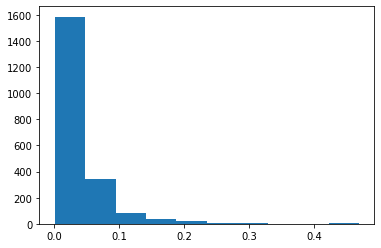

In [66]:
plt.hist(np.sum((y_real_train-y_predicted_train)**2, axis = 1))

In [65]:
np.where(np.sum((y_predicted_train-y_real_train)**2, axis = 1) > 0.6)[0]

array([], dtype=int64)

In [67]:
M_pred_val_list = []
val_loss_list = []
for i in range(10):
    best_model_path = '../data/models/best_model_' + name + '_' + str(i) + '.pth'

    model.load_state_dict(torch.load(best_model_path, weights_only=True))
    model = model.to(device)
    model.eval()  # Asegúrate de que el modelo esté en modo evaluación
    y_predicted_val = []  # Lista para almacenar las predicciones
    y_real_val = []  # Lista para almacenar las predicciones

    # Desactivamos el cálculo de gradientes durante la predicción
    with torch.no_grad():
        val_loss = 0
        for inputs, true_vals in val_loader:

            inputs = inputs.to(device)
            true_vals = true_vals.to(device)

            # Hacer predicciones
            outputs = model(inputs)

            # Almacenar las predicciones (por ejemplo, como numpy arrays)
            val_loss += criterion(outputs, true_vals)
            y_predicted_val.append(outputs.detach().cpu().numpy())  # Si necesitas los resultados como numpy
            y_real_val.append(true_vals.detach().cpu().numpy())  # Si necesitas los resultados como numpy

    val_loss = val_loss / len(val_loader)
    print(f'Val Loss = {val_loss}')  # Esto te dará la forma de las predicciones
    val_loss_list.append(val_loss)

    # Convertir la lista de predicciones en un solo array
    y_predicted_val = np.concatenate(y_predicted_val, axis=0)
    y_real_val = np.concatenate(y_real_val, axis=0)

    print(y_predicted_val.shape)  # Esto te dará la forma de las predicciones
    print(mean_squared_error(y_predicted_val, y_real_val))
    M_pred_val = 10**(y_predicted_val * (max_y - min_y) + min_y)
    M_real_val = 10**(y_valset * (max_y - min_y) + min_y)

    mass_quantiles_val = np.percentile((M_pred_val / M_real_val), [25, 50, 75], axis=0)
    M_pred_val_list.append(M_pred_val)

Val Loss = 0.004431396257132292
(594, 19)
0.0044538663
Val Loss = 0.00534317409619689
(594, 19)
0.0053826845
Val Loss = 0.0042485506273806095
(594, 19)
0.0042511537
Val Loss = 0.0052541447803378105
(594, 19)
0.00530454
Val Loss = 0.00394326401874423
(594, 19)
0.0039446824
Val Loss = 0.004472338128834963
(594, 19)
0.0044750352
Val Loss = 0.005416636820882559
(594, 19)
0.0054520266
Val Loss = 0.004573630169034004
(594, 19)
0.00459251
Val Loss = 0.005135297775268555
(594, 19)
0.0051632547
Val Loss = 0.0052307238802313805
(594, 19)
0.005257123


(array([493.,  68.,  15.,   9.,   3.,   0.,   3.,   1.,   1.,   1.]),
 array([0.00165903, 0.15878865, 0.31591826, 0.47304788, 0.6301775 ,
        0.78730711, 0.94443673, 1.10156634, 1.25869596, 1.41582558,
        1.57295519]),
 <BarContainer object of 10 artists>)

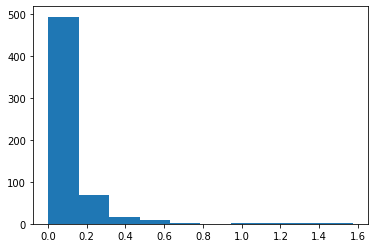

In [68]:
plt.hist(np.sum((y_valset-y_predicted_val)**2, axis = 1))

In [69]:
np.where(np.sum((y_predicted_val-y_real_val)**2, axis = 1) > 0.6)[0]

array([275, 283, 289, 325, 355, 362, 382, 436, 461, 557])

In [71]:
# Estimate of the DM mass by using a perfect knowledge on the stellar mass
#  and the correlation between DM-stellar in each bin

y_predicted_from_stellar = np.zeros((test_size, len(R_bins)))
y_predicted_from_stellar_std = np.zeros((test_size, len(R_bins)))
for i in range(test_size):
    aux = np.log10(labels[test_ind[i],1,:]) + np.random.normal(0, scale = np.mean(np.log10(labels[test_ind,1,:]), axis = 0)/100, size = (len(R_bins),))
    #dm_aux, dm_std = dm_from_stellar(10**aux, num_smass_bins = 10)
    #y_predicted_from_stellar[i,:] = dm_aux
    #y_predicted_from_stellar_std[i,:] = dm_std
    for ii in range(len(R_bins)):
        y_predicted_from_stellar[i,ii] = dm_from_stellar_functions[ii](aux[ii])

        M_stellar = 10**(y_predicted_from_stellar)

In [72]:
# Just a random prediction between min and max in each bin

y_predicted_random = np.random.uniform(0,1, size=(len(y_testset), len(R_bins)))
M_pred_random = 10**(y_predicted_random * (max_y - min_y) + min_y)

In [73]:
if len(M_pred_list) > 1:
    M_pred_list = np.asarray(M_pred_list)
    M_pred = np.mean(M_pred_list, axis = 0)
    M_pred_std = np.std(M_pred_list, axis = 0)
    y_predicted = (np.log10(M_pred) - min_y) / (max_y - min_y)
else:
    M_pred_std = None

Text(0, 0.5, '[M(<R) - m] / (M-m)')

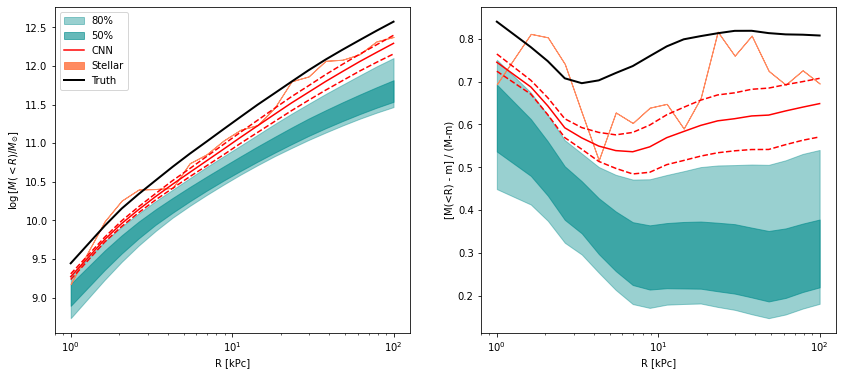

In [74]:
i = 277#np.random.randint(len(y_predicted)) #[ 40, 106, 127, 143, 164, 275, 277]

fig,ax = plt.subplots(1,2, sharex = True, figsize = (14,6))

#ax[0].fill_between(R_bins, max_y, min_y, color = 'darkcyan', alpha = 0.2)
ax[0].fill_between(R_bins, (dm_quantiles[0,:]), (dm_quantiles[3,:]), color = 'darkcyan', alpha = 0.4, label = '80%' )
ax[0].fill_between(R_bins, (dm_quantiles[1,:]), (dm_quantiles[2,:]), color = 'darkcyan', alpha = 0.6, label = '50%' )
#ax[0].fill_between(R_bins, 10**(dm_prior_profile + dm_prior_profile_std), 10**(dm_prior_profile - dm_prior_profile_std), color = 'darkcyan', alpha = 0.2)

ax[0].plot(R_bins, (np.log10(M_pred[i,:])), c = 'red', label = 'CNN')
if M_pred_std is not None:
    ax[0].plot(R_bins, (np.log10(M_pred[i,:] + M_pred_std[i,:])), c = 'red', ls = '--')
    ax[0].plot(R_bins, (np.log10(M_pred[i,:] - M_pred_std[i,:])), c = 'red', ls = '--')

#ax[0].plot(R_bins, 10**y_predicted_from_stellar[i,:], color = 'coral')
ax[0].fill_between(R_bins, ((y_predicted_from_stellar[i,:] + y_predicted_from_stellar_std[i,:])), 
                 ((y_predicted_from_stellar[i,:] - y_predicted_from_stellar_std[i,:])), color = 'coral', alpha = 0.9, label = 'Stellar')

ax[0].plot(R_bins, (np.log10(M_real[i,:])), c = 'black', lw = 2, label = 'Truth')
ax[0].legend()
ax[0].set_xlabel('R [kPc]')
ax[0].set_ylabel('$\log{[M(<R) / M_{\odot}]}$')


#ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlabel('R [kPc]')
ax[1].set_ylabel('[M(<R) - m] / (M-m)')

#ax[1].fill_between(R_bins, max_y, min_y, color = 'darkcyan', alpha = 0.2)
ax[1].fill_between(R_bins, (dm_quantiles[0,:] - min_y) / (max_y - min_y), (dm_quantiles[3,:] - min_y) / (max_y - min_y), color = 'darkcyan', alpha = 0.4, label = '80%' )
ax[1].fill_between(R_bins, (dm_quantiles[1,:] - min_y) / (max_y - min_y), (dm_quantiles[2,:] - min_y) / (max_y - min_y), color = 'darkcyan', alpha = 0.6, label = '50%' )
#ax[1].fill_between(R_bins, 10**(dm_prior_profile + dm_prior_profile_std), 10**(dm_prior_profile - dm_prior_profile_std), color = 'darkcyan', alpha = 0.2)

ax[1].plot(R_bins, (np.log10(M_pred[i,:]) - min_y) / (max_y - min_y), c = 'red', label = 'CNN')
if M_pred_std is not None:
    ax[1].plot(R_bins, (np.log10(M_pred[i,:] + M_pred_std[i,:]) - min_y) / (max_y - min_y), c = 'red', ls = '--')
    ax[1].plot(R_bins, (np.log10(M_pred[i,:] - M_pred_std[i,:]) - min_y) / (max_y - min_y), c = 'red', ls = '--')

#ax[1].plot(R_bins, 10**y_predicted_from_stellar[i,:], color = 'coral')
ax[1].fill_between(R_bins, ((y_predicted_from_stellar[i,:] + y_predicted_from_stellar_std[i,:]) - min_y) / (max_y - min_y), 
                 ((y_predicted_from_stellar[i,:] - y_predicted_from_stellar_std[i,:]) - min_y) / (max_y - min_y), color = 'coral', alpha = 0.9, label = 'Stellar')

ax[1].plot(R_bins, (np.log10(M_real[i,:]) - min_y) / (max_y - min_y), c = 'black', lw =2)

#ax[1].yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlabel('R [kPc]')
ax[1].set_ylabel('[M(<R) - m] / (M-m)')

#plt.savefig('../graphs/DMfromStellar_' + str(properties[test_ind[i],0]) + '_' + name + '.pdf')

Text(0.5, 0.0, '$\\kappa$')

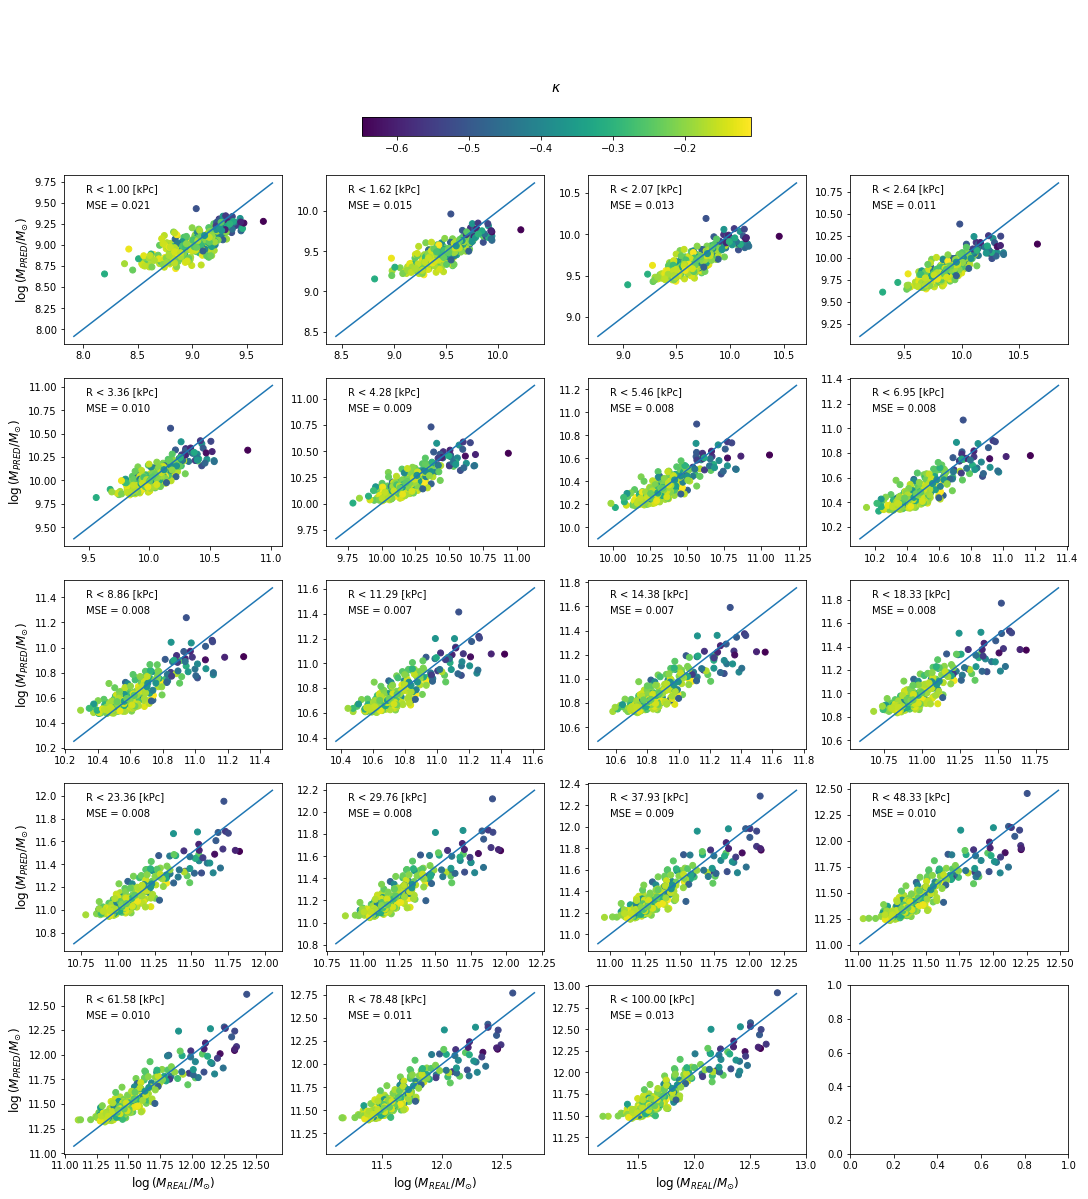

In [77]:
fig, ax = plt.subplots(5,4, figsize = (18,18))

for i in range(5):
    for j in range(4):
        if (i*4+j) < len(R_bins):
            s = ax[i,j].scatter(np.log10(M_real[:,i*4+j]), np.log10(M_pred[:,i*4+j]), c = np.log10(properties[test_ind,15]), cmap = 'viridis', 
                                vmin = np.log10(properties[test_ind,15]).min(), vmax = np.log10(properties[test_ind,15]).max())
            ax[i,j].plot([min_y[i*4+j], max_y[i*4+j]], [min_y[i*4+j], max_y[i*4+j]])

            if i == 4: ax[i,j].set_xlabel('$\log{(M_{REAL} / M_{\odot})}$', fontsize = 12)
            if j == 0: ax[i,j].set_ylabel('$\log{(M_{PRED} / M_{\odot})}$', fontsize = 12)

            ax[i,j].text(0.1,0.8,'MSE = {:.3f}'.format(mean_squared_error(np.log10(M_real[:,i*4+j]), np.log10(M_pred[:,i*4+j]))), transform = ax[i,j].transAxes)
            ax[i,j].text(0.1,0.9,'R < {:.2f} [kPc]'.format(R_bins[i*4+j]), transform = ax[i,j].transAxes)

cbar_ax = fig.add_axes([0.1, 0.91, 0.81, 0.1])
cbar_ax.axis('off')
plt.colorbar(s, ax = cbar_ax, orientation = 'horizontal')
cbar_ax.set_title('$\\kappa$', y = 0., fontsize = 14)
#plt.savefig('../graphs/RealVSPred_' + name + '_kappa.pdf')

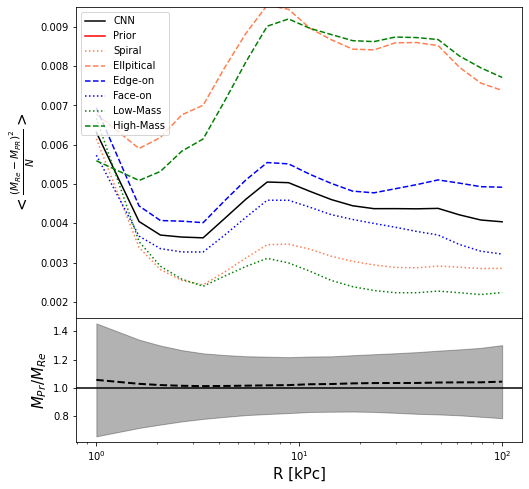

In [78]:
fig,ax = plt.subplots(2,1, figsize = (8,8), gridspec_kw={'height_ratios':[2.5, 1], 'hspace':0}, sharex = True)

mse = (mean_squared_error(y_testset, y_predicted, multioutput = 'raw_values')) # np.sqrt(np.sum((y_testset - y_predicted)**2, axis = 0) / len(y_testset))
std = np.std(((y_testset - y_predicted)**2), axis = 0)
mse_prior = (mean_squared_error(y_testset, y_prior, multioutput = 'raw_values'))

#for i in range(test_size):
#    ax[0].plot(R_bins, np.abs(y_testset[i,:] - y_predicted[i,:]), alpha = 0.2, c = 'black')

ax[0].plot(R_bins, mse, color = 'black', label = 'CNN')
#ax[0].plot(R_bins, mse_random, color = 'coral', label = 'Random')
#ax[0].fill_between(R_bins, mse + std, mse - std, color = 'coral', alpha = 0.3)

ax[0].plot(R_bins, mse_prior, color = 'red', label = 'Prior')
#ax[0].plot(arqB_8ch[:,0], arqB_8ch[:,1], color = 'red', label = 'Arch. B')

# Kappa splitting
ind_aux = np.where(properties[test_ind, 15] > 0.5)[0]
mse_aux = (mean_squared_error(y_testset[ind_aux], y_predicted[ind_aux], multioutput = 'raw_values')) # np.sqrt(np.sum((y_testset - y_predicted)**2, axis = 0) / len(y_testset))
std_aux = (np.std((y_testset[ind_aux] - y_predicted[ind_aux])**2, axis = 0))
ax[0].plot(R_bins, mse_aux, color = 'coral', ls = ':', label = 'Spiral')

ind_aux = np.where(properties[test_ind, 15] < 0.5)[0]
mse_aux = (mean_squared_error(y_testset[ind_aux], y_predicted[ind_aux], multioutput = 'raw_values')) # np.sqrt(np.sum((y_testset - y_predicted)**2, axis = 0) / len(y_testset))
std_aux = (np.std((y_testset[ind_aux] - y_predicted[ind_aux])**2, axis = 0))
ax[0].plot(R_bins, mse_aux, color = 'coral', ls = '--', label = 'Ellpitical')
# ------------------------------------

# Theta splitting
ind_aux = np.where( (properties[test_ind, 18] > (np.pi/4)) & (properties[test_ind, 18] < (3*np.pi/4)))[0]
mse_aux = (mean_squared_error(y_testset[ind_aux], y_predicted[ind_aux], multioutput = 'raw_values')) # np.sqrt(np.sum((y_testset - y_predicted)**2, axis = 0) / len(y_testset))
std_aux = (np.std((y_testset[ind_aux] - y_predicted[ind_aux])**2, axis = 0))
ax[0].plot(R_bins, mse_aux, color = 'blue', ls = '--', label = 'Edge-on')

ind_aux = np.where( (properties[test_ind, 18] < (np.pi/4)) | (properties[test_ind, 18] > (3*np.pi/4)))[0]
mse_aux = (mean_squared_error(y_testset[ind_aux], y_predicted[ind_aux], multioutput = 'raw_values')) # np.sqrt(np.sum((y_testset - y_predicted)**2, axis = 0) / len(y_testset))
std_aux = (np.std((y_testset[ind_aux] - y_predicted[ind_aux])**2, axis = 0))
ax[0].plot(R_bins, mse_aux, color = 'blue', ls = ':', label = 'Face-on')
# --------------------------------


# Mass splitting
ind_aux = np.where(np.log10(properties[test_ind, 2]) < np.log10(properties[test_ind,2]).mean())[0]
mse_aux = (mean_squared_error(y_testset[ind_aux], y_predicted[ind_aux], multioutput = 'raw_values')) # np.sqrt(np.sum((y_testset - y_predicted)**2, axis = 0) / len(y_testset))
std_aux = (np.std((y_testset[ind_aux] - y_predicted[ind_aux])**2, axis = 0))
ax[0].plot(R_bins, mse_aux, color = 'green', ls = ':', label = 'Low-Mass')

ind_aux = np.where(np.log10(properties[test_ind, 2]) > np.log10(properties[test_ind,2]).mean())[0]
mse_aux = (mean_squared_error(y_testset[ind_aux], y_predicted[ind_aux], multioutput = 'raw_values')) # np.sqrt(np.sum((y_testset - y_predicted)**2, axis = 0) / len(y_testset))
std_aux = (np.std((y_testset[ind_aux] - y_predicted[ind_aux])**2, axis = 0))
ax[0].plot(R_bins, mse_aux, color = 'green', ls = '--', label = 'High-Mass')
# --------------------------------

ax[0].set_ylabel('$ <\\frac{(M_{Re} - M_{PR})^2}{N}> $', fontsize = 15)
#ax[0].set_xlabel('R [kPc]')
ax[0].set_xscale('log')
ax[0].legend()

mean_mass_ratio = np.mean(M_pred / M_real, axis = 0)
std_mass_ratio = np.std(M_pred / M_real, axis = 0)
mean_mass_ratio_random = np.mean(M_pred_random / M_real, axis = 0)
std_mass_ratio_random = np.std(M_pred_random / M_real, axis = 0)

#for i in range(test_size):
    #ax[1].plot(R_bins, M_pred[i,:] / M_real[i,:], color = 'black', alpha = 0.05)
ax[1].axhline(y = 1, color = 'black')
ax[1].plot(R_bins, mean_mass_ratio, color = 'black', lw = 2, ls = '--')
ax[1].fill_between(R_bins, mean_mass_ratio + std_mass_ratio, mean_mass_ratio - std_mass_ratio, color = 'black', alpha = 0.3)

#ax[1].fill_between(R_bins, mean_mass_ratio_random + std_mass_ratio_random, mean_mass_ratio_random - std_mass_ratio_random, color = 'red', alpha = 0.3)

#ax[1].plot(R_bins, mass_quantiles[2,:], color = 'black', lw = 2, ls = '--')

ax[1].set_xlabel('R [kPc]', fontsize = 15)
ax[1].set_ylabel('$M_{Pr} / M_{Re}$', fontsize = 15)

ax[0].set_ylim(0.0016,0.0095)
plt.savefig('../graphs/MSE_' + name + '.pdf')

In [79]:
#quantiles = np.percentile((y_testset - y_predicted)**2, [25, 50, 75], axis=0)
quantiles = np.percentile((np.log10(M_real) - np.log10(M_pred))**2, [25, 50, 75], axis=0)

In [80]:
ecnn_y_pred = (np.log10(ecnn_pred) - min_y) / (max_y - min_y)
ecnn_y_pred = np.mean(ecnn_y_pred, axis = 0)
M_ecnn = np.mean(ecnn_pred, axis = 0)

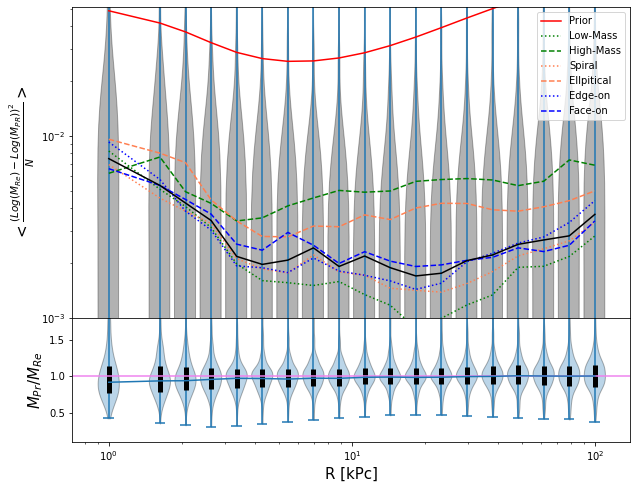

In [81]:
fig,ax = plt.subplots(2,1, figsize = (10,8), gridspec_kw={'height_ratios':[2.5, 1], 'hspace':0}, sharex = True)

#parts = ax[0].violinplot((y_testset - y_predicted)**2, positions=R_bins, widths=R_bins*0.2, showmedians = True)
parts = ax[0].violinplot((np.log10(M_real) - np.log10(M_pred))**2, positions=R_bins, widths=R_bins*0.2, showmedians = False)
for pc in parts['bodies']:  
    pc.set_facecolor('black')  # Color azul  
    pc.set_edgecolor('black')
    pc.set_alpha(0.3) 
    
ax[0].plot(R_bins, quantiles[1,:], zorder=4, color = 'black')
#ax[0].plot(R_bins, mean_squared_error(np.log10(M_real), np.log10(M_pred), multioutput = 'raw_values'), color = 'coral', label = 'CNN')
#%ax[0].plot(R_bins, mse**2, color = 'coral', label = 'New')

#ax[0].vlines(R_bins, quantiles[0,:], quantiles[2,:], color='k', linestyle='-', lw=5)
#ax[0].plot(R_bins, np.sqrt(quantiles[0,:]), color = '#1f77b4' , zorder=4)
#ax[0].plot(R_bins, np.sqrt(quantiles[2,:]), color = '#1f77b4' , zorder=4)
#ax[0].set_xscale('log')
#ax[0].set_yscale('log')
#ax[0].plot(R_bins, mse/mse_prior, color = 'red')
#%ax[0].plot(R_bins, mse_prior**2, color = 'red', label = 'Prior')
ax[0].plot(R_bins, mean_squared_error(np.log10(M_real), np.log10(M_prior), multioutput = 'raw_values'), color = 'red', label = 'Prior')
#ax[0].fill_between(R_bins, mse + std, mse - std, color = 'red', alpha = 0.3)
#ax[0].set_ylim(0,0.03)
#ax[0].plot(arqB_8ch[:,0], arqB_8ch[:,1], color = 'red')
ax[0].set_ylabel('$<\\frac{(Log(M_{Re}) - Log(M_{PR}))^2}{N}>$', fontsize = 15)

parts1 = ax[1].violinplot((M_pred / M_real), positions=R_bins, widths=R_bins*0.2)
for pc in parts1['bodies']:  
    pc.set_facecolor('#1f77b4')  # Color azul  
    pc.set_edgecolor('black')
    pc.set_alpha(0.3) 
    
ax[1].plot(R_bins, mass_quantiles[1,:], color = '#1f77b4' , zorder=4)
ax[1].vlines(R_bins, mass_quantiles[0,:], mass_quantiles[2,:], color='k', linestyle='-', lw=5)
ax[1].set_ylim(0,2)
ax[1].set_xlabel('R [kPc]', fontsize = 15)
ax[1].set_ylabel('$M_{Pr} / M_{Re}$', fontsize = 15)

# Mass splitting
ind_aux = np.where(np.log10(properties[test_ind, 2]) < np.log10(properties[test_ind,2]).mean())[0]
mse_aux = np.percentile((np.log10(M_real[ind_aux]) - np.log10(M_pred[ind_aux]))**2, [50], axis=0)[0]
ax[0].plot(R_bins, mse_aux, color = 'green', ls = ':', label = 'Low-Mass')

ind_aux = np.where(np.log10(properties[test_ind, 2]) > np.log10(properties[test_ind,2]).mean())[0]
mse_aux = np.percentile((np.log10(M_real[ind_aux]) - np.log10(M_pred[ind_aux]))**2, [50], axis=0)[0]
ax[0].plot(R_bins, mse_aux, color = 'green', ls = '--', label = 'High-Mass')
# --------------------------------

# Kappa splitting
ind_aux = np.where(properties[test_ind, 15] > 0.5)[0]
mse_aux = np.percentile((np.log10(M_real[ind_aux]) - np.log10(M_pred[ind_aux]))**2, [50], axis=0)[0]
ax[0].plot(R_bins, mse_aux, color = 'coral', ls = ':', label = 'Spiral')

ind_aux = np.where(properties[test_ind, 15] < 0.5)[0]
mse_aux = np.percentile((np.log10(M_real[ind_aux]) - np.log10(M_pred[ind_aux]))**2, [50], axis=0)[0]
ax[0].plot(R_bins, mse_aux, color = 'coral', ls = '--', label = 'Ellpitical')
# ------------------------------------

# Theta splitting
ind_aux = np.where( (properties[test_ind, 18] > (np.pi/4)) & (properties[test_ind, 18] < (3*np.pi/4)))[0]
mse_aux = np.percentile((np.log10(M_real[ind_aux]) - np.log10(M_pred[ind_aux]))**2, [50], axis=0)[0]
ax[0].plot(R_bins, mse_aux, color = 'blue', ls = ':', label = 'Edge-on')

ind_aux = np.where( (properties[test_ind, 18] < (np.pi/4)) | (properties[test_ind, 18] > (3*np.pi/4)))[0]
mse_aux = np.percentile((np.log10(M_real[ind_aux]) - np.log10(M_pred[ind_aux]))**2, [50], axis=0)[0]
ax[0].plot(R_bins, mse_aux, color = 'blue', ls = '--', label = 'Face-on')
# --------------------------------

ax[1].axhline(y = 1, color = 'violet')

ax[0].legend()
ax[0].set_ylim(0.001,0.051)
ax[1].set_ylim(0.1,1.8)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
plt.savefig('../graphs/MSE_v2_' + name + '.pdf')

In [82]:

r_norm = np.zeros_like(y_predicted)
for i in range(len(test_ind)):
    r_norm[i,:] = R_bins 

#bins, bin_centers, mse, std, p_results = binned_MSE_q(r_norm, (np.log10(M_real) - np.log10(M_ecnn))**2, quantiles = [10,16,30,40,50,60,70,84,90], bins = R_bins)


In [83]:
y_ecnn = (np.log10(M_ecnn)-min_y) / (max_y - min_y)

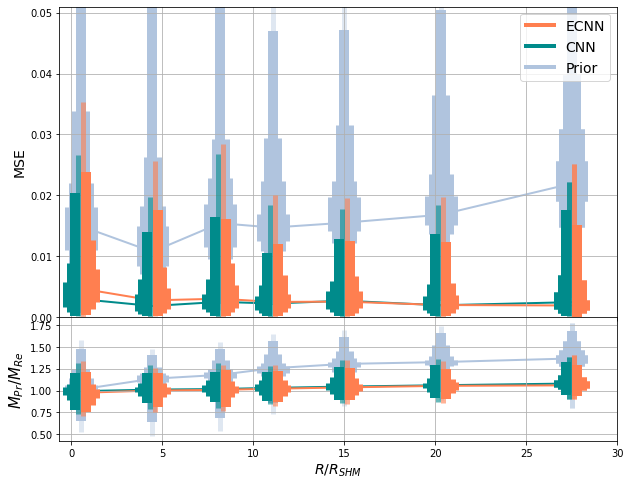

In [84]:
col_cnn = 'darkcyan'
col_ecnn = 'coral'
col_prior = 'lightsteelblue'
bins2plot = [5,12,14,15,16,17,18,18]

aux_prior = M_prior#np.delete(M_prior, [ 40, 106, 127, 143, 164, 275, 277], axis = 0)
aux_pred = M_pred#np.delete(M_pred, [ 40, 106, 127, 143, 164, 275, 277], axis = 0)
aux_real = M_real#np.delete(M_real, [ 40, 106, 127, 143, 164, 275, 277], axis = 0)
aux_ecnn = M_ecnn#np.delete(M_ecnn, [ 40, 106, 127, 143, 164, 275, 277], axis = 0)
aux_ind = test_ind#np.delete(test_ind, [ 40, 106, 127, 143, 164, 275, 277], axis = 0)

r_norm = np.zeros_like(aux_pred)
for i in range(len(aux_ind)):
    r_norm[i,:] = R_bins / properties[aux_ind[i], 13]

   
fig, ax = plt.subplots(2,1, figsize = (10,8), gridspec_kw={'height_ratios':[2.5, 1], 'hspace':0}, sharex = True)

bins, bin_centers, mse, std, p_results = binned_MSE_q(r_norm, (np.log10(aux_real) - np.log10(aux_pred))**2, quantiles = [10,16,30,40,50,60,70,84,90])
ax[0].plot(bin_centers[bins2plot], p_results['50'][bins2plot], color = col_cnn, label = 'Median', lw = 2, zorder = 0)
ax[0].vlines(bin_centers[bins2plot] - 0.3, p_results['16'][bins2plot],p_results['84'][bins2plot], color = col_cnn, lw = 10)
ax[0].vlines(bin_centers[bins2plot] - 0.14, p_results['10'][bins2plot],p_results['90'][bins2plot], color = col_cnn, lw = 5, alpha = 0.6)
ax[0].vlines(bin_centers[bins2plot] - 0.66, p_results['30'][bins2plot],p_results['70'][bins2plot], color = col_cnn, lw = 5, alpha = 1)
ax[0].vlines(bin_centers[bins2plot] - 0.86, p_results['40'][bins2plot],p_results['60'][bins2plot], color = col_cnn, lw = 5, alpha = 1)

_, _, mse, std, p_results = binned_MSE_q(r_norm, (np.log10(aux_real) - np.log10(aux_ecnn))**2, quantiles = [10,16,30,40,50,60,70,84,90], bins = bins)
ax[0].plot(bin_centers[bins2plot], p_results['50'][bins2plot], color = col_ecnn, label = 'Median', lw = 2, zorder = 0)
ax[0].vlines(bin_centers[bins2plot] + 0.3, p_results['16'][bins2plot],p_results['84'][bins2plot], color = col_ecnn, lw = 10)
ax[0].vlines(bin_centers[bins2plot] + 0.14 , p_results['10'][bins2plot],p_results['90'][bins2plot], color = col_ecnn, lw = 5, alpha = 0.6)
ax[0].vlines(bin_centers[bins2plot] + 0.66, p_results['30'][bins2plot],p_results['70'][bins2plot], color = col_ecnn, lw = 5, alpha = 1)
ax[0].vlines(bin_centers[bins2plot] + 0.86, p_results['40'][bins2plot],p_results['60'][bins2plot], color = col_ecnn, lw = 5, alpha = 1)

_, _, mse, std, p_results = binned_MSE_q(r_norm, (np.log10(aux_real) - np.log10(aux_prior))**2, quantiles = [10,16,30,40,45,50,55,60,70,84,90], bins = bins)
ax[0].plot(bin_centers[bins2plot], p_results['50'][bins2plot], color = col_prior, label = 'Median', lw = 2, zorder = 0)
ax[0].vlines(bin_centers[bins2plot], p_results['16'][bins2plot],p_results['84'][bins2plot], color = col_prior, lw = 10, zorder = 0)
ax[0].vlines(bin_centers[bins2plot] , p_results['10'][bins2plot],p_results['90'][bins2plot], color = col_prior, lw = 5, alpha = 0.4, zorder = 0)
ax[0].vlines(bin_centers[bins2plot] + 0.36, p_results['30'][bins2plot],p_results['70'][bins2plot], color = col_prior, lw = 5, alpha = 1,zorder=0)
ax[0].vlines(bin_centers[bins2plot] + 0.56, p_results['40'][bins2plot],p_results['60'][bins2plot], color = col_prior, lw = 5, alpha = 1,zorder=0)
ax[0].vlines(bin_centers[bins2plot] - 0.36, p_results['30'][bins2plot],p_results['70'][bins2plot], color = col_prior, lw = 5, alpha = 1,zorder=0)
ax[0].vlines(bin_centers[bins2plot] - 0.56, p_results['40'][bins2plot],p_results['60'][bins2plot], color = col_prior, lw = 5, alpha = 1,zorder=0)
ax[0].vlines(bin_centers[bins2plot] + 0.76, p_results['45'][bins2plot],p_results['55'][bins2plot], color = col_prior, lw = 5, alpha = 1,zorder=0)
ax[0].vlines(bin_centers[bins2plot] - 0.76, p_results['45'][bins2plot],p_results['55'][bins2plot], color = col_prior, lw = 5, alpha = 1,zorder=0)

ax[0].set_xlim(-0.65,30)
ax[0].set_ylim(-0.0,0.051)
ax[0].set_ylabel('MSE', fontsize = 14)

_, _, mse, std, p_results = binned_MSE_q(r_norm, (aux_pred / aux_real), quantiles = [10,16,30,40,50,60,70,84,90], bins = bins)
ax[1].plot(bin_centers[bins2plot], p_results['50'][bins2plot], color = col_cnn, label = 'Median', lw = 2, zorder = 0)
ax[1].vlines(bin_centers[bins2plot] - 0.3, p_results['16'][bins2plot],p_results['84'][bins2plot], color = col_cnn, lw = 10)
ax[1].vlines(bin_centers[bins2plot] - 0.14, p_results['10'][bins2plot],p_results['90'][bins2plot], color = col_cnn, lw = 5, alpha = 0.6)
ax[1].vlines(bin_centers[bins2plot] - 0.66, p_results['30'][bins2plot],p_results['70'][bins2plot], color = col_cnn, lw = 5, alpha = 1)
ax[1].vlines(bin_centers[bins2plot] - 0.86, p_results['40'][bins2plot],p_results['60'][bins2plot], color = col_cnn, lw = 5, alpha = 1)

_, _, mse, std, p_results = binned_MSE_q(r_norm, (aux_ecnn / aux_real), quantiles = [10,16,30,40,50,60,70,84,90], bins = bins)
ax[1].plot(bin_centers[bins2plot], p_results['50'][bins2plot], color = col_ecnn, label = 'Median', lw = 2, zorder = 0)
ax[1].vlines(bin_centers[bins2plot] + 0.3, p_results['16'][bins2plot],p_results['84'][bins2plot], color = col_ecnn, lw = 10)
ax[1].vlines(bin_centers[bins2plot] + 0.14 , p_results['10'][bins2plot],p_results['90'][bins2plot], color = col_ecnn, lw = 5, alpha = 0.6)
ax[1].vlines(bin_centers[bins2plot] + 0.66, p_results['30'][bins2plot],p_results['70'][bins2plot], color = col_ecnn, lw = 5, alpha = 1)
ax[1].vlines(bin_centers[bins2plot] + 0.86, p_results['40'][bins2plot],p_results['60'][bins2plot], color = col_ecnn, lw = 5, alpha = 1)

_, _, mse, std, p_results = binned_MSE_q(r_norm, (aux_prior / aux_real), quantiles = [10,16,30,40,45,50,55,60,70,84,90], bins = bins)
ax[1].plot(bin_centers[bins2plot], p_results['50'][bins2plot], color = col_prior, label = 'Median', lw = 2, zorder = 0)
ax[1].vlines(bin_centers[bins2plot], p_results['16'][bins2plot],p_results['84'][bins2plot], color = col_prior, lw = 10, zorder = 0)
ax[1].vlines(bin_centers[bins2plot] , p_results['10'][bins2plot],p_results['90'][bins2plot], color = col_prior, lw = 5, alpha = 0.4, zorder = 0)
ax[1].vlines(bin_centers[bins2plot] + 0.36, p_results['30'][bins2plot],p_results['70'][bins2plot], color = col_prior, lw = 5, alpha = 1,zorder=0)
ax[1].vlines(bin_centers[bins2plot] + 0.56, p_results['40'][bins2plot],p_results['60'][bins2plot], color = col_prior, lw = 5, alpha = 1,zorder=0)
ax[1].vlines(bin_centers[bins2plot] - 0.36, p_results['30'][bins2plot],p_results['70'][bins2plot], color = col_prior, lw = 5, alpha = 1,zorder=0)
ax[1].vlines(bin_centers[bins2plot] - 0.56, p_results['40'][bins2plot],p_results['60'][bins2plot], color = col_prior, lw = 5, alpha = 1,zorder=0)
ax[1].vlines(bin_centers[bins2plot] + 0.76, p_results['45'][bins2plot],p_results['55'][bins2plot], color = col_prior, lw = 5, alpha = 1,zorder=0)
ax[1].vlines(bin_centers[bins2plot] - 0.76, p_results['45'][bins2plot],p_results['55'][bins2plot], color = col_prior, lw = 5, alpha = 1,zorder=0)

#_, _, mse, std, p10, p16, p50, p84, p90 = binned_MSE(r_norm, (M_stellar / M_real), bins = bins)
#ax[1].vlines(bin_centers[bins2plot] + 0.72, p16[bins2plot],p84[bins2plot], color = 'magenta', lw = 10, zorder = 0)
#ax[1].vlines(bin_centers[bins2plot] + 0.72 , p10[bins2plot],p90[bins2plot], color = 'magenta', lw = 5, alpha = 0.4, zorder = 0)

ax[1].set_xlabel('$R / R_{SHM}$', fontsize = 14)
ax[1].set_ylabel('$M_{Pr} / M_{Re}$', fontsize = 15)

ax[0].grid(which = 'both')
ax[1].grid(which = 'both')

line1 = Line2D([], [], color=col_ecnn, linestyle='solid', linewidth=4, label='ECNN')
line2 = Line2D([], [], color=col_cnn, linestyle='solid', linewidth=4, label='CNN')
line3 = Line2D([], [], color=col_prior, linestyle='solid', linewidth=4, label='Prior')
#line4 = Line2D([], [], color='magenta', linestyle='solid', linewidth=4, label='Stellar')

# Agregar la leyenda personalizada
ax[0].legend(handles=[line1, line2, line3], loc='upper right', fontsize = 14)

#plt.savefig('../graphs/MSEComparison_' + name + '_ecnn10.pdf')

Text(0, 0.5, '$Log(M_{Pr}) / Log(M_{Re})$')

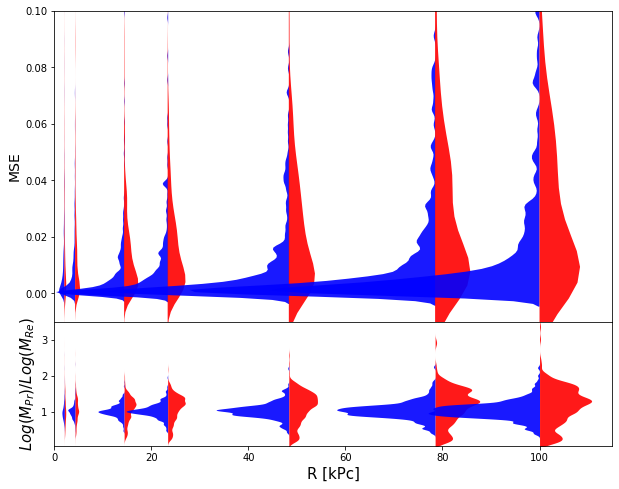

In [85]:
bins2plot = [2,5,10,12,15,17,18]
fig,ax = plt.subplots(2,1, figsize = (10,8), gridspec_kw={'height_ratios':[2.5, 1], 'hspace':0}, sharex = True)

ax[0] = SplitViolin(ax[0],(np.log10(M_real[:,bins2plot]) - np.log10(M_pred[:,bins2plot]))**2, 
                    (np.log10(M_real[:,bins2plot]) - np.log10(M_prior[:,bins2plot]))**2,
                    R_bins[bins2plot], scale = 190, bw_adjust = 0.2)

ax[0].set_xlim(0,115)
ax[0].set_ylim(-0.01,0.1)
ax[0].set_ylabel('MSE', fontsize = 14)

#cax = ax[0].inset_axes([0.08,0.6,0.8,0.4])

#cax = SplitViolin(cax,(np.log10(M_real[:,:10]) - np.log10(M_pred[:,:10]))**2, (np.log10(M_real[:,:10]) - np.log10(M_prior[:,:10]))**2, R_bins[:10])

#cax.set_xlim(0,10)
#cax.set_ylim(-0.01,0.2)

ax[1] = SplitViolin(ax[1],(M_pred[:,bins2plot] / M_real[:,bins2plot]), (M_prior[:,bins2plot] / M_real[:,bins2plot]),
                    R_bins[bins2plot], scale = 8)

ax[1].set_xlim(0,115)
ax[1].set_ylim(0.05,3.5)

#cax = ax[1].inset_axes([0.08,0.6,0.8,0.4])

#cax = SplitViolin(cax,(M_pred[:,:10] / M_real[:,:10]), (M_prior[:,:10] / M_real[:,:10]), R_bins[:10], scale = 15)

#cax.set_xlim(0,10)
#cax.set_ylim(0.05,1.5)
ax[1].set_xlabel('R [kPc]', fontsize = 15)
ax[1].set_ylabel('$Log(M_{Pr}) / Log(M_{Re})$', fontsize = 15)

Text(0, 0.5, '$Log(M_{Pr}) / Log(M_{Re})$')

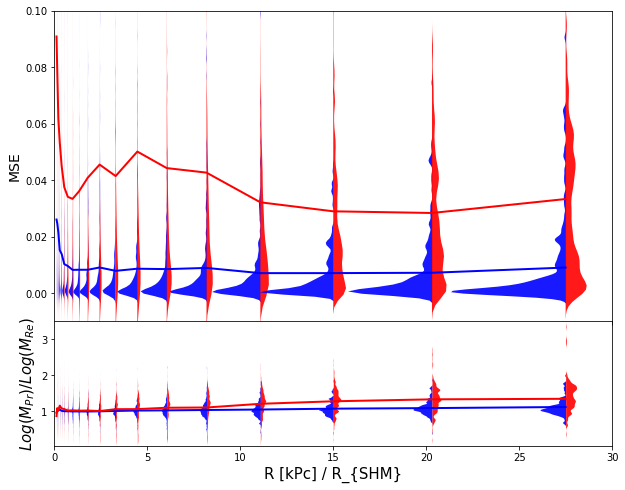

In [86]:
bins2plot = [2,5,10,12,15,17,18]
r_norm = np.zeros_like(y_predicted)
for i in range(len(test_ind)):
    r_norm[i,:] = R_bins / properties[test_ind[i], 13]
    
fig,ax = plt.subplots(2,1, figsize = (10,8), gridspec_kw={'height_ratios':[2.5, 1], 'hspace':0}, sharex = True)

bins, bin_centers, mse, std, p10, p16, p50, p84, p90 = binned_MSE(r_norm, (np.log10(M_real) - np.log10(M_pred))**2)

ax[0] = SplitViolin(ax[0],(np.log10(M_real) - np.log10(M_pred))**2, 
                    (np.log10(M_real) - np.log10(M_prior))**2,
                    R_bins, scale = 690, r_norm=r_norm, r_bins=bin_centers, bw_adjust = 0.2)

ax[0].plot(bin_centers, mse, color = 'blue', label = 'Mean', lw = 2)

bins, bin_centers, mse, std, p10, p16, p50, p84, p90 = binned_MSE(r_norm, (np.log10(M_real) - np.log10(M_prior))**2)
ax[0].plot(bin_centers, mse, color = 'red', label = 'Mean', lw = 2)

ax[0].set_xlim(0,41)
ax[0].set_ylim(-0.01,0.1)
ax[0].set_ylabel('MSE', fontsize = 14)

_, _, mse, std, p10, p16, p50, p84, p90 = binned_MSE(r_norm, (M_pred / M_real), bins = bins)
ax[1].plot(bin_centers, mse, color = 'blue', label = 'Mean', lw = 2)

ax[1] = SplitViolin(ax[1],(M_pred / M_real), (M_prior / M_real),
                    R_bins, scale = 58, r_norm=r_norm, r_bins=bin_centers, bw_adjust = 0.3)

_, _, mse, std, p10, p16, p50, p84, p90 = binned_MSE(r_norm, (M_prior / M_real), bins = bins)
ax[1].plot(bin_centers, mse, color = 'red', label = 'Mean', lw = 2)

ax[1].set_xlim(0,30)
ax[1].set_ylim(0.05,3.5)
ax[1].set_xlabel('R [kPc] / R_{SHM}', fontsize = 15)
ax[1].set_ylabel('$Log(M_{Pr}) / Log(M_{Re})$', fontsize = 15)

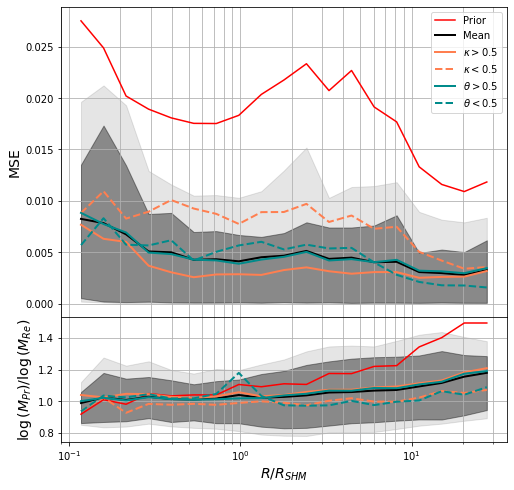

In [87]:
y_stellar = (y_predicted_from_stellar - min_y) / (max_y - min_y)
#y_stellar1 = (y_predicted_from_stellar1 - min_y) / (max_y - min_y)
r = np.zeros_like(y_predicted)
for i in range(len(test_ind)):
    r[i,:] = R_bins / properties[test_ind[i], 13]

fig,ax = plt.subplots(2,1, figsize = (8,8), gridspec_kw={'height_ratios':[2.5, 1], 'hspace':0}, sharex = True)


bins, bin_centers, mse, std, p10, p16, p50, p84, p90 = binned_MSE(r, (y_predicted - y_testset)**2)
_, _, mse_stellar, std_stellar, p10_stellar, p16_stellar, p50_stellar, p84_stellar, p90_stellar = binned_MSE(r, (y_stellar - y_testset)**2, bins = bins)
_, _, mse_prior, _, _, _, _, _, _ = binned_MSE(r, (y_prior - y_testset)**2, bins = bins)

ax[0].plot(bin_centers, mse_prior, color = 'red', label = 'Prior')

ax[0].plot(bin_centers, mse, color = 'black', label = 'Mean', lw = 2)
ax[0].fill_between(bin_centers, p10, p90, color = 'black', alpha = 0.1)
ax[0].fill_between(bin_centers, p16, p84, color = 'black', alpha = 0.4)
#ax[0].plot(bin_centers, p50, color = 'black', label = 'Median', ls = '--', lw = 2)

#ax[0].plot(bin_centers, mse_stellar, color = 'magenta', label = 'From Stellar', lw = 2)
#_, _, mse_stellar, std_stellar, p10_stellar, p16_stellar, p50_stellar, p84_stellar, p90_stellar = binned_MSE(r, (y_stellar1 - y_testset)**2, bins = bins)
#ax[0].plot(bin_centers, mse_stellar, color = 'magenta', label = 'From Stellar w 1% error', lw = 2, ls = ':')
#ax[0].fill_between(bin_centers, p10_stellar, p90_stellar, color = 'magenta', alpha = 0.1)
#ax[0].fill_between(bin_centers, p16_stellar, p84_stellar, color = 'magenta', alpha = 0.4)

# Kappa splitting
ind_aux = np.where(properties[test_ind, 15] > 0.5)[0]

_, _, mse_aux, std_aux, p10_aux, p16_aux, p50_aux, p84_aux, p90_aux = binned_MSE(r[ind_aux], (y_predicted[ind_aux] - y_testset[ind_aux])**2, bins = bins)
ax[0].plot(bin_centers, mse_aux, color = 'coral', ls = 'solid', label = '$\\kappa > 0.5$', lw = 2)

ind_aux = np.where(properties[test_ind, 15] < 0.5)[0]
_, _, mse_aux, std_aux, p10_aux, p16_aux, p50_aux, p84_aux, p90_aux = binned_MSE(r[ind_aux], (y_predicted[ind_aux] - y_testset[ind_aux])**2, bins = bins)
ax[0].plot(bin_centers, mse_aux, color = 'coral', ls = '--', label = '$\\kappa < 0.5$', lw = 2)
# -----------------------------------------------------------------------------------------------

# theta splitting
ind_aux = np.where(properties[test_ind, 18] > 0.5)[0]

_, _, mse_aux, std_aux, p10_aux, p16_aux, p50_aux, p84_aux, p90_aux = binned_MSE(r[ind_aux], (y_predicted[ind_aux] - y_testset[ind_aux])**2, bins = bins)
ax[0].plot(bin_centers, mse_aux, color = 'darkcyan', ls = 'solid', label = '$\\theta > 0.5$', lw = 2)

ind_aux = np.where(properties[test_ind, 18] < 0.5)[0]
_, _, mse_aux, std_aux, p10_aux, p16_aux, p50_aux, p84_aux, p90_aux = binned_MSE(r[ind_aux], (y_predicted[ind_aux] - y_testset[ind_aux])**2, bins = bins)
ax[0].plot(bin_centers, mse_aux, color = 'darkcyan', ls = '--', label = '$\\theta < 0.5$', lw = 2)
# -----------------------------------------------------------------------------------------------

ax[0].set_xscale('log')
ax[0].legend()
ax[0].set_ylabel('MSE', fontsize = 14)

_, _, ratio, std, p10, p16, p50, p84, p90 = binned_MSE(r, y_predicted / y_testset, bins = bins)
_, _, ratio_stellar, std_stellar, p10_stellar, p16_stellar, p50_stellar, p84_stellar, p90_stellar = binned_MSE(r, y_stellar / y_testset, bins = bins)
_, _, ratio_prior, _, _, _, _, _, _ = binned_MSE(r, y_prior / y_testset, bins = bins)

ax[1].plot(bin_centers, ratio_prior, color = 'red', label = 'Prior')

ax[1].plot(bin_centers, ratio, color = 'black', label = 'Mean', lw = 2)
ax[1].fill_between(bin_centers, p10, p90, color = 'black', alpha = 0.1)
ax[1].fill_between(bin_centers, p16, p84, color = 'black', alpha = 0.4)
#ax[1].plot(bin_centers, p50, color = 'black', label = 'Median', ls = '--', lw = 2)

#ax[1].plot(bin_centers, ratio_stellar, color = 'magenta', lw = 2)
#_, _, ratio_stellar, std_stellar, p10_stellar, p16_stellar, p50_stellar, p84_stellar, p90_stellar = binned_MSE(r, y_stellar1 / y_testset, bins = bins)
#ax[1].plot(bin_centers, ratio_stellar, color = 'magenta', lw = 2, ls = ':')
#ax[1].fill_between(bin_centers, p10_stellar, p90_stellar, color = 'magenta', alpha = 0.1)
#ax[1].fill_between(bin_centers, p16_stellar, p84_stellar, color = 'magenta', alpha = 0.4)

# Kappa splitting
ind_aux = np.where(properties[test_ind, 15] > 0.5)[0]

_, _, mse_aux, std_aux, p10_aux, p16_aux, p50_aux, p84_aux, p90_aux = binned_MSE(r[ind_aux], y_predicted[ind_aux] / y_testset[ind_aux], bins = bins)
ax[1].plot(bin_centers, mse_aux, color = 'coral', ls = 'solid', label = '$\\kappa > 0.5$', lw = 2)

ind_aux = np.where(properties[test_ind, 15] < 0.5)[0]
_, _, mse_aux, std_aux, p10_aux, p16_aux, p50_aux, p84_aux, p90_aux = binned_MSE(r[ind_aux], y_predicted[ind_aux] / y_testset[ind_aux], bins = bins)
ax[1].plot(bin_centers, mse_aux, color = 'coral', ls = '--', label = '$\\kappa < 0.5$', lw = 2)
# -----------------------------------------------------------------------------------------------

# theta splitting
ind_aux = np.where(properties[test_ind, 18] > 0.5)[0]

_, _, mse_aux, std_aux, p10_aux, p16_aux, p50_aux, p84_aux, p90_aux = binned_MSE(r[ind_aux], y_predicted[ind_aux] / y_testset[ind_aux], bins = bins)
ax[1].plot(bin_centers, mse_aux, color = 'darkcyan', ls = 'solid', label = '$\\theta > 0.5$', lw = 2)

ind_aux = np.where(properties[test_ind, 18] < 0.5)[0]
_, _, mse_aux, std_aux, p10_aux, p16_aux, p50_aux, p84_aux, p90_aux = binned_MSE(r[ind_aux], y_predicted[ind_aux] / y_testset[ind_aux], bins = bins)
ax[1].plot(bin_centers, mse_aux, color = 'darkcyan', ls = '--', label = '$\\theta < 0.5$', lw = 2)
# -----------------------------------------------------------------------------------------------

_, _, mse_ecnn, std_ecnn, p10_ecnn, p16_ecnn, p50_ecnn, p84_ecnn, p90_ecnn = binned_MSE(r, (ecnn_y_pred - y_testset)**2)
#ax[0].plot(bin_centers, mse_ecnn, color = 'yellow', label = 'ECNN',zorder = 20)
#ax[0].fill_between(bin_centers, p10_ecnn, p90_ecnn, color = 'yellow', alpha = 0.1)
#ax[0].fill_between(bin_centers, p16_ecnn, p84_ecnn, color = 'yellow', alpha = 0.4)

_, _, mse_ecnn, std_ecnn, p10_ecnn, p16_ecnn, p50_ecnn, p84_ecnn, p90_ecnn = binned_MSE(r, (ecnn_y_pred / y_testset))
#ax[1].plot(bin_centers, mse_ecnn, color = 'yellow', zorder = 20)
#ax[1].fill_between(bin_centers, p10_ecnn, p90_ecnn, color = 'yellow', alpha = 0.1)
#ax[1].fill_between(bin_centers, p16_ecnn, p84_ecnn, color = 'yellow', alpha = 0.4)

ax[1].set_xlabel('$R / R_{SHM}$', fontsize = 14)
ax[1].set_ylabel('$\\log{ (M_{Pr}) } / \\log{(M_{Re})}$', fontsize = 14)

ax[0].grid(which = 'both')
ax[1].grid(which = 'both')
#plt.savefig('../graphs/NormalizedMSE_' + name + '_split.pdf')

## Let's plot the results

In [ ]:
cnn_8ch_pred_19b

In [90]:
#ecnn_y_pred = (np.log10(ecnn_pred) - min_y) / (max_y - min_y)
#ecnn_y_pred = np.mean(ecnn_y_pred, axis = 0)
M_ecnn = np.mean(ecnn_pred, axis = 0)

#ecnn10_y_pred = (np.log10(ecnn10_pred) - min_y) / (max_y - min_y)
#ecnn10_y_pred = np.mean(ecnn10_y_pred, axis = 0)
M_ecnn10 = np.mean(ecnn10_pred, axis = 0)

#cnn_8ch_y_pred = (np.log10(cnn_8ch_pred) - min_y) / (max_y - min_y)
#cnn_8ch_y_pred = np.mean(cnn_8ch_y_pred, axis = 0)
M_cnn_8ch = np.mean(cnn_8ch_pred, axis = 0)

#cnn_5ch_y_pred = (np.log10(cnn_5ch_pred) - min_y) / (max_y - min_y)
#cnn_5ch_y_pred = np.mean(cnn_5ch_y_pred, axis = 0)
M_cnn_5ch = np.mean(cnn_5ch_pred, axis = 0)

#cnn_3ch_y_pred = (np.log10(cnn_3ch_pred) - min_y) / (max_y - min_y)
#cnn_3ch_y_pred = np.mean(cnn_3ch_y_pred, axis = 0)
M_cnn_3ch = np.mean(cnn_3ch_pred, axis = 0)

#cnn_8ch_wo_y_pred = (np.log10(cnn_8ch_wo_pred) - min_y) / (max_y - min_y)
#cnn_8ch_wo_y_pred = np.mean(cnn_8ch_wo_y_pred, axis = 0)
M_cnn_8ch_wo = np.mean(cnn_8ch_wo_pred, axis = 0)

#cnn_8ch_v1_y_pred = (np.log10(cnn_8ch_v1_pred) - min_y) / (max_y - min_y)
#cnn_8ch_v1_y_pred = np.mean(cnn_8ch_v1_y_pred, axis = 0)
M_cnn_8ch_v1 = np.mean(cnn_8ch_v1_pred, axis = 0)

#cnn_8ch_19_y_pred = (np.log10(cnn_8ch_19_pred) - min_y) / (max_y - min_y)
#cnn_8ch_19_y_pred = np.mean(cnn_8ch_19_y_pred, axis = 0)
M_cnn_8ch_19 = np.mean(cnn_8ch_pred_19b, axis = 0)

In [92]:
M_cnn_8ch_v1.shape

(149, 19)

In [91]:
!ls ../data/CNNpredictions/

mass_predictions_3ch.npz		mass_predictions_8ch_19b.npz
mass_predictions_5ch.npz		mass_predictions_8ch.npz
mass_predictions_8ch_0.6-0.35-0.05.npz	mass_predictions_8ch_wo_outliers.npz
mass_predictions_8ch_19bins.npz


In [97]:
M_real = np.load('../data/CNNpredictions/mass_predictions_8ch.npz')['real_mass']
M_real = np.delete(M_real, [1], axis = 1)
M_real_8ch_v1 = np.load('../data/CNNpredictions/mass_predictions_8ch_0.6-0.35-0.05.npz')['real_mass']
M_real_8ch_v1 = np.delete(M_real_8ch_v1, [1], axis = 1)
M_real_8ch_wo = np.load('../data/CNNpredictions/mass_predictions_8ch_wo_outliers.npz')['real_mass']
M_real_8ch_wo = np.delete(M_real_8ch_wo, [1], axis = 1)

In [98]:
M_real.shape

(298, 19)

In [99]:
aux_ind = np.load('../data/CNNpredictions/mass_predictions_8ch.npz')['prop_id']
r_norm = np.zeros_like(M_real)
for i in range(len(aux_ind)):
    r_norm[i,:] = R_bins / properties[aux_ind[i], 13]

aux_ind = np.load('../data/CNNpredictions/mass_predictions_8ch_wo_outliers.npz')['prop_id']
r_norm_8ch_wo = np.zeros_like(M_real_8ch_wo)
for i in range(len(aux_ind)):
    r_norm_8ch_wo[i,:] = R_bins / properties[aux_ind[i], 13]

aux_ind = np.load('../data/CNNpredictions/mass_predictions_8ch_0.6-0.35-0.05.npz')['prop_id']
r_norm_8ch_v1 = np.zeros_like(M_real_8ch_v1)
for i in range(len(aux_ind)):
    r_norm_8ch_v1[i,:] = R_bins / properties[aux_ind[i], 13]


In [100]:

from matplotlib.colors import LinearSegmentedColormap

# Define los colores extremos
start_color = 'coral'
end_color = 'darkcyan'

# Crea un gradiente lineal entre los dos colores
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', [start_color, end_color])


### Figure 3

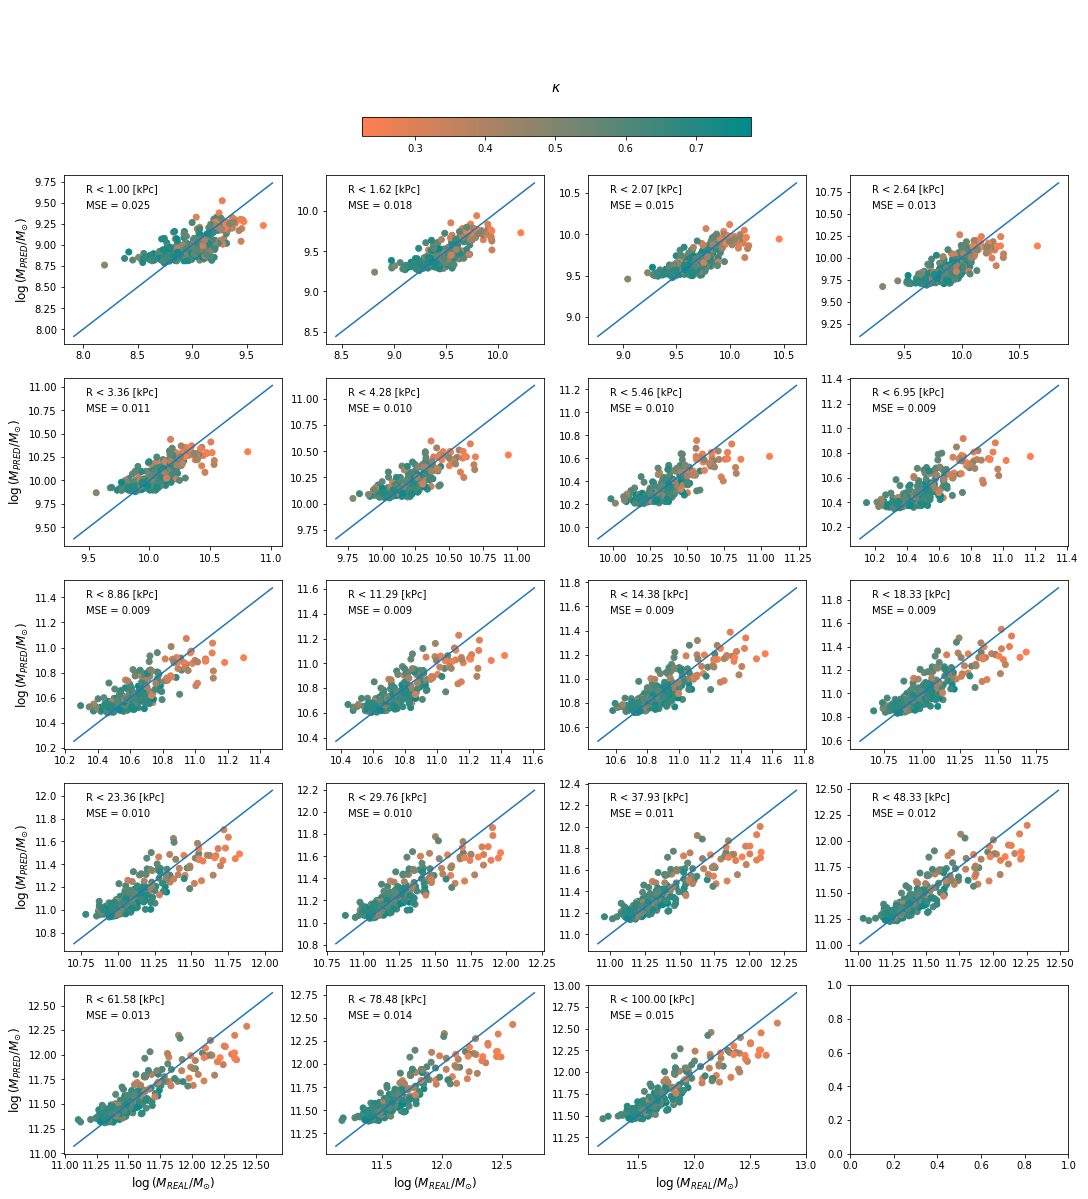

In [102]:
fig, ax = plt.subplots(5,4, figsize = (18,18))

for i in range(5):
    for j in range(4):
        if (i*4+j) < len(R_bins):
            s = ax[i,j].scatter(np.log10(M_real[:,i*4+j]), np.log10(M_ecnn[:,i*4+j]), c = (properties[test_ind,15]), cmap = custom_cmap, 
                                vmin = (properties[test_ind,15]).min(), vmax = (properties[test_ind,15]).max())
            ax[i,j].plot([min_y[i*4+j], max_y[i*4+j]], [min_y[i*4+j], max_y[i*4+j]])

            if i == 4: ax[i,j].set_xlabel('$\log{(M_{REAL} / M_{\odot})}$', fontsize = 12)
            if j == 0: ax[i,j].set_ylabel('$\log{(M_{PRED} / M_{\odot})}$', fontsize = 12)

            ax[i,j].text(0.1,0.8,'MSE = {:.3f}'.format(np.mean( (np.log10(M_real[:,i*4+j]) - np.log10(M_ecnn[:,i*4+j]))**2 )), transform = ax[i,j].transAxes)
            ax[i,j].text(0.1,0.9,'R < {:.2f} [kPc]'.format(R_bins[i*4+j]), transform = ax[i,j].transAxes)

cbar_ax = fig.add_axes([0.1, 0.91, 0.81, 0.1])
cbar_ax.axis('off')
plt.colorbar(s, ax = cbar_ax, orientation = 'horizontal')
cbar_ax.set_title('$\\kappa$', y = 0., fontsize = 14)
plt.savefig('../graphs/RealVSPred_ecnn_kappa_' + name + '.pdf', bbox_inches = 'tight')

### Figure 4

In [108]:
!ls ../data/CNNpredictions/

mass_predictions_3ch.npz		mass_predictions_8ch_19b.npz
mass_predictions_5ch.npz		mass_predictions_8ch.npz
mass_predictions_8ch_0.6-0.35-0.05.npz	mass_predictions_8ch_wo_outliers.npz
mass_predictions_8ch_19bins.npz


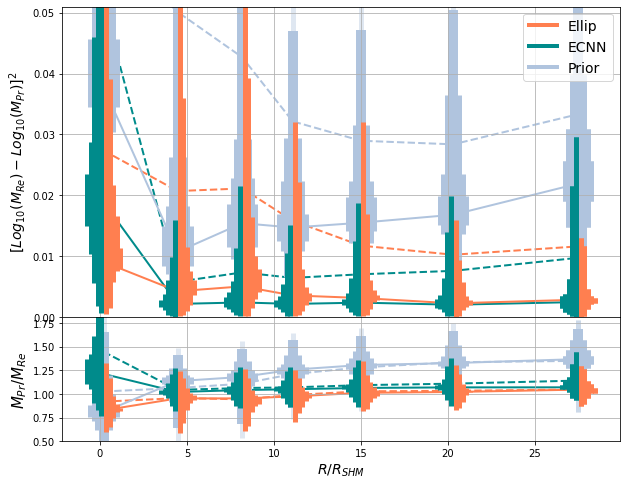

In [110]:
col_cnn = 'darkcyan'
col_ecnn = 'coral'
col_prior = 'lightsteelblue'
bins2plot = [2,12,14,15,16,17,18,18]

aux_ind = np.load('../data/CNNpredictions/mass_predictions_8ch_19b.npz')['prop_id']

spiral_ind = np.where(properties[aux_ind, 15] > 0.5)[0]
#mask = ~np.isin(spiral_ind, test_outliers)
#spiral_ind = spiral_ind[mask]

ellip_ind = np.where(properties[aux_ind, 15] < 0.5)[0]
#mask = ~np.isin(ellip_ind, test_outliers)
#ellip_ind = ellip_ind[mask]

data_list = [M_cnn_8ch_19[spiral_ind],M_cnn_8ch_19[ellip_ind], M_prior]
real_list = [M_real[spiral_ind],M_real[ellip_ind], M_real]
r_norm_list = [r_norm[spiral_ind],r_norm[ellip_ind], r_norm]
color_list = [col_cnn, col_ecnn,  col_prior]

fig, ax = plt.subplots(2,1, figsize = (10,8), gridspec_kw={'height_ratios':[2.5, 1], 'hspace':0}, sharex = True)

plot_quantiles(ax, data_list, real_list, r_norm_list, color_list, bins2plot  = bins2plot, 
               mean = True, minmax = False)


#ax[0].set_xlim(-0.65,30)
ax[0].set_ylim(-0.0,0.051)
ax[1].set_ylim(0.5,1.81)
ax[0].set_ylabel('$[Log_{10}(M_{Re}) - Log_{10}(M_{Pr})]^{2}$', fontsize = 14)

ax[1].set_xlabel('$R / R_{SHM}$', fontsize = 14)
ax[1].set_ylabel('$M_{Pr} / M_{Re}$', fontsize = 15)

ax[0].grid(which = 'both')
ax[1].grid(which = 'both')

line1 = Line2D([], [], color=col_ecnn, linestyle='solid', linewidth=4, label='Ellip')
line2 = Line2D([], [], color=col_cnn, linestyle='solid', linewidth=4, label='ECNN')
line3 = Line2D([], [], color=col_prior, linestyle='solid', linewidth=4, label='Prior')
#line4 = Line2D([], [], color='magenta', linestyle='solid', linewidth=4, label='Stellar')

# Agregar la leyenda personalizada
ax[0].legend(handles=[line1, line2, line3], loc='upper right', fontsize = 14)

plt.savefig('../graphs/MSEComparison_cnn8ch_19b_spiral_vs_ellip_' + name + '.pdf', bbox_inches = 'tight')

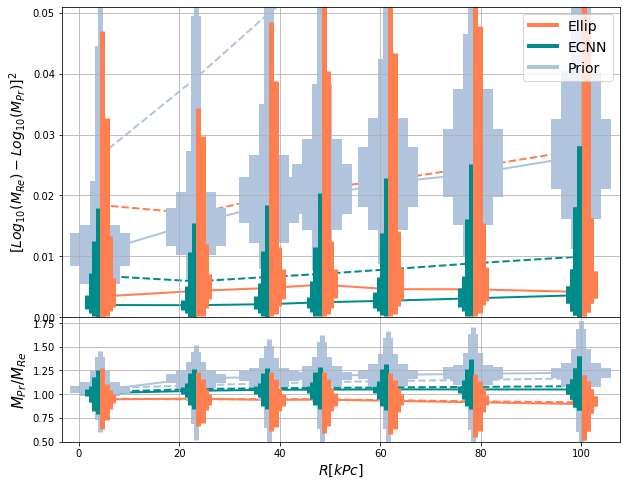

In [111]:
col_cnn = 'darkcyan'
col_ecnn = 'coral'
col_prior = 'lightsteelblue'
bins2plot = [5,12,14,15,16,17,18,18]

aux_ind = np.load('../data/CNNpredictions/mass_predictions_8ch.npz')['prop_id']
spiral_ind = np.where(properties[aux_ind, 15] > 0.5)[0]
#mask = ~np.isin(spiral_ind, test_outliers)
#spiral_ind = spiral_ind[mask]

ellip_ind = np.where(properties[aux_ind, 15] < 0.5)[0]
#mask = ~np.isin(ellip_ind, test_outliers)
#ellip_ind = ellip_ind[mask]

data_list = [M_cnn_8ch_19[spiral_ind],M_cnn_8ch_19[ellip_ind], M_prior]
real_list = [M_real[spiral_ind],M_real[ellip_ind], M_real]
r_norm_list = [r_norm[spiral_ind],r_norm[ellip_ind], r_norm]
color_list = [col_cnn, col_ecnn,  col_prior]

fig, ax = plt.subplots(2,1, figsize = (10,8), gridspec_kw={'height_ratios':[2.5, 1], 'hspace':0}, sharex = True)

plot_quantiles_kpc(ax, data_list, real_list, color_list, 
               quantiles = [10,16,30,40,50,60,70,84,90], bins2plot  = bins2plot, 
               mean = True, minmax = False, bin_centers=R_bins)


#ax[0].set_xlim(-0.65,30)
ax[0].set_ylim(-0.0,0.051)
ax[1].set_ylim(0.5,1.81)
ax[0].set_ylabel('$[Log_{10}(M_{Re}) - Log_{10}(M_{Pr})]^{2}$', fontsize = 14)

ax[1].set_xlabel('$R [kPc]$', fontsize = 14)
ax[1].set_ylabel('$M_{Pr} / M_{Re}$', fontsize = 15)

ax[0].grid(which = 'both')
ax[1].grid(which = 'both')

line1 = Line2D([], [], color=col_ecnn, linestyle='solid', linewidth=4, label='Ellip')
line2 = Line2D([], [], color=col_cnn, linestyle='solid', linewidth=4, label='ECNN')
line3 = Line2D([], [], color=col_prior, linestyle='solid', linewidth=4, label='Prior')
#line4 = Line2D([], [], color='magenta', linestyle='solid', linewidth=4, label='Stellar')

# Agregar la leyenda personalizada
ax[0].legend(handles=[line1, line2, line3], loc='upper right', fontsize = 14)

plt.savefig('../graphs/MSEComparison_cnn8ch_19b_spiral_vs_ellip_Rkpc_' + name + '.pdf', bbox_inches = 'tight')

### Saliency maps 

In [84]:
!ls -latr ../data/models/

total 49740
drwxrwxr-x 4 martinrios martinrios     4096 mar 10 11:42 ..
-rw-rw-r-- 1 martinrios martinrios 16963634 mar 13 14:09 best_model_8ch.pth
drwxrwxr-x 2 martinrios martinrios     4096 mar 13 14:26 .
-rw-rw-r-- 1 martinrios martinrios 16992406 mar 13 14:28 best_model_8ch_BN+DO.pth
-rw-rw-r-- 1 martinrios martinrios 16963822 mar 13 14:52 best_model_8ch_DO.pth


In [44]:
model.eval()
images, _ = next(iter(test_loader))

In [287]:
FoV = 17.2 # Arc minutes
pix_size_arcsec = 17.2 * (60) / 128 # Pixel size in arcsec
pix_size_rad = pix_size_arcsec / 3600 * (np.pi / 180) # Pixel size in radians

In [46]:
pix_size_rad * properties[test_ind[nimg],17] * 1e3 # pixel physical size at distance

NameError: name 'nimg' is not defined

In [477]:
R_bins / (properties[test_ind[nimg],17] * 1e3) / pix_size_rad

array([  2.28617378,   2.91321407,   3.71223581,   4.73040924,
         6.02784216,   7.68112848,   9.78786989,  12.47243776,
        15.89331545,  20.25245432,  25.80719594,  32.88546423,
        41.90512447,  53.39865188,  68.04456636,  86.70748883,
       110.48918409, 140.79360347, 179.40976705, 228.61737834])

In [484]:
properties[test_ind[nimg],0]

564567.0

In [485]:
image_name = glob.glob(os.path.join('../data/TNGgalaxies_28_02/' + str(int(properties[test_ind[nimg],0])), 'galaxy_D_*_SDSS_G*.png'))

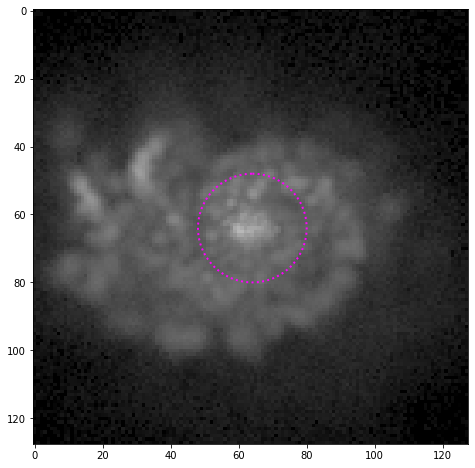

In [494]:
image = plt.imread(image_name[0])
fig, ax = plt.subplots(1,1, figsize = (8,8))

ax.imshow(image)
circulo = patches.Circle((64,64,), int(properties[test_ind[nimg],13] / (properties[test_ind[nimg],17] * 1e3) / pix_size_rad), 
                         edgecolor='magenta', facecolor='none', linewidth=2, linestyle = ':')
ax.add_patch(circulo)

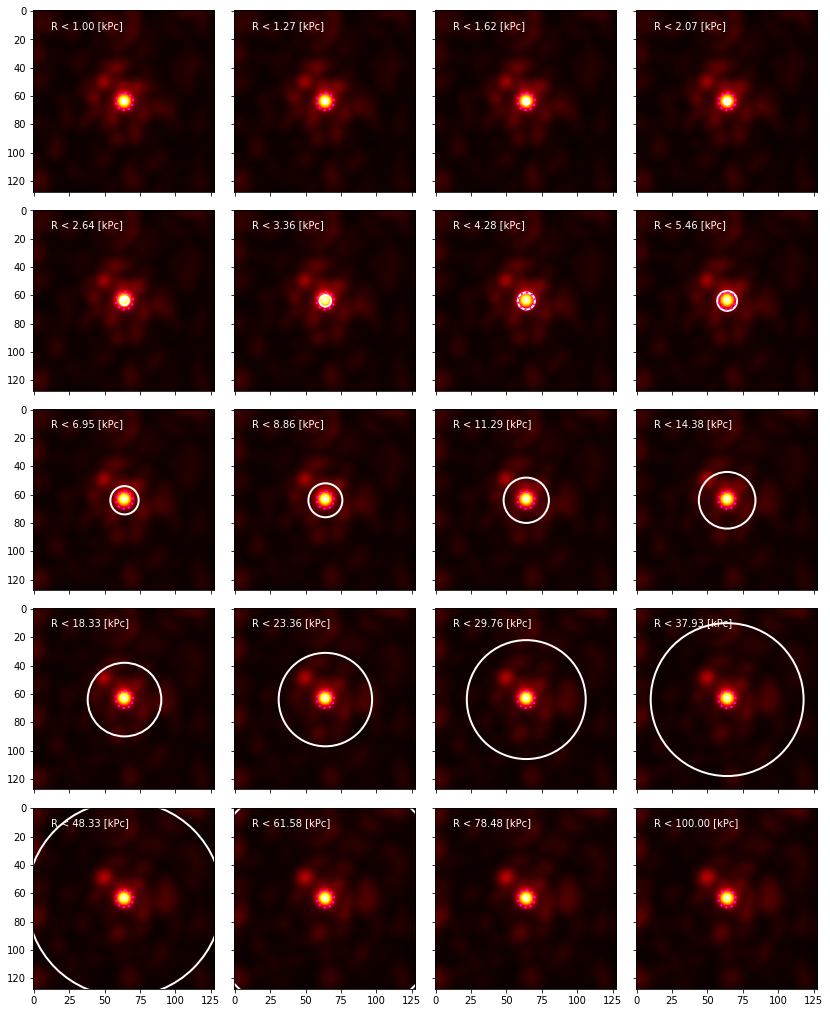

In [625]:
nimg = 1
ch = 0
image = images[nimg].unsqueeze(0)
noise_levels = np.array([1e-4,1e-3,1e-3,1e-3,1e-3,1e-2,1e-5,1e-7]).reshape(1,8,1,1)

x, y = np.ogrid[:128, :128]

fig, ax = plt.subplots(5,4, figsize = (18,18), sharex = True, sharey = True)
plt.subplots_adjust(wspace=-0.5, hspace=0.1)

saliency_profile_list = []
for i in range(5):
    for j in range(4):
        
        saliency_map = estimate_saliency_map(model, image, radial_bin = i*4+j, noise_levels = noise_levels,
                                 num_perturbations = 20)
        saliency_profile = []
        for r in R_bins:
            # Calcular la máscara circular
            mask = (x - 64)**2 + (y - 64)**2 <= int(r / (properties[test_ind[nimg],17] * 1e3) / pix_size_rad)**2

            # Aplicar la máscara a la imagen
            image_masked = saliency_map[ch, :,:].copy()
            image_masked[~mask] = 0  # Establecer a 0 los píxeles fuera del círculo
            saliency_profile.append(np.sum(image_masked) / (4*np.pi/3*(r**3)))

        saliency_profile = np.asarray(saliency_profile)
        saliency_profile_list.append(saliency_profile)
        norm_saliency_map = (saliency_map[ch, :,:] - saliency_map[ch, :,:].min()) / (saliency_map[ch, :,:].max() - saliency_map[ch, :,:].min())

        smoothed_saliency_map = gaussian_filter(norm_saliency_map, sigma=3)  # Adjust sigma for desired smoothing

        ax1 = ax[i,j].imshow(smoothed_saliency_map, cmap='hot')
        circulo = patches.Circle((64,64,), int(R_bins[i*4+j] / (properties[test_ind[nimg],17] * 1e3) / pix_size_rad), edgecolor='white', facecolor='none', linewidth=2)
        ax[i,j].add_patch(circulo)
        
        circulo = patches.Circle((64,64,), int(properties[test_ind[nimg],13] / (properties[test_ind[nimg],17] * 1e3) / pix_size_rad), 
                                 edgecolor='magenta', facecolor='none', linewidth=2, linestyle = ':')
        ax[i,j].add_patch(circulo)
        
        #ax[i,j].text(0.1,0.8,'MSE = {:.3f}'.format(mean_squared_error(np.log10(M_real[:,i*4+j]), np.log10(M_pred[:,i*4+j]))), transform = ax[i,j].transAxes)
        ax[i,j].text(0.1,0.9,'R < {:.2f} [kPc]'.format(R_bins[i*4+j]), transform = ax[i,j].transAxes, color = 'white')
        ax[i,j].set_xlabel('')
        ax[i,j].set_ylabel('')

#plt.savefig('../graphs/SaliencyMaps_' + str(properties[test_ind[nimg],0]) + '_ch_' + str(ch) + '_' + name + '.pdf')

In [620]:
cmap = plt.get_cmap('viridis')
norm = Normalize(vmin=0, vmax=2)

# Usar cmap con valores normalizados
color = cmap(norm(R_bins[i]))

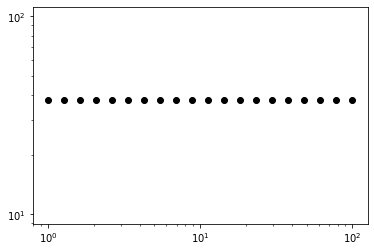

In [621]:
for i in range(len(saliency_profile_list)):
    plt.scatter(R_bins[i], R_bins[np.where( (saliency_profile_list[i] * R_bins**3 / R_bins[19]**3 / saliency_profile_list[i][19] - 0.5) > 0 )[0][0]], c = 'black')
    
plt.yscale('log')
plt.xscale('log')

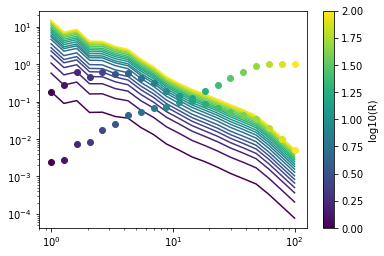

In [624]:
for i in range(len(saliency_profile_list)):
    plt.plot(R_bins, saliency_profile_list[i], label = f'R < {R_bins[i]}', color= cmap(norm(np.log10(R_bins[i]))))
    plt.scatter(R_bins[i], saliency_profile_list[i][i] * R_bins[i]**3 / R_bins[19]**3 / saliency_profile_list[i][19], color= cmap(norm(np.log10(R_bins[i]))), zorder = 21)
    plt.scatter(R_bins[i], saliency_profile_list[i][i], color= cmap(norm(np.log10(R_bins[i]))), zorder = 21)
#plt.legend()
plt.yscale('log')
plt.xscale('log')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label='log10(R)')

### Masked analysis

In [112]:
FoV = 17.2 # Arc minutes
pix_size_arcsec = 17.2 * (60) / 128 # Pixel size in arcsec
pix_size_rad = pix_size_arcsec / 3600 * (np.pi / 180) # Pixel size in radians

In [113]:
mask_size_in_hmr = np.geomspace(0.1, 20, len(R_bins))

In [115]:
ZP = [24.63, 25.11, 24.80, 24.36, 22.83]
mean_mag_arcsec2 = [22.01, 21.84, 20.84, 20.16, 18.96]
std_mag_arcsec2 = 0.1
noisy_mask = True # If true de mask is just random noise, if False the mask is 0's
full_noise = False # If true we add noise to all the image

#nimg = 0
x, y = np.ogrid[:128, :128]

masked_mass_predictions = []
masked_size_list = []

for nbin in range(20):
    x_testset_masked = np.zeros_like(x_testset)
    masked_size_aux = []
    for nimg in range(test_size):
        for ch in range(nch):
            if nbin == 19:
                mask = (x - 64)**2 + (y - 64)**2 <= int(10000 / (properties[test_ind[nimg],17] * 1e3) / pix_size_rad)**2
            else:
                mask_size = mask_size_in_hmr[nbin] * properties[test_ind[nimg], 13] # R_bins[nbin]
                mask = (x - 64)**2 + (y - 64)**2 <= int(mask_size / (properties[test_ind[nimg],17] * 1e3) / pix_size_rad)**2

            # Aplicar la máscara a la imagen
            image_masked = x_testset[nimg,ch,:,:].copy()
            if nbin < 19: image_masked[~mask] = 0  # Establecer a 0 los píxeles fuera del círculo

            noise = np.zeros_like(image_masked)
            if noisy_mask and (ch < 5):
                mean_mjysr = 10**(-0.4 * (mean_mag_arcsec2[ch] + ZP[ch]) ) * 3631 * (u.Jy/(u.arcsec**2)).to(u.MJy/u.sr) # From https://classic.sdss.org/dr7/algorithms/fluxcal.php
                std_mjysr = 10**(-0.4 * (mean_mag_arcsec2[ch] - std_mag_arcsec2 + ZP[ch]) ) * 3631 * (u.Jy/(u.arcsec**2)).to(u.MJy/u.sr)
                noise = np.random.normal(mean_mjysr, np.abs(std_mjysr - mean_mjysr), size=(128,128))
                noise = ((noise - min_x[ch,:,:]) / (max_x[ch,:,:] - min_x[ch,:,:]))
                noise[mask] = 0
            bkg_noise = np.zeros_like(image_masked)
            if full_noise:
                q = np.quantile(x_testset[nimg,ch,:,:], q = (0.1,0.2,0.3))
                bkg_noise = np.abs(np.random.normal(q[1], scale = q[2] - q[0], size = (128,128)))
            x_testset_masked[nimg,ch,:,:] = image_masked + noise + bkg_noise
        masked_size_aux.append(len(np.where(mask == False)[0]))
    masked_size_list.append(masked_size_aux)
    # Crear los DataLoaders para entrenamiento y validación
    masked_test_dataset  = CustomDataset(x_testset_masked, y_testset)
    masked_test_loader  = DataLoader(masked_test_dataset, batch_size=32, shuffle=False)

    masked_M_pred_list = []
    masked_test_loss_list = []
    for i in range(10):
        best_model_path = '../data/models/best_model_' + name + '_' + str(i) + '.pth'

        model.load_state_dict(torch.load(best_model_path, weights_only=True))
        model = model.to(device)
        model.eval()  # Asegúrate de que el modelo esté en modo evaluación
        y_predicted_masked = []  # Lista para almacenar las predicciones

        # Desactivamos el cálculo de gradientes durante la predicción
        with torch.no_grad():
            test_loss = 0
            for inputs, true_vals in masked_test_loader:  # Usamos _ porque no necesitamos las etiquetas en x_testset

                inputs = inputs.to(device)
                true_vals = true_vals.to(device)
                # Hacer predicciones
                outputs = model(inputs)

                # Almacenar las predicciones (por ejemplo, como numpy arrays)
                test_loss += criterion(outputs, true_vals)
                y_predicted_masked.append(outputs.detach().cpu().numpy())  # Si necesitas los resultados como numpy

        test_loss = test_loss / len(test_loader)
        #print(f'Test Loss = {test_loss}')  # Esto te dará la forma de las predicciones
        masked_test_loss_list.append(test_loss)

        # Convertir la lista de predicciones en un solo array
        y_predicted_masked = np.concatenate(y_predicted_masked, axis=0)

        #print(y_predicted_masked.shape)  # Esto te dará la forma de las predicciones

        masked_M_pred = 10**(y_predicted_masked * (max_y - min_y) + min_y)
        M_real = 10**(y_testset * (max_y - min_y) + min_y)

        mass_quantiles = np.percentile((masked_M_pred / M_real), [25, 50, 75], axis=0)
        masked_M_pred_list.append(masked_M_pred)

    if len(masked_M_pred_list) > 1:
        masked_M_pred_list = np.asarray(masked_M_pred_list)
        masked_M_pred = np.mean(masked_M_pred_list, axis = 0)
        masked_M_pred_std = np.std(masked_M_pred_list, axis = 0)
    else:
        masked_M_pred_std = None

    y_predicted_masked = (np.log10(masked_M_pred) - min_y) / (max_y - min_y)
    masked_mass_predictions.append(masked_M_pred)

In [116]:
masked_size_list = np.asarray(masked_size_list)

In [117]:
masked_size_list.shape

(20, 298)

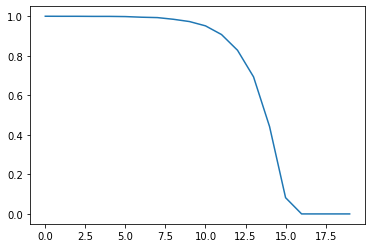

In [118]:
plt.plot(masked_size_list[:,0] / (npix*npix))

In [119]:
len(np.where(image_masked == 0)[0])

11256

In [120]:
len(np.where(mask == False)[0])

0

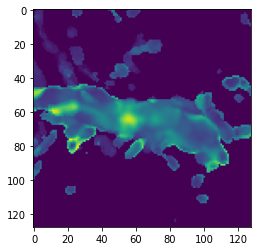

In [121]:
plt.imshow(image_masked)

In [122]:
masked_M_pred.shape

(298, 19)

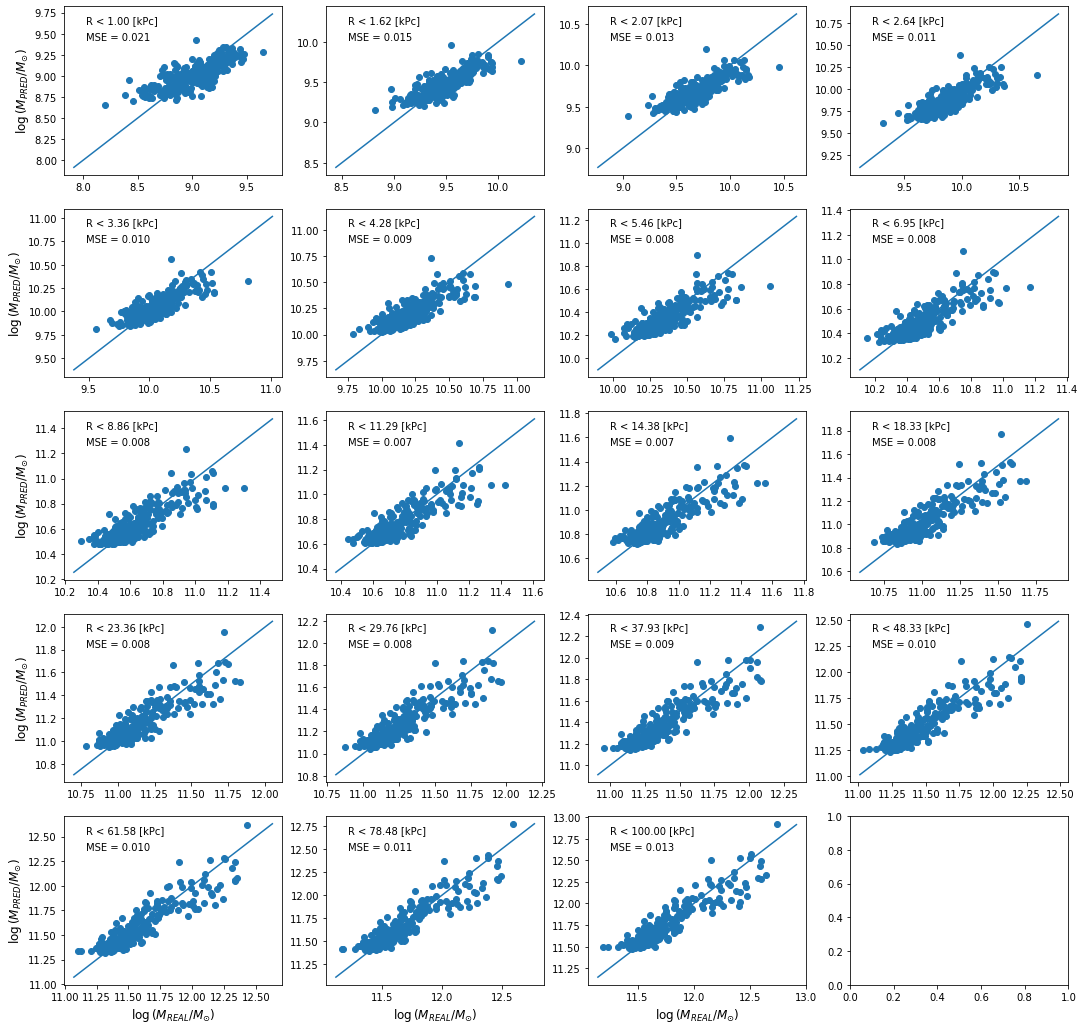

In [125]:
imask = 19
aux_pred = masked_mass_predictions[imask]
fig, ax = plt.subplots(5,4, figsize = (18,18))

for i in range(5):
    for j in range(4):
        if (i*4+j) < len(R_bins):
            ax[i,j].scatter(np.log10(M_real[:,i*4+j]), np.log10(aux_pred[:,i*4+j]))
            ax[i,j].plot([min_y[i*4+j], max_y[i*4+j]], [min_y[i*4+j], max_y[i*4+j]])

            if i == 4: ax[i,j].set_xlabel('$\log{(M_{REAL} / M_{\odot})}$', fontsize = 12)
            if j == 0: ax[i,j].set_ylabel('$\log{(M_{PRED} / M_{\odot})}$', fontsize = 12)

            ax[i,j].text(0.1,0.8,'MSE = {:.3f}'.format(mean_squared_error(np.log10(M_real[:,i*4+j]), np.log10(aux_pred[:,i*4+j]))), transform = ax[i,j].transAxes)
            ax[i,j].text(0.1,0.9,'R < {:.2f} [kPc]'.format(R_bins[i*4+j]), transform = ax[i,j].transAxes)
        
#plt.savefig('../graphs/RealVSPred_' + name + f'_mask_{R_bins[imask]}.pdf')

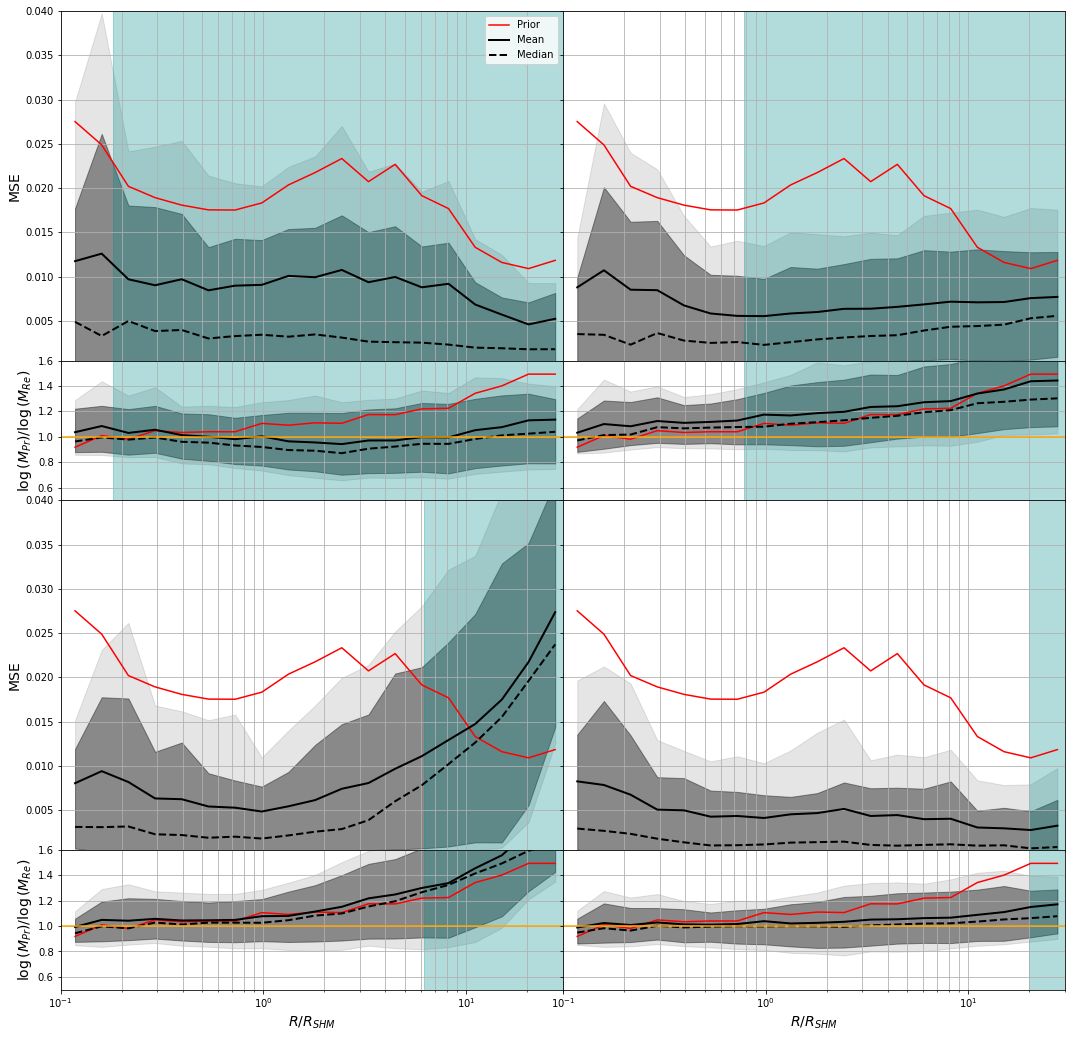

In [126]:
r = np.zeros_like(masked_mass_predictions[15])
for i in range(len(test_ind)):
    r[i,:] = R_bins / properties[test_ind[i], 13]
    
fig,ax = plt.subplots(4,2, figsize = (18,18), gridspec_kw={'height_ratios':[2.5, 1, 2.5, 1], 'hspace':0, 'wspace':0}, sharex = True)

for ii, iaux in enumerate([2, 7, 14, 18]):
    jj = 0
    if ii > 1: 
        ii = ii-2
        jj = jj+2
    aux_pred = masked_mass_predictions[iaux]
    aux_pred = (np.log10(aux_pred) - min_y) / (max_y - min_y)

    bins, bin_centers, mse, std, p10, p16, p50, p84, p90 = binned_MSE(r, (aux_pred - y_testset)**2)
    _, _, mse_prior, _, _, _, _, _, _ = binned_MSE(r, (y_prior - y_testset)**2, bins = bins)

    ax[jj,ii].plot(bin_centers, mse_prior, color = 'red', label = 'Prior')

    ax[jj,ii].plot(bin_centers, mse, color = 'black', label = 'Mean', lw = 2)
    ax[jj,ii].fill_between(bin_centers, p10, p90, color = 'black', alpha = 0.1)
    ax[jj,ii].fill_between(bin_centers, p16, p84, color = 'black', alpha = 0.4)
    ax[jj,ii].plot(bin_centers, p50, color = 'black', label = 'Median', ls = '--', lw = 2)
    
    ax[jj,ii].axvspan(mask_size_in_hmr[iaux], 40, color='darkcyan', alpha=0.3)
    
    _, _, ratio, std, p10, p16, p50, p84, p90 = binned_MSE(r, aux_pred / y_testset, bins = bins)
    _, _, ratio_prior, _, _, _, _, _, _ = binned_MSE(r, y_prior / y_testset, bins = bins)

    ax[jj+1,ii].plot(bin_centers, ratio_prior, color = 'red', label = 'Prior')

    ax[jj+1,ii].plot(bin_centers, ratio, color = 'black', label = 'Mean', lw = 2)
    ax[jj+1,ii].fill_between(bin_centers, p10, p90, color = 'black', alpha = 0.1)
    ax[jj+1,ii].fill_between(bin_centers, p16, p84, color = 'black', alpha = 0.4)
    ax[jj+1,ii].plot(bin_centers, p50, color = 'black', label = 'Median', ls = '--', lw = 2)
    
    ax[jj+1,ii].axvspan(mask_size_in_hmr[iaux], 40, color='darkcyan', alpha=0.3)


ax[1,0].axhline(y=1, color = 'orange')
ax[1,1].axhline(y=1, color = 'orange')
ax[3,0].axhline(y=1, color = 'orange')
ax[3,1].axhline(y=1, color = 'orange')

ax[0,0].set_ylim(0.0005,0.04)
ax[1,0].set_ylim(0.5,1.6)
ax[0,1].set_ylim(0.0005,0.04)
ax[1,1].set_ylim(0.5,1.6)
ax[2,0].set_ylim(0.0005,0.04)
ax[3,0].set_ylim(0.5,1.6)
ax[2,1].set_ylim(0.0005,0.04)
ax[3,1].set_ylim(0.5,1.6)

ax[0,0].set_xlim(0.1, 30)

ax[3,0].set_xlabel('$R / R_{SHM}$', fontsize = 14)
ax[3,1].set_xlabel('$R / R_{SHM}$', fontsize = 14)
    
ax[0,0].set_ylabel('MSE', fontsize = 14)
ax[1,0].set_ylabel('$\\log{ (M_{Pr}) } / \\log{(M_{Re})}$', fontsize = 14)
ax[2,0].set_ylabel('MSE', fontsize = 14)
ax[3,0].set_ylabel('$\\log{ (M_{Pr}) } / \\log{(M_{Re})}$', fontsize = 14)
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')
ax[2,1].set_ylabel('')
ax[3,1].set_ylabel('')

ax[0,1].set_yticklabels([])
ax[1,1].set_yticklabels([])
ax[2,1].set_yticklabels([])
ax[3,1].set_yticklabels([])

for i, iax in enumerate(fig.axes): iax.grid(which = 'both')

ax[0,0].set_xscale('log')
ax[0,0].legend()

#plt.savefig('../graphs/MaskedNormalizedMSE_' + name + '.pdf')

### Inverse mask analysis

In [128]:
FoV = 17.2 # Arc minutes
pix_size_arcsec = 17.2 * (60) / 128 # Pixel size in arcsec
pix_size_rad = pix_size_arcsec / 3600 * (np.pi / 180) # Pixel size in radians
mask_size_in_hmr = np.geomspace(0.1, 20, 20)

In [129]:
ZP = [24.63, 25.11, 24.80, 24.36, 22.83]
mean_mag_arcsec2 = [22.01, 21.84, 20.84, 20.16, 18.96]
std_mag_arcsec2 = 0.1
noisy_mask = True # If true de mask is just random noise, if False the mask is 0's
full_noise = False # If true we add noise to all the image

#nimg = 0
x, y = np.ogrid[:128, :128]

masked_mass_predictions = []
masked_size_list = []

for nbin in range(20):
    x_testset_masked = np.zeros_like(x_testset)
    masked_size_aux = []
    for nimg in range(test_size):
        for ch in range(nch):
            if nbin == 19:
                pass
                #mask = (x - 64)**2 + (y - 64)**2 > int(10000 / (properties[test_ind[nimg],17] * 1e3) / pix_size_rad)**2
            else:
                mask_size = mask_size_in_hmr[nbin] * properties[test_ind[nimg], 13] # R_bins[nbin]
                mask = (x - 64)**2 + (y - 64)**2 > int(mask_size / (properties[test_ind[nimg],17] * 1e3) / pix_size_rad)**2

            # Aplicar la máscara a la imagen
            image_masked = x_testset[nimg,ch,:,:].copy()
            if nbin < 19: image_masked[~mask] = 0  # Establecer a 0 los píxeles dentro del círculo

            noise = np.zeros_like(image_masked)
            if noisy_mask and (ch < 5):
                mean_mjysr = 10**(-0.4 * (mean_mag_arcsec2[ch] + ZP[ch]) ) * 3631 * (u.Jy/(u.arcsec**2)).to(u.MJy/u.sr) # From https://classic.sdss.org/dr7/algorithms/fluxcal.php
                std_mjysr = 10**(-0.4 * (mean_mag_arcsec2[ch] - std_mag_arcsec2 + ZP[ch]) ) * 3631 * (u.Jy/(u.arcsec**2)).to(u.MJy/u.sr)
                noise = np.random.normal(mean_mjysr, np.abs(std_mjysr - mean_mjysr), size=(128,128))
                noise = ((noise - min_x[ch,:,:]) / (max_x[ch,:,:] - min_x[ch,:,:]))
                noise[mask] = 0
            bkg_noise = np.zeros_like(image_masked)
            if full_noise:
                q = np.quantile(x_testset[nimg,ch,:,:], q = (0.1,0.2,0.3))
                bkg_noise = np.abs(np.random.normal(q[1], scale = q[2] - q[0], size = (128,128)))
            x_testset_masked[nimg,ch,:,:] = image_masked + noise + bkg_noise
        masked_size_aux.append(len(np.where(mask == False)[0]))
    masked_size_list.append(masked_size_aux)
    # Crear los DataLoaders para entrenamiento y validación
    masked_test_dataset  = CustomDataset(x_testset_masked, y_testset)
    masked_test_loader  = DataLoader(masked_test_dataset, batch_size=32, shuffle=False)

    masked_M_pred_list = []
    masked_test_loss_list = []
    for i in range(10):
        best_model_path = '../data/models/best_model_' + name + '_' + str(i) + '.pth'

        model.load_state_dict(torch.load(best_model_path, weights_only=True))
        model = model.to(device)
        model.eval()  # Asegúrate de que el modelo esté en modo evaluación
        y_predicted_masked = []  # Lista para almacenar las predicciones

        # Desactivamos el cálculo de gradientes durante la predicción
        with torch.no_grad():
            test_loss = 0
            for inputs, true_vals in masked_test_loader:  # Usamos _ porque no necesitamos las etiquetas en x_testset
                inputs = inputs.to(device)
                true_vals = true_vals.to(device)
                # Hacer predicciones
                outputs = model(inputs)

                # Almacenar las predicciones (por ejemplo, como numpy arrays)
                test_loss += criterion(outputs, true_vals)
                y_predicted_masked.append(outputs.detach().cpu().numpy())  # Si necesitas los resultados como numpy

        test_loss = test_loss / len(test_loader)
        #print(f'Test Loss = {test_loss}')  # Esto te dará la forma de las predicciones
        masked_test_loss_list.append(test_loss)

        # Convertir la lista de predicciones en un solo array
        y_predicted_masked = np.concatenate(y_predicted_masked, axis=0)

        #print(y_predicted_masked.shape)  # Esto te dará la forma de las predicciones

        masked_M_pred = 10**(y_predicted_masked * (max_y - min_y) + min_y)
        M_real = 10**(y_testset * (max_y - min_y) + min_y)

        mass_quantiles = np.percentile((masked_M_pred / M_real), [25, 50, 75], axis=0)
        masked_M_pred_list.append(masked_M_pred)

    if len(masked_M_pred_list) > 1:
        masked_M_pred_list = np.asarray(masked_M_pred_list)
        masked_M_pred = np.mean(masked_M_pred_list, axis = 0)
        masked_M_pred_std = np.std(masked_M_pred_list, axis = 0)
    else:
        masked_M_pred_std = None

    y_predicted_masked = (np.log10(masked_M_pred) - min_y) / (max_y - min_y)
    masked_mass_predictions.append(masked_M_pred)

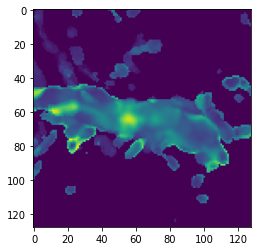

In [130]:
plt.imshow(image_masked)

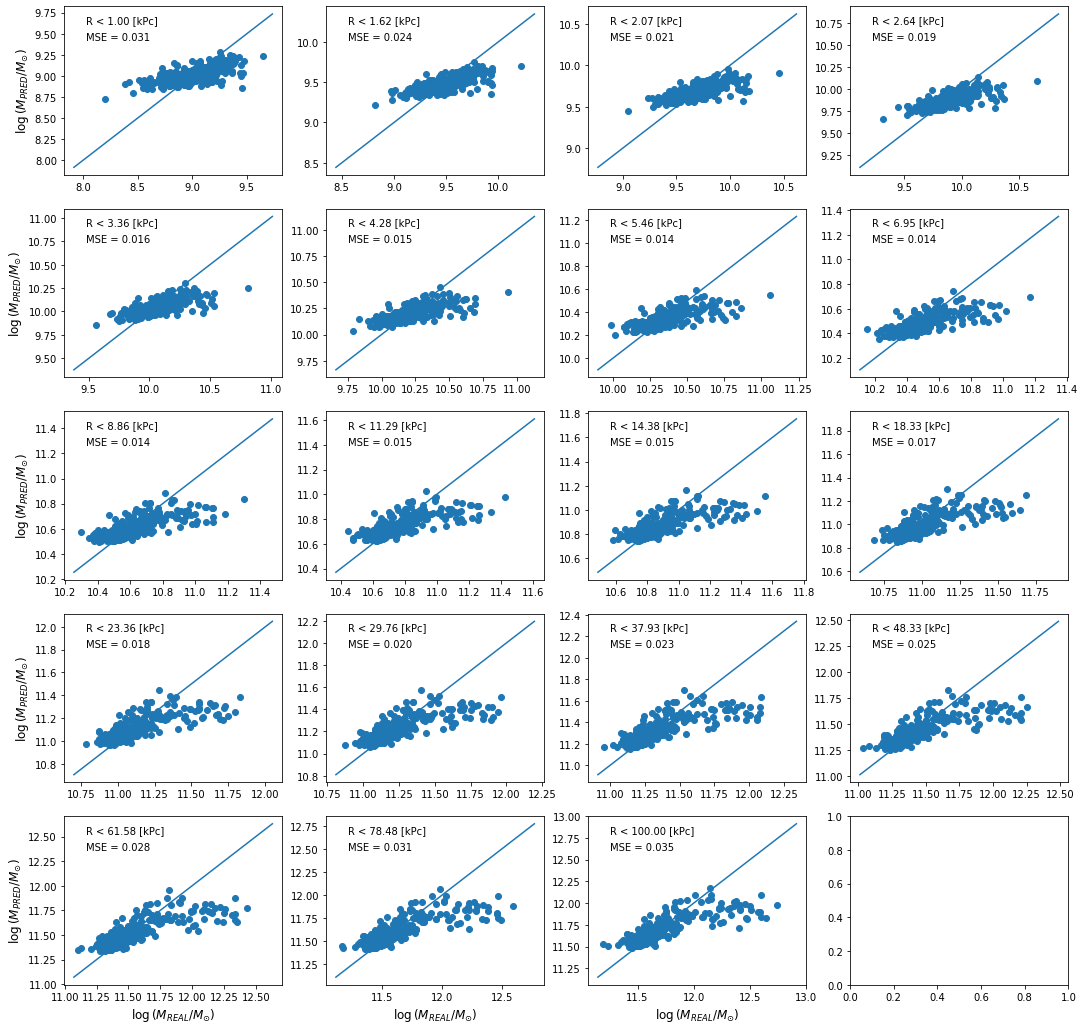

In [131]:
imask = 1
aux_pred = masked_mass_predictions[imask]
fig, ax = plt.subplots(5,4, figsize = (18,18))

for i in range(5):
    for j in range(4):
        if (i*4+j) < len(R_bins):
            ax[i,j].scatter(np.log10(M_real[:,i*4+j]), np.log10(aux_pred[:,i*4+j]))
            ax[i,j].plot([min_y[i*4+j], max_y[i*4+j]], [min_y[i*4+j], max_y[i*4+j]])

            if i == 4: ax[i,j].set_xlabel('$\log{(M_{REAL} / M_{\odot})}$', fontsize = 12)
            if j == 0: ax[i,j].set_ylabel('$\log{(M_{PRED} / M_{\odot})}$', fontsize = 12)

            ax[i,j].text(0.1,0.8,'MSE = {:.3f}'.format(mean_squared_error(np.log10(M_real[:,i*4+j]), np.log10(aux_pred[:,i*4+j]))), transform = ax[i,j].transAxes)
            ax[i,j].text(0.1,0.9,'R < {:.2f} [kPc]'.format(R_bins[i*4+j]), transform = ax[i,j].transAxes)
        
#plt.savefig('../graphs/RealVSPred_' + name + f'_Inversemask_{R_bins[imask]}.pdf')

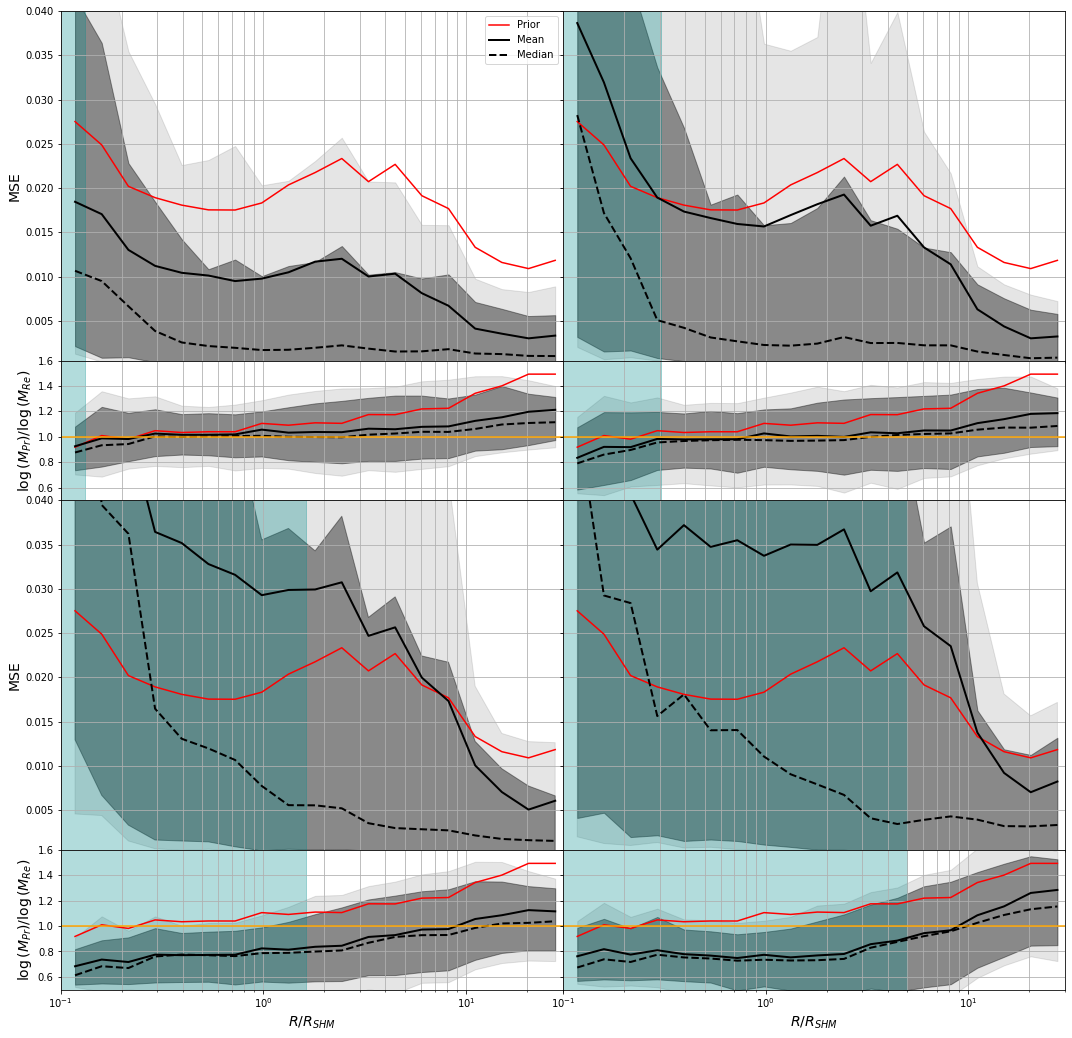

In [132]:
r = np.zeros_like(masked_mass_predictions[15])
for i in range(len(test_ind)):
    r[i,:] = R_bins / properties[test_ind[i], 13]
    
fig,ax = plt.subplots(4,2, figsize = (18,18), gridspec_kw={'height_ratios':[2.5, 1, 2.5, 1], 'hspace':0, 'wspace':0}, sharex = True)

for ii, iaux in enumerate([1, 4, 10, 14]):
    jj = 0
    if ii > 1: 
        ii = ii-2
        jj = jj+2
    aux_pred = masked_mass_predictions[iaux]
    aux_pred = (np.log10(aux_pred) - min_y) / (max_y - min_y)

    bins, bin_centers, mse, std, p10, p16, p50, p84, p90 = binned_MSE(r, (aux_pred - y_testset)**2)
    _, _, mse_prior, _, _, _, p50_prior, _, _ = binned_MSE(r, (y_prior - y_testset)**2, bins = bins)

    ax[jj,ii].plot(bin_centers, mse_prior, color = 'red', label = 'Prior')

    ax[jj,ii].plot(bin_centers, mse, color = 'black', label = 'Mean', lw = 2)
    ax[jj,ii].fill_between(bin_centers, p10, p90, color = 'black', alpha = 0.1)
    ax[jj,ii].fill_between(bin_centers, p16, p84, color = 'black', alpha = 0.4)
    ax[jj,ii].plot(bin_centers, p50, color = 'black', label = 'Median', ls = '--', lw = 2)
    
    if iaux < 20: ax[jj,ii].axvspan(-1, mask_size_in_hmr[iaux], color='darkcyan', alpha=0.3)
    
    _, _, ratio, std, p10, p16, p50, p84, p90 = binned_MSE(r, aux_pred / y_testset, bins = bins)
    _, _, ratio_prior, _, _, _, _, _, _ = binned_MSE(r, y_prior / y_testset, bins = bins)

    ax[jj+1,ii].plot(bin_centers, ratio_prior, color = 'red', label = 'Prior')

    ax[jj+1,ii].plot(bin_centers, ratio, color = 'black', label = 'Mean', lw = 2)
    ax[jj+1,ii].fill_between(bin_centers, p10, p90, color = 'black', alpha = 0.1)
    ax[jj+1,ii].fill_between(bin_centers, p16, p84, color = 'black', alpha = 0.4)
    ax[jj+1,ii].plot(bin_centers, p50, color = 'black', label = 'Median', ls = '--', lw = 2)
    
    if iaux < 20: ax[jj+1,ii].axvspan(-1, mask_size_in_hmr[iaux], color='darkcyan', alpha=0.3)


ax[1,0].axhline(y=1, color = 'orange')
ax[1,1].axhline(y=1, color = 'orange')
ax[3,0].axhline(y=1, color = 'orange')
ax[3,1].axhline(y=1, color = 'orange')

ax[0,0].set_ylim(0.0005,0.04)
ax[1,0].set_ylim(0.5,1.6)
ax[0,1].set_ylim(0.0005,0.04)
ax[1,1].set_ylim(0.5,1.6)
ax[2,0].set_ylim(0.0005,0.04)
ax[3,0].set_ylim(0.5,1.6)
ax[2,1].set_ylim(0.0005,0.04)
ax[3,1].set_ylim(0.5,1.6)

ax[0,0].set_xlim(0.1, 30)

ax[3,0].set_xlabel('$R / R_{SHM}$', fontsize = 14)
ax[3,1].set_xlabel('$R / R_{SHM}$', fontsize = 14)
    
ax[0,0].set_ylabel('MSE', fontsize = 14)
ax[1,0].set_ylabel('$\\log{ (M_{Pr}) } / \\log{(M_{Re})}$', fontsize = 14)
ax[2,0].set_ylabel('MSE', fontsize = 14)
ax[3,0].set_ylabel('$\\log{ (M_{Pr}) } / \\log{(M_{Re})}$', fontsize = 14)
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')
ax[2,1].set_ylabel('')
ax[3,1].set_ylabel('')

ax[0,1].set_yticklabels([])
ax[1,1].set_yticklabels([])
ax[2,1].set_yticklabels([])
ax[3,1].set_yticklabels([])

for i, iax in enumerate(fig.axes): iax.grid(which = 'both')

ax[0,0].set_xscale('log')
ax[0,0].legend()

plt.savefig('../graphs/InverseMaskedNormalizedMSE_' + name + '.pdf')

### Masking channels

In [ ]:
ZP = [24.63, 25.11, 24.80, 24.36, 22.83]
mean_mag_arcsec2 = [22.01, 21.84, 20.84, 20.16, 18.96]
std_mag_arcsec2 = 0.1
noisy_mask = True
full_noise = False

mask_size_in_hmr = np.geomspace(1, 20, 19)
x, y = np.ogrid[:128, :128]

masked_mass_predictions = []
masked_size_list = []

titles = ['Full','w/o HI','w/o SDSS',
          'w/o SDSS-U','w/o SDSS-G','w/o SDSS-R','w/o SDSS-I','w/o SDSS-Z',
          'w/o HI-0','w/o HI-1','w/o HI-2',
          'SDSS-UGR + HI-0', 'SDSS-UGR + HI-1','SDSS-UGR + HI-2',
          'SDSS-UGRI + HI-0', 'SDSS-UGRI + HI-1','SDSS-UGRI + HI-2']

delete_ch_list = [[8], [5,6,7], [0,1,2,3,4],
                  [0],[1],[2],[3],[4],
                  [5],[6],[7],
                  [3,4,6,7],[3,4,5,7],[3,4,5,6],
                  [3,6,7],[3,5,7],[3,5,6]]
for delete_ch in tqdm(delete_ch_list):
    for nbin in range(1):
        x_testset_masked = np.copy(x_testset)
        masked_size_aux = []
        for nimg in range(test_size):
            for ch in delete_ch:
                if nbin == 19:
                    mask = (x - 64)**2 + (y - 64)**2 <= int(10000 / (properties[test_ind[nimg],17] * 1e3) / pix_size_rad)**2
                elif nbin == 0:
                    mask = np.zeros((128, 128), dtype=bool)
                else:
                    mask_size = mask_size_in_hmr[nbin] * properties[test_ind[nimg], 13] # R_bins[nbin]
                    mask = (x - 64)**2 + (y - 64)**2 <= int(mask_size / (properties[test_ind[nimg],17] * 1e3) / pix_size_rad)**2

                # Aplicar la máscara a la imagen
                if ch < 8:
                    image_masked = x_testset[nimg,ch,:,:].copy()
                    if i < 19: image_masked[~mask] = 0  # Establecer a 0 los píxeles fuera del círculo

                    noise = np.zeros_like(image_masked)
                    if noisy_mask and (ch < 5):
                        mean_mjysr = 10**(-0.4 * (mean_mag_arcsec2[ch] + ZP[ch]) ) * 3631 * (u.Jy/(u.arcsec**2)).to(u.MJy/u.sr) # From https://classic.sdss.org/dr7/algorithms/fluxcal.php
                        std_mjysr = 10**(-0.4 * (mean_mag_arcsec2[ch] - std_mag_arcsec2 + ZP[ch]) ) * 3631 * (u.Jy/(u.arcsec**2)).to(u.MJy/u.sr)
                        noise = np.random.normal(mean_mjysr, np.abs(std_mjysr - mean_mjysr), size=(128,128))
                        noise = ((noise - min_x[ch,:,:]) / (max_x[ch,:,:] - min_x[ch,:,:]))
                        noise[mask] = 0
                    bkg_noise = np.zeros_like(image_masked)
                    if full_noise:
                        q = np.quantile(x_testset[nimg,ch,:,:], q = (0.1,0.2,0.3))
                        bkg_noise = np.abs(np.random.normal(q[1], scale = q[2] - q[0], size = (128,128)))
                    x_testset_masked[nimg,ch,:,:] = image_masked + noise + bkg_noise
            masked_size_aux.append(len(np.where(mask == False)[0]))
        masked_size_list.append(masked_size_aux)
        # Crear los DataLoaders para entrenamiento y validación
        masked_test_dataset  = CustomDataset(x_testset_masked, y_testset)
        masked_test_loader  = DataLoader(masked_test_dataset, batch_size=32, shuffle=False)

        masked_M_pred_list = []
        masked_test_loss_list = []
        for i in range(10):
            best_model_path = '../data/models/best_model_' + name + '_' + str(i) + '.pth'

            model.load_state_dict(torch.load(best_model_path, weights_only=True))
            model = model.to(device)
            model.eval()  # Asegúrate de que el modelo esté en modo evaluación
            y_predicted_masked = []  # Lista para almacenar las predicciones

            # Desactivamos el cálculo de gradientes durante la predicción
            with torch.no_grad():
                test_loss = 0
                for inputs, true_vals in masked_test_loader:  # Usamos _ porque no necesitamos las etiquetas en x_testset
                    inputs = inputs.to(device)
                    true_vals = true_vals.to(device)
                    # Hacer predicciones
                    outputs = model(inputs)

                    # Almacenar las predicciones (por ejemplo, como numpy arrays)
                    test_loss += criterion(outputs, true_vals)
                    y_predicted_masked.append(outputs.detach().cpu().numpy())  # Si necesitas los resultados como numpy

            test_loss = test_loss / len(test_loader)
            #print(f'Test Loss = {test_loss}')  # Esto te dará la forma de las predicciones
            masked_test_loss_list.append(test_loss)

            # Convertir la lista de predicciones en un solo array
            y_predicted_masked = np.concatenate(y_predicted_masked, axis=0)

            #print(y_predicted_masked.shape)  # Esto te dará la forma de las predicciones

            masked_M_pred = 10**(y_predicted_masked * (max_y - min_y) + min_y)
            M_real = 10**(y_testset * (max_y - min_y) + min_y)

            mass_quantiles = np.percentile((masked_M_pred / M_real), [25, 50, 75], axis=0)
            masked_M_pred_list.append(masked_M_pred)

        if len(masked_M_pred_list) > 1:
            masked_M_pred_list = np.asarray(masked_M_pred_list)
            masked_M_pred = np.mean(masked_M_pred_list, axis = 0)
            masked_M_pred_std = np.std(masked_M_pred_list, axis = 0)
        else:
            masked_M_pred_std = None

        y_predicted_masked = (np.log10(masked_M_pred) - min_y) / (max_y - min_y)
        masked_mass_predictions.append(masked_M_pred)

100%|███████████████████████████████████| 17/17 [00:16<00:00,  1.02it/s]


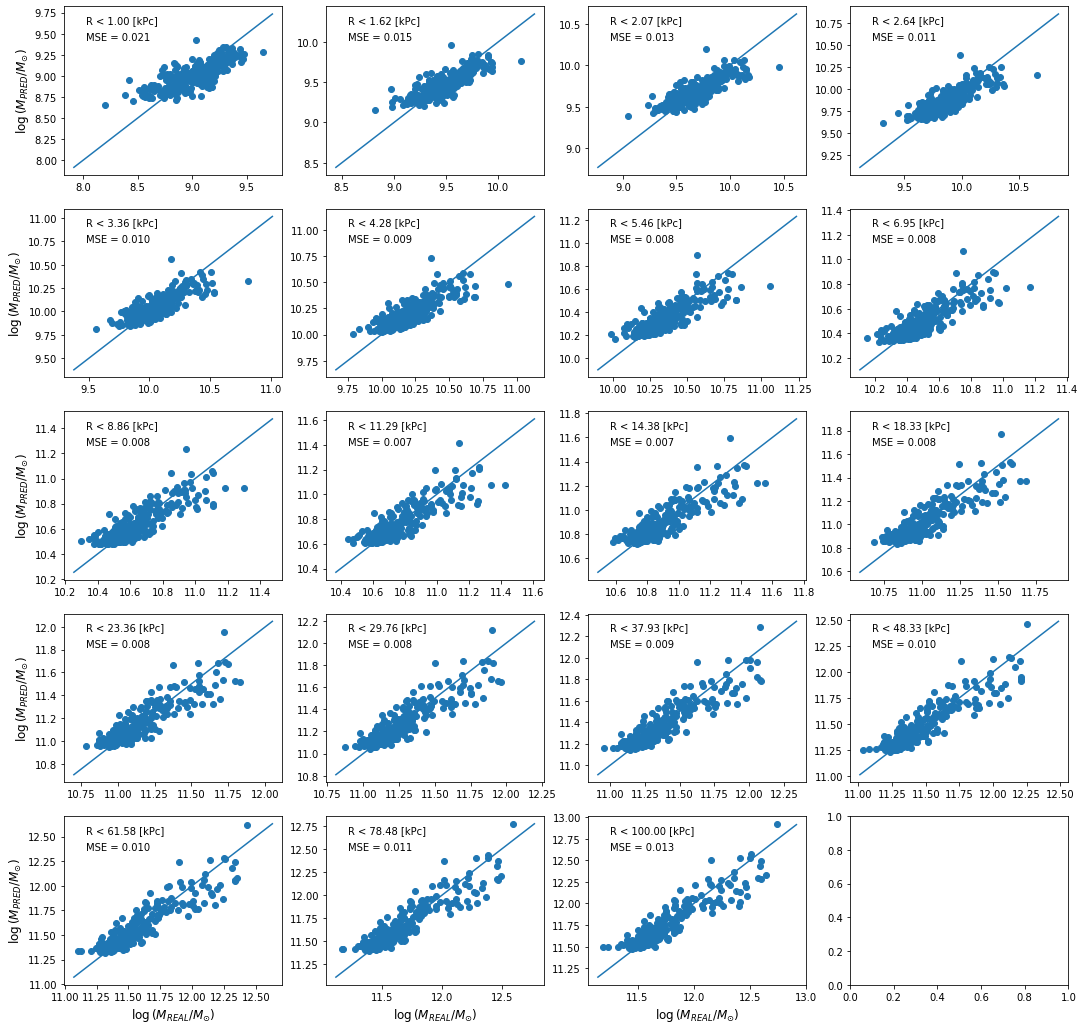

In [134]:
imask = 0
aux_pred = masked_mass_predictions[imask]
fig, ax = plt.subplots(5,4, figsize = (18,18))

for i in range(5):
    for j in range(4):
        if (i*4+j) < len(R_bins):
            ax[i,j].scatter(np.log10(M_real[:,i*4+j]), np.log10(aux_pred[:,i*4+j]))
            ax[i,j].plot([min_y[i*4+j], max_y[i*4+j]], [min_y[i*4+j], max_y[i*4+j]])

            if i == 4: ax[i,j].set_xlabel('$\log{(M_{REAL} / M_{\odot})}$', fontsize = 12)
            if j == 0: ax[i,j].set_ylabel('$\log{(M_{PRED} / M_{\odot})}$', fontsize = 12)

            ax[i,j].text(0.1,0.8,'MSE = {:.3f}'.format(mean_squared_error(np.log10(M_real[:,i*4+j]), np.log10(aux_pred[:,i*4+j]))), transform = ax[i,j].transAxes)
            ax[i,j].text(0.1,0.9,'R < {:.2f} [kPc]'.format(R_bins[i*4+j]), transform = ax[i,j].transAxes)
        
#plt.savefig('../graphs/RealVSPred_' + name + f'_mask_{R_bins[imask]}.pdf')

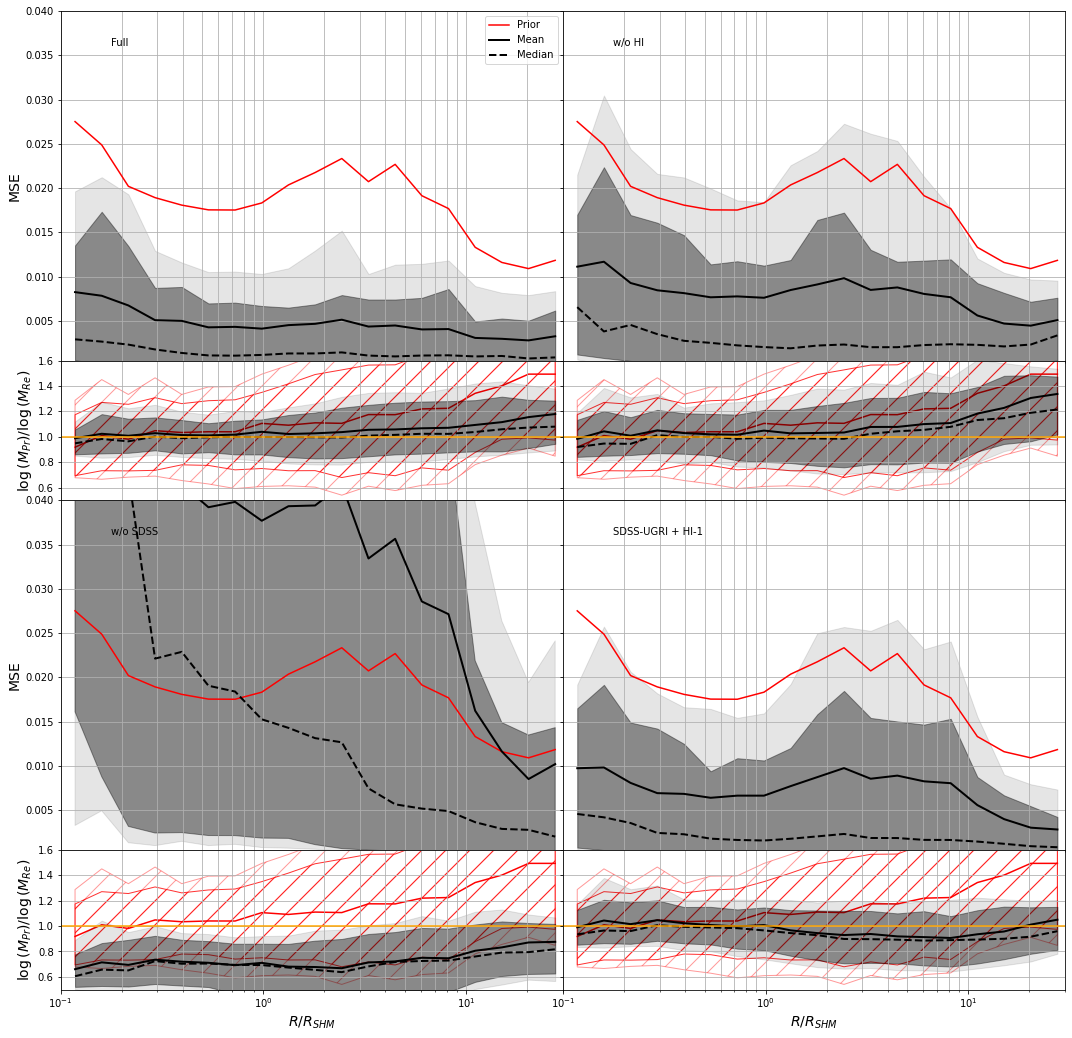

In [135]:
r = np.zeros_like(masked_mass_predictions[0])
for i in range(len(test_ind)):
    r[i,:] = R_bins / properties[test_ind[i], 13]
    
fig,ax = plt.subplots(4,2, figsize = (18,18), gridspec_kw={'height_ratios':[2.5, 1, 2.5, 1], 'hspace':0, 'wspace':0}, sharex = True)

for ii, iaux in enumerate([0,1,2,15]):
    jj = 0
    if ii > 1: 
        ii = ii-2
        jj = jj+2
    aux_pred = masked_mass_predictions[iaux]
    aux_pred = (np.log10(aux_pred) - min_y) / (max_y - min_y)

    bins, bin_centers, mse, std, p10, p16, p50, p84, p90 = binned_MSE(r, (aux_pred - y_testset)**2)
    _, _, mse_prior, prior_std, prior10, prior16, prior50, prior84, prior90 = binned_MSE(r, (y_prior - y_testset)**2, bins = bins)

    ax[jj,ii].plot(bin_centers, mse_prior, color = 'red', label = 'Prior')
    #ax[jj,ii].fill_between(bin_centers, prior10, prior90, color = 'red', alpha = 0.4, hatch = '/', facecolor='none', zorder = 0)
    #ax[jj,ii].fill_between(bin_centers, prior16, prior84, color = 'red', alpha = 0.8, hatch = '/', facecolor='none', zorder = 0)

    ax[jj,ii].plot(bin_centers, mse, color = 'black', label = 'Mean', lw = 2)
    ax[jj,ii].fill_between(bin_centers, p10, p90, color = 'black', alpha = 0.1)
    ax[jj,ii].fill_between(bin_centers, p16, p84, color = 'black', alpha = 0.4)
    ax[jj,ii].plot(bin_centers, p50, color = 'black', label = 'Median', ls = '--', lw = 2)
    
    ax[jj,ii].text(0.1, 0.9, titles[iaux], transform = ax[jj,ii].transAxes)
    
    _, _, ratio, std, p10, p16, p50, p84, p90 = binned_MSE(r, aux_pred / y_testset, bins = bins)
    _, _, ratio_prior, prior_std, prior10, prior16, prior50, prior84, prior90 = binned_MSE(r, y_prior / y_testset, bins = bins)

    ax[jj+1,ii].plot(bin_centers, ratio_prior, color = 'red', label = 'Prior', zorder = 0)
    ax[jj+1,ii].fill_between(bin_centers, prior10, prior90, color = 'red', alpha = 0.4, hatch = '/', facecolor='none', zorder = 0)
    ax[jj+1,ii].fill_between(bin_centers, prior16, prior84, color = 'red', alpha = 0.8, hatch = '/', facecolor='none', zorder = 0)

    ax[jj+1,ii].plot(bin_centers, ratio, color = 'black', label = 'Mean', lw = 2)
    ax[jj+1,ii].fill_between(bin_centers, p10, p90, color = 'black', alpha = 0.1)
    ax[jj+1,ii].fill_between(bin_centers, p16, p84, color = 'black', alpha = 0.4)
    ax[jj+1,ii].plot(bin_centers, p50, color = 'black', label = 'Median', ls = '--', lw = 2)


ax[1,0].axhline(y=1, color = 'orange')
ax[1,1].axhline(y=1, color = 'orange')
ax[3,0].axhline(y=1, color = 'orange')
ax[3,1].axhline(y=1, color = 'orange')

ax[0,0].set_ylim(0.0005,0.04)
ax[1,0].set_ylim(0.5,1.6)
ax[0,1].set_ylim(0.0005,0.04)
ax[1,1].set_ylim(0.5,1.6)
ax[2,0].set_ylim(0.0005,0.04)
ax[3,0].set_ylim(0.5,1.6)
ax[2,1].set_ylim(0.0005,0.04)
ax[3,1].set_ylim(0.5,1.6)

ax[0,0].set_xlim(0.1, 30)

ax[3,0].set_xlabel('$R / R_{SHM}$', fontsize = 14)
ax[3,1].set_xlabel('$R / R_{SHM}$', fontsize = 14)
    
ax[0,0].set_ylabel('MSE', fontsize = 14)
ax[1,0].set_ylabel('$\\log{ (M_{Pr}) } / \\log{(M_{Re})}$', fontsize = 14)
ax[2,0].set_ylabel('MSE', fontsize = 14)
ax[3,0].set_ylabel('$\\log{ (M_{Pr}) } / \\log{(M_{Re})}$', fontsize = 14)
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')
ax[2,1].set_ylabel('')
ax[3,1].set_ylabel('')

ax[0,1].set_yticklabels([])
ax[1,1].set_yticklabels([])
ax[2,1].set_yticklabels([])
ax[3,1].set_yticklabels([])

for i, iax in enumerate(fig.axes): iax.grid(which = 'both')

ax[0,0].set_xscale('log')
ax[0,0].legend()

plt.savefig('../graphs/MaskedChannelsNormalizedMSE_' + name + '.pdf')

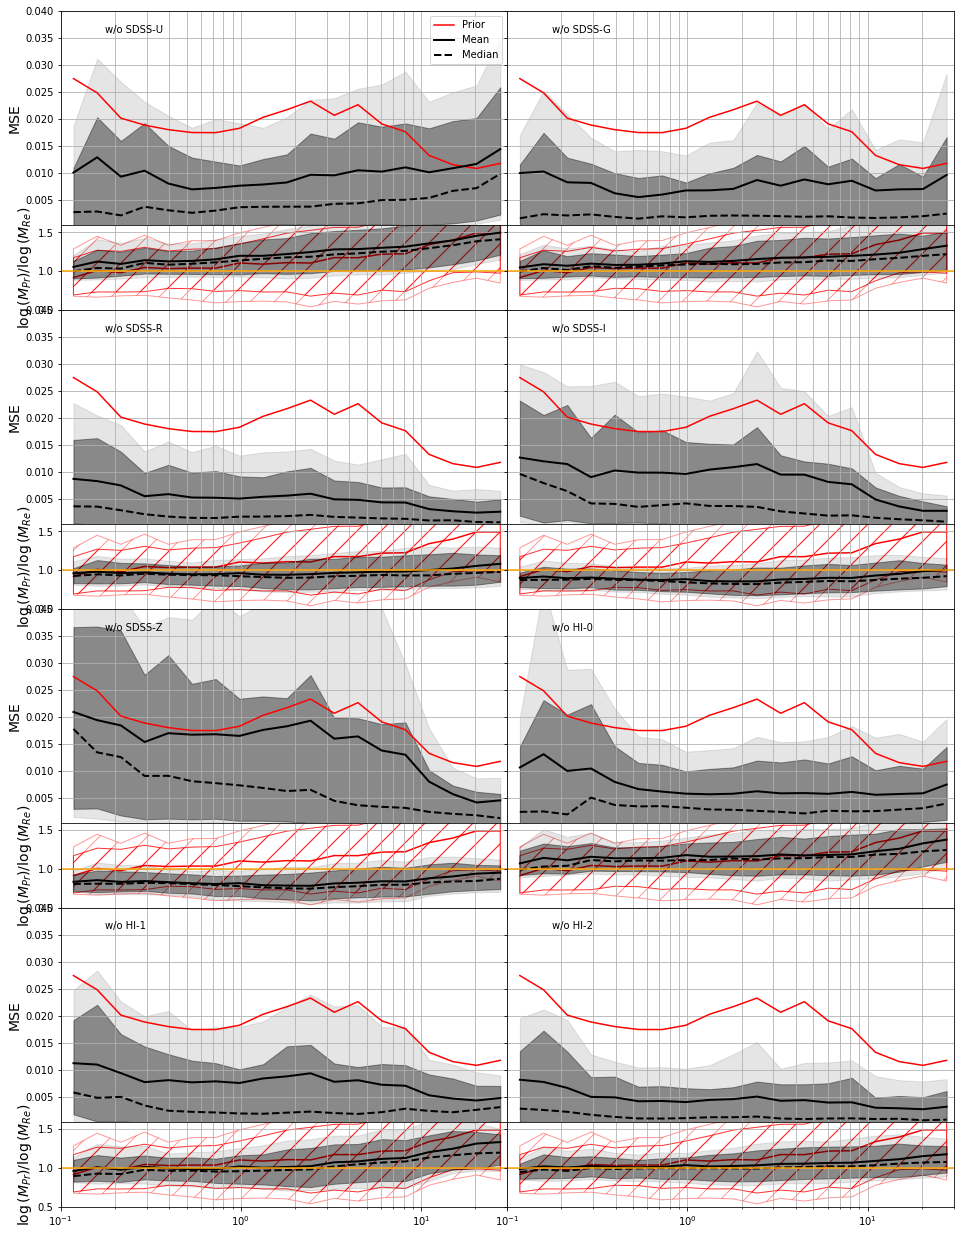

In [136]:
r = np.zeros_like(masked_mass_predictions[0])
for i in range(len(test_ind)):
    r[i,:] = R_bins / properties[test_ind[i], 13]
    
fig,ax = plt.subplots(8,2, figsize = (16,22), gridspec_kw={'height_ratios':[2.5, 1, 2.5, 1, 2.5, 1, 2.5, 1], 'hspace':0, 'wspace':0}, sharex = True)

jj_vals = [0,0,2,2,4,4,6,6]
ii_vals = [0,1,0,1,0,1,0,1]
for i, iaux in enumerate([3,4,5,6,7,8,9,10]):
    jj = jj_vals[i]
    ii = ii_vals[i]
    #if ii > 1: 
    #    ii = ii-2
        #jj = jj+2
    aux_pred = masked_mass_predictions[iaux]
    aux_pred = (np.log10(aux_pred) - min_y) / (max_y - min_y)

    bins, bin_centers, mse, std, p10, p16, p50, p84, p90 = binned_MSE(r, (aux_pred - y_testset)**2)
    _, _, mse_prior, prior_std, prior10, prior16, prior50, prior84, prior90 = binned_MSE(r, (y_prior - y_testset)**2, bins = bins)

    ax[jj,ii].plot(bin_centers, mse_prior, color = 'red', label = 'Prior')
    #ax[jj,ii].fill_between(bin_centers, prior10, prior90, color = 'red', alpha = 0.4, hatch = '/', facecolor='none', zorder = 0)
    #ax[jj,ii].fill_between(bin_centers, prior16, prior84, color = 'red', alpha = 0.8, hatch = '/', facecolor='none', zorder = 0)

    ax[jj,ii].plot(bin_centers, mse, color = 'black', label = 'Mean', lw = 2)
    ax[jj,ii].fill_between(bin_centers, p10, p90, color = 'black', alpha = 0.1)
    ax[jj,ii].fill_between(bin_centers, p16, p84, color = 'black', alpha = 0.4)
    ax[jj,ii].plot(bin_centers, p50, color = 'black', label = 'Median', ls = '--', lw = 2)
    
    ax[jj,ii].text(0.1, 0.9, titles[iaux], transform = ax[jj,ii].transAxes)
    
    _, _, ratio, std, p10, p16, p50, p84, p90 = binned_MSE(r, aux_pred / y_testset, bins = bins)
    _, _, ratio_prior, prior_std, prior10, prior16, prior50, prior84, prior90 = binned_MSE(r, y_prior / y_testset, bins = bins)

    ax[jj+1,ii].plot(bin_centers, ratio_prior, color = 'red', label = 'Prior', zorder = 0)
    ax[jj+1,ii].fill_between(bin_centers, prior10, prior90, color = 'red', alpha = 0.4, hatch = '/', facecolor='none', zorder = 0)
    ax[jj+1,ii].fill_between(bin_centers, prior16, prior84, color = 'red', alpha = 0.8, hatch = '/', facecolor='none', zorder = 0)

    ax[jj+1,ii].plot(bin_centers, ratio, color = 'black', label = 'Mean', lw = 2)
    ax[jj+1,ii].fill_between(bin_centers, p10, p90, color = 'black', alpha = 0.1)
    ax[jj+1,ii].fill_between(bin_centers, p16, p84, color = 'black', alpha = 0.4)
    ax[jj+1,ii].plot(bin_centers, p50, color = 'black', label = 'Median', ls = '--', lw = 2)


ax[1,0].axhline(y=1, color = 'orange')
ax[1,1].axhline(y=1, color = 'orange')
ax[3,0].axhline(y=1, color = 'orange')
ax[3,1].axhline(y=1, color = 'orange')
ax[5,0].axhline(y=1, color = 'orange')
ax[5,1].axhline(y=1, color = 'orange')
ax[7,0].axhline(y=1, color = 'orange')
ax[7,1].axhline(y=1, color = 'orange')

ax[0,0].set_ylim(0.0005,0.04)
ax[1,0].set_ylim(0.5,1.6)
ax[0,1].set_ylim(0.0005,0.04)
ax[1,1].set_ylim(0.5,1.6)
ax[2,0].set_ylim(0.0005,0.04)
ax[3,0].set_ylim(0.5,1.6)
ax[2,1].set_ylim(0.0005,0.04)
ax[3,1].set_ylim(0.5,1.6)
ax[4,0].set_ylim(0.0005,0.04)
ax[5,0].set_ylim(0.5,1.6)
ax[4,1].set_ylim(0.0005,0.04)
ax[5,1].set_ylim(0.5,1.6)
ax[6,0].set_ylim(0.0005,0.04)
ax[7,0].set_ylim(0.5,1.6)
ax[6,1].set_ylim(0.0005,0.04)
ax[7,1].set_ylim(0.5,1.6)

ax[0,0].set_xlim(0.1, 30)

ax[3,0].set_xlabel('$R / R_{SHM}$', fontsize = 14)
ax[3,1].set_xlabel('$R / R_{SHM}$', fontsize = 14)
    
ax[0,0].set_ylabel('MSE', fontsize = 14)
ax[1,0].set_ylabel('$\\log{ (M_{Pr}) } / \\log{(M_{Re})}$', fontsize = 14)
ax[2,0].set_ylabel('MSE', fontsize = 14)
ax[3,0].set_ylabel('$\\log{ (M_{Pr}) } / \\log{(M_{Re})}$', fontsize = 14)
ax[4,0].set_ylabel('MSE', fontsize = 14)
ax[5,0].set_ylabel('$\\log{ (M_{Pr}) } / \\log{(M_{Re})}$', fontsize = 14)
ax[6,0].set_ylabel('MSE', fontsize = 14)
ax[7,0].set_ylabel('$\\log{ (M_{Pr}) } / \\log{(M_{Re})}$', fontsize = 14)
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')
ax[2,1].set_ylabel('')
ax[3,1].set_ylabel('')
ax[4,1].set_ylabel('')
ax[5,1].set_ylabel('')
ax[6,1].set_ylabel('')
ax[7,1].set_ylabel('')

ax[0,1].set_yticklabels([])
ax[1,1].set_yticklabels([])
ax[2,1].set_yticklabels([])
ax[3,1].set_yticklabels([])
ax[4,1].set_yticklabels([])
ax[5,1].set_yticklabels([])
ax[6,1].set_yticklabels([])
ax[7,1].set_yticklabels([])

for i, iax in enumerate(fig.axes): iax.grid(which = 'both')

ax[0,0].set_xscale('log')
ax[0,0].legend()

plt.savefig('../graphs/Masked1DChannelsNormalizedMSE_' + name + '.pdf')

# Deprecated

In [ ]:
#model.load_state_dict(torch.load('../data/models/best_model_8ch.pth', weights_only=True))
#noise_levels = np.array([1e-1,1e-1,1e-1,1e-1,1e-1,1e-1,1e-1,1e-1]).reshape(1,8,1,1)

# Ensure the model is in evaluation mode
model.eval()

# Get one batch of test images
#%for images, labels in test_loader:
images, _ = next(iter(test_loader))
nimg = 20
nbin = 1
image = images[nimg].unsqueeze(0)

noise_levels = np.array([1e-3,1e-3,1e-3,1e-3,1e-3]).reshape(1,nch,1,1)
#%noise_levels = np.array([1e-3,1e-3,1e-3,1e-3,1e-3,1e-2,1e-5,1e-7]).reshape(1,8,1,1)
#%noise_levels = 2.5*np.median(image.detach().numpy(), axis = (0,2,3)).reshape(1,8,1,1)
# Use only the first image from the batch
image.requires_grad = True  # Enable gradient computation


# Initialize an empty tensor to accumulate gradients
accumulated_saliency = torch.zeros_like(image)

# Number of forward passes for averaging
num_perturbations = 200  # Adjust the number of perturbations as needed

#%for _ in range(num_perturbations):
    # Forward pass
#%    output = model(image)  # Output shape: (1, 20)

#%    model.zero_grad()  # Zero gradients before each backward pass

    # Compute gradients for the i-th output (explicitly providing gradient tensor)
#%    output[0, nbin].backward(retain_graph=True)

    # Accumulate gradients
#%    accumulated_saliency += image.grad
num_perturbations = 20
for _ in range(num_perturbations):
    # Add Gaussian noise to the image
    noisy_image = image + torch.Tensor(noise_levels) * torch.randn_like(image)

    # Forward pass
    output = model(noisy_image)

    # Zero out any previous gradients
    model.zero_grad()

    # Compute the gradient of the output with respect to the target index
    output[0, nbin].backward(retain_graph=True)

    # Accumulate the gradients
    accumulated_saliency += image.grad

# Average the accumulated saliency maps
accumulated_saliency /= num_perturbations

# Get the final saliency map (absolute value of gradients)
saliency_map = accumulated_saliency.abs().squeeze().detach().cpu().numpy()
    

In [120]:
# build model
model = Sequential()

model.add(Conv2D(filters = 5, kernel_size = (5,5), strides = 1 , padding = 'same', input_shape = input_shape))
#model.add(BatchNormalization())
model.add(Activation(actFunction))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters = 15, kernel_size = (5,5), strides = 1 , padding = 'same'))
#model.add(BatchNormalization())
model.add(Activation(actFunction))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters = 30, kernel_size = (5,5), strides = 1 , padding = 'same'))
#model.add(BatchNormalization())
model.add(Activation(actFunction))
model.add(MaxPooling2D(pool_size=(2, 2)))

#model.add(Dropout(0.2)) 
model.add(Flatten())

#model.add(BatchNormalization())
model.add(Dense(intermediate_dim1, activation = actFunction))

#model.add(BatchNormalization())
model.add(Dense(intermediate_dim2, activation = actFunction))

#model.add(BatchNormalization())
model.add(Dense(intermediate_dim3, activation = actFunction))

#model.add(BatchNormalization())
model.add(Dense(intermediate_dim4, activation = 'linear'))

model.add(Dense(output_dim, name = 'output'))

model.summary()

# instantiate model
optimizer = optimizers.Adam(learning_rate = 1e-5, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
model.compile(optimizer = optimizer, loss = 'mse', metrics=['mae','mse'])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 128, 128, 5)       1005      
                                                                 
 batch_normalization_7 (Bat  (None, 128, 128, 5)       20        
 chNormalization)                                                
                                                                 
 activation_18 (Activation)  (None, 128, 128, 5)       0         
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 64, 64, 5)         0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 64, 64, 15)        1890      
                                                                 
 batch_normalization_8 (Bat  (None, 64, 64, 15)       

In [103]:
batch_size = 32
epochs     = 250
history = model.fit(x_trainset[:batch_size], y_trainset[:batch_size],
                   epochs = epochs,
                   validation_data = (x_trainset[:batch_size], y_trainset[:batch_size]))

Epoch 1/250
1/1 [==============================] - 1s 1s/step - loss: 0.3322 - mae: 0.5282 - mse: 0.3322 - val_loss: 0.3210 - val_mae: 0.5184 - val_mse: 0.3210
Epoch 2/250
1/1 [==============================] - 0s 265ms/step - loss: 0.3210 - mae: 0.5184 - mse: 0.3210 - val_loss: 0.3104 - val_mae: 0.5089 - val_mse: 0.3104
Epoch 3/250
1/1 [==============================] - 0s 275ms/step - loss: 0.3104 - mae: 0.5089 - mse: 0.3104 - val_loss: 0.3009 - val_mae: 0.5002 - val_mse: 0.3009
Epoch 4/250
1/1 [==============================] - 0s 345ms/step - loss: 0.3009 - mae: 0.5002 - mse: 0.3009 - val_loss: 0.2919 - val_mae: 0.4918 - val_mse: 0.2919
Epoch 5/250
1/1 [==============================] - 0s 314ms/step - loss: 0.2919 - mae: 0.4918 - mse: 0.2919 - val_loss: 0.2837 - val_mae: 0.4839 - val_mse: 0.2837
Epoch 6/250
1/1 [==============================] - 0s 291ms/step - loss: 0.2837 - mae: 0.4839 - mse: 0.2837 - val_loss: 0.2761 - val_mae: 0.4765 - val_mse: 0.2761
Epoch 7/250
1/1 [========

In [ ]:
y_predicted = model.predict(x_testset) * (max_y - min_y) + min_y

In [ ]:
from pts.visual.rgbimage import RGBImage
import astropy.units as u

img_array = x_testset[nimg,ch,:,:] * (max_x - min_x) + min_x
img_array = np.stack((img_array, img_array, img_array), axis=-1) * u.Unit('MJy/sr')
image = RGBImage(img_array.value)
fmin = 1e-5 * u.MJy/u.sr
fmax = 1e3 * u.MJy/u.sr
image.setRange(fmin.value, fmax.value)
image.applyLog()     # Aplicar transformación logarítmica
image.applyCurve()   # Aplicar curva de color
image.plot()